# Training Unet With all Backbones

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
from tqdm import tqdm
from PIL import Image
import segmentation_models_pytorch as smp

# ---------------------------------------------------------------------
# GLOBAL CONFIG
# ---------------------------------------------------------------------
IMG_HEIGHT    = 640
IMG_WIDTH     = 640
BATCH_SIZE    = 2
EPOCHS        = 100
NUM_CLASSES   = 3
LEARNING_RATE = 0.001
PATIENCE      = 10  # Early stopping patience
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training + Validation data
TRAIN_IMAGE_DIR = 'CWD-3HSV/train/images'
TRAIN_MASK_DIR  = 'CWD-3HSV/train/Morphed_Images'
VALID_IMAGE_DIR = 'CWD-3HSV/valid/images'
VALID_MASK_DIR  = 'CWD-3HSV/valid/Morphed_Images'

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# ---------------------------------------------------------------------
# 1) Dataset Definition
# ---------------------------------------------------------------------
class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None):
        self.image_files = image_files
        self.mask_files  = mask_files
        self.transform   = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path  = self.image_files[idx]
        mask_path = self.mask_files[idx]

        image = Image.open(img_path).convert('RGB')
        mask  = Image.open(mask_path).convert('L')

        image = image.resize((IMG_WIDTH, IMG_HEIGHT))
        mask  = mask.resize((IMG_WIDTH,  IMG_HEIGHT))

        if self.transform:
            image = self.transform(image)
            mask  = torch.tensor(np.array(mask), dtype=torch.long)

        return image, mask

# ---------------------------------------------------------------------
# 2) IoU + IoU loss
# ---------------------------------------------------------------------
def calculate_iou(outputs, masks, num_classes):
    outputs = torch.argmax(outputs, dim=1)
    iou_per_class = []
    for cls in range(num_classes):
        intersection = ((outputs == cls) & (masks == cls)).sum().item()
        union        = ((outputs == cls) | (masks == cls)).sum().item()
        if union == 0:
            iou_per_class.append(float('nan'))
        else:
            iou_per_class.append(intersection / union)
    return np.nanmean(iou_per_class)

def calculate_iou_loss(outputs, masks, num_classes):
    outputs = torch.argmax(outputs, dim=1)
    iou_per_class = []
    for cls in range(num_classes):
        intersection = ((outputs == cls) & (masks == cls)).sum().item()
        union        = ((outputs == cls) | (masks == cls)).sum().item()
        if union == 0:
            iou_per_class.append(float('nan'))
        else:
            iou_per_class.append(intersection / union)
    return 1 - np.nanmean(iou_per_class)

# ---------------------------------------------------------------------
# 3) Train + Val loops
# ---------------------------------------------------------------------
def train_epoch(model, data_loader, optimizer, criterion):
    model.train()
    running_loss     = 0.0
    running_iou_loss = 0.0
    correct          = 0
    total            = 0
    iou_score        = 0

    for images, masks in tqdm(data_loader, desc='Training', leave=False):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        iou_loss = calculate_iou_loss(outputs, masks, NUM_CLASSES)

        loss.backward()
        optimizer.step()

        running_loss     += loss.item()
        running_iou_loss += iou_loss
        _, predicted     = torch.max(outputs, 1)
        total           += masks.numel()
        correct         += (predicted == masks).sum().item()
        iou_score       += calculate_iou(outputs, masks, NUM_CLASSES)

    epoch_loss     = running_loss / len(data_loader)
    epoch_iou_loss = running_iou_loss / len(data_loader)
    epoch_accuracy = correct / total * 100
    epoch_iou      = iou_score / len(data_loader)
    return epoch_loss, epoch_accuracy, epoch_iou, epoch_iou_loss

def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss     = 0.0
    running_iou_loss = 0.0
    correct          = 0
    total            = 0
    iou_score        = 0

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc='Validating', leave=False):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs  = model(images)

            loss     = criterion(outputs, masks)
            iou_loss = calculate_iou_loss(outputs, masks, NUM_CLASSES)
            running_loss     += loss.item()
            running_iou_loss += iou_loss

            _, predicted = torch.max(outputs, 1)
            total       += masks.numel()
            correct     += (predicted == masks).sum().item()
            iou_score   += calculate_iou(outputs, masks, NUM_CLASSES)

    epoch_loss     = running_loss / len(data_loader)
    epoch_iou_loss = running_iou_loss / len(data_loader)
    epoch_accuracy = correct / total * 100
    epoch_iou      = iou_score / len(data_loader)
    return epoch_loss, epoch_accuracy, epoch_iou, epoch_iou_loss

# ---------------------------------------------------------------------
# 4) UNet creation with variable encoders
# ---------------------------------------------------------------------
def create_unet_model(encoder_name, num_classes=NUM_CLASSES):
    model = smp.Unet(
        encoder_name=encoder_name,  # e.g. "resnet34", "resnet50", ...
        encoder_weights="imagenet", # or None
        in_channels=3,
        classes=num_classes
    )
    return model

# ---------------------------------------------------------------------
# 5) MAIN TRAINING FOR A SINGLE ENCODER
# ---------------------------------------------------------------------
def train_unet_with_encoder(encoder_name, train_loader, val_loader):
    """
    Trains UNet with the specified encoder_name. 
    Saves best model + metrics to a newly created directory, e.g. "Unet-resnet34".
    """
    print(f"\n=== Training UNet with encoder: {encoder_name} ===")

    # 1) Create directory for this encoder
    model_dir = f"Unet-{encoder_name}"
    os.makedirs(model_dir, exist_ok=True)

    # 2) Create model
    model = create_unet_model(encoder_name, NUM_CLASSES).to(DEVICE)

    # 3) Optimizer + Criterion
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion= nn.CrossEntropyLoss()

    best_val_loss    = float('inf')
    best_model_path  = None
    patience_counter = 0
    records          = []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS} for {encoder_name}")
        train_loss, train_acc, train_iou, train_iou_loss = train_epoch(model, train_loader, optimizer, criterion)
        print(f" Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% | IoU: {train_iou:.4f} | IoU Loss: {train_iou_loss:.4f}")

        val_loss, val_acc, val_iou, val_iou_loss = evaluate(model, val_loader, criterion)
        print(f" Val   Loss: {val_loss:.4f} | Acc: {val_acc:.2f}% | IoU: {val_iou:.4f} | IoU Loss: {val_iou_loss:.4f}")

        records.append([
            epoch+1,
            train_loss, 
            train_acc, 
            val_loss, 
            val_acc, 
            train_iou_loss, 
            train_iou, 
            val_iou_loss, 
            val_iou
        ])

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(model_dir, 'unet_best_model.pth')
            torch.save(model, best_model_path)
            print(f"  Model saved at {best_model_path}")
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print("  Early stopping triggered!")
            break

    # 4) Save metrics to Excel named "Training_Metrics.xlsx"
    columns = [
        "Epoch",
        "Training Loss",
        "Training Accuracy",
        "Validation Loss",
        "Validation Accuracy",
        "Training IoU loss",
        "Mean Training IoU",
        "Validation IoU loss",
        "Mean Validation IoU"
    ]
    df = pd.DataFrame(records, columns=columns)
    excel_path = os.path.join(model_dir, "Training_Metrics.xlsx")
    df.to_excel(excel_path, index=False)
    print(f"Metrics for {encoder_name} saved to {excel_path}")

# ---------------------------------------------------------------------
# 6) SETUP + RUN
# ---------------------------------------------------------------------
if __name__ == "__main__":
    # 1) List all available encoders from SMP if you want all
    # However, this might be too many. 
    # You can pick a subset instead if you want.

    all_encoders = list(smp.encoders.encoders.keys())
    # e.g. you might want only some:
    all_encoders = ["resnet18","resnet34","resnet50","resnet101","resnet152",
                    "efficientnet-b0","efficientnet-b1","efficientnet-b2","efficientnet-b3","efficientnet-b4","efficientnet-b5","efficientnet-b6","efficientnet-b7",
                    "vgg11","vgg13","vgg16","vgg19",
                    "mobilenet_v2"]
    # or the entire set is huge

    print("Available encoders in smp:", all_encoders)
    
    # 2) Setup the training/validation dataset + loader
    train_imgs = [f for f in os.listdir(TRAIN_IMAGE_DIR) if f.endswith('.jpg')]
    mask_files = [f.replace('.jpg', '_morphed.png') for f in train_imgs]
    
    valid_image_files, valid_mask_files = [], []
    for img_file in train_imgs:
        mf = img_file.replace('.jpg', '_morphed.png')
        if mf in os.listdir(TRAIN_MASK_DIR):
            valid_image_files.append(os.path.join(TRAIN_IMAGE_DIR, img_file))
            valid_mask_files.append(os.path.join(TRAIN_MASK_DIR,  mf))

    val_imgs = [f for f in os.listdir(VALID_IMAGE_DIR) if f.endswith('.jpg')]
    val_masks= [f.replace('.jpg', '_morphed.png') for f in val_imgs]
    val_image_files= [os.path.join(VALID_IMAGE_DIR, f) for f in val_imgs]
    val_mask_files = [os.path.join(VALID_MASK_DIR, f) for f in val_masks]

    transform_ = transforms.Compose([transforms.ToTensor()])
    train_dataset= SegmentationDataset(valid_image_files, valid_mask_files, transform=transform_)
    val_dataset  = SegmentationDataset(val_image_files,   val_mask_files,   transform=transform_)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

    # 3) Loop over encoders
    for encoder_name in all_encoders:
        train_unet_with_encoder(encoder_name, train_loader, val_loader)

    print("==== All encoders training complete! ====")


Available encoders in smp: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'vgg11', 'vgg13', 'vgg16', 'vgg19', 'mobilenet_v2']

=== Training UNet with encoder: resnet18 ===

Epoch 1/100 for resnet18


 Train Loss: 0.2331 | Acc: 91.30% | IoU: 0.7922 | IoU Loss: 0.2078


 Val   Loss: 0.1541 | Acc: 93.89% | IoU: 0.8608 | IoU Loss: 0.1392
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 2/100 for resnet18


 Train Loss: 0.1548 | Acc: 94.07% | IoU: 0.8458 | IoU Loss: 0.1542


 Val   Loss: 0.1559 | Acc: 93.56% | IoU: 0.8427 | IoU Loss: 0.1573

Epoch 3/100 for resnet18


 Train Loss: 0.1417 | Acc: 94.58% | IoU: 0.8571 | IoU Loss: 0.1429


 Val   Loss: 0.1195 | Acc: 95.36% | IoU: 0.8880 | IoU Loss: 0.1120
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 4/100 for resnet18


 Train Loss: 0.1374 | Acc: 94.77% | IoU: 0.8598 | IoU Loss: 0.1402


 Val   Loss: 0.1519 | Acc: 93.82% | IoU: 0.8478 | IoU Loss: 0.1522

Epoch 5/100 for resnet18


 Train Loss: 0.1252 | Acc: 95.16% | IoU: 0.8723 | IoU Loss: 0.1277


 Val   Loss: 0.1354 | Acc: 94.63% | IoU: 0.8672 | IoU Loss: 0.1328

Epoch 6/100 for resnet18


 Train Loss: 0.1228 | Acc: 95.27% | IoU: 0.8740 | IoU Loss: 0.1260


 Val   Loss: 0.1686 | Acc: 93.76% | IoU: 0.8538 | IoU Loss: 0.1462

Epoch 7/100 for resnet18


 Train Loss: 0.1207 | Acc: 95.37% | IoU: 0.8764 | IoU Loss: 0.1236


 Val   Loss: 0.1443 | Acc: 94.44% | IoU: 0.8737 | IoU Loss: 0.1263

Epoch 8/100 for resnet18


 Train Loss: 0.1127 | Acc: 95.71% | IoU: 0.8858 | IoU Loss: 0.1142


 Val   Loss: 0.1318 | Acc: 94.65% | IoU: 0.8724 | IoU Loss: 0.1276

Epoch 9/100 for resnet18


 Train Loss: 0.1108 | Acc: 95.76% | IoU: 0.8878 | IoU Loss: 0.1122


 Val   Loss: 0.4248 | Acc: 80.86% | IoU: 0.5992 | IoU Loss: 0.4008

Epoch 10/100 for resnet18


 Train Loss: 0.1088 | Acc: 95.83% | IoU: 0.8869 | IoU Loss: 0.1131


 Val   Loss: 0.1665 | Acc: 93.48% | IoU: 0.8473 | IoU Loss: 0.1527

Epoch 11/100 for resnet18


 Train Loss: 0.1060 | Acc: 95.94% | IoU: 0.8896 | IoU Loss: 0.1104


 Val   Loss: 0.1096 | Acc: 95.58% | IoU: 0.8943 | IoU Loss: 0.1057
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 12/100 for resnet18


 Train Loss: 0.1005 | Acc: 96.13% | IoU: 0.8953 | IoU Loss: 0.1047


 Val   Loss: 0.1254 | Acc: 94.99% | IoU: 0.8777 | IoU Loss: 0.1223

Epoch 13/100 for resnet18


 Train Loss: 0.0969 | Acc: 96.25% | IoU: 0.8996 | IoU Loss: 0.1004


 Val   Loss: 0.1646 | Acc: 94.16% | IoU: 0.8585 | IoU Loss: 0.1415

Epoch 14/100 for resnet18


 Train Loss: 0.0976 | Acc: 96.25% | IoU: 0.8992 | IoU Loss: 0.1008


 Val   Loss: 0.0951 | Acc: 96.29% | IoU: 0.9054 | IoU Loss: 0.0946
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 15/100 for resnet18


 Train Loss: 0.0933 | Acc: 96.39% | IoU: 0.9032 | IoU Loss: 0.0968


 Val   Loss: 0.0968 | Acc: 96.19% | IoU: 0.9048 | IoU Loss: 0.0952

Epoch 16/100 for resnet18


 Train Loss: 0.0935 | Acc: 96.38% | IoU: 0.9024 | IoU Loss: 0.0976


 Val   Loss: 0.1129 | Acc: 95.55% | IoU: 0.8922 | IoU Loss: 0.1078

Epoch 17/100 for resnet18


 Train Loss: 0.0909 | Acc: 96.45% | IoU: 0.9069 | IoU Loss: 0.0931


 Val   Loss: 0.0970 | Acc: 96.05% | IoU: 0.9069 | IoU Loss: 0.0931

Epoch 18/100 for resnet18


 Train Loss: 0.0889 | Acc: 96.53% | IoU: 0.9087 | IoU Loss: 0.0913


 Val   Loss: 0.1011 | Acc: 96.12% | IoU: 0.9078 | IoU Loss: 0.0922

Epoch 19/100 for resnet18


 Train Loss: 0.0910 | Acc: 96.47% | IoU: 0.9068 | IoU Loss: 0.0932


 Val   Loss: 0.0850 | Acc: 96.73% | IoU: 0.9180 | IoU Loss: 0.0820
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 20/100 for resnet18


 Train Loss: 0.0860 | Acc: 96.67% | IoU: 0.9109 | IoU Loss: 0.0891


 Val   Loss: 0.0842 | Acc: 96.83% | IoU: 0.9177 | IoU Loss: 0.0823
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 21/100 for resnet18


 Train Loss: 0.0839 | Acc: 96.72% | IoU: 0.9158 | IoU Loss: 0.0842


 Val   Loss: 0.1048 | Acc: 95.84% | IoU: 0.8937 | IoU Loss: 0.1063

Epoch 22/100 for resnet18


 Train Loss: 0.0855 | Acc: 96.64% | IoU: 0.9113 | IoU Loss: 0.0887


 Val   Loss: 0.0994 | Acc: 96.11% | IoU: 0.8955 | IoU Loss: 0.1045

Epoch 23/100 for resnet18


 Train Loss: 0.0823 | Acc: 96.78% | IoU: 0.9173 | IoU Loss: 0.0827


 Val   Loss: 0.1007 | Acc: 95.97% | IoU: 0.9051 | IoU Loss: 0.0949

Epoch 24/100 for resnet18


 Train Loss: 0.0819 | Acc: 96.80% | IoU: 0.9173 | IoU Loss: 0.0827


 Val   Loss: 0.0988 | Acc: 96.10% | IoU: 0.9078 | IoU Loss: 0.0922

Epoch 25/100 for resnet18


 Train Loss: 0.0865 | Acc: 96.62% | IoU: 0.9092 | IoU Loss: 0.0908


 Val   Loss: 0.0826 | Acc: 96.96% | IoU: 0.9200 | IoU Loss: 0.0800
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 26/100 for resnet18


 Train Loss: 0.0790 | Acc: 96.89% | IoU: 0.9188 | IoU Loss: 0.0812


 Val   Loss: 0.1015 | Acc: 95.89% | IoU: 0.8973 | IoU Loss: 0.1027

Epoch 27/100 for resnet18


 Train Loss: 0.0778 | Acc: 96.91% | IoU: 0.9216 | IoU Loss: 0.0784


 Val   Loss: 0.0786 | Acc: 97.08% | IoU: 0.9242 | IoU Loss: 0.0758
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 28/100 for resnet18


 Train Loss: 0.0755 | Acc: 97.00% | IoU: 0.9237 | IoU Loss: 0.0763


 Val   Loss: 0.0833 | Acc: 96.74% | IoU: 0.9183 | IoU Loss: 0.0817

Epoch 29/100 for resnet18


 Train Loss: 0.0765 | Acc: 96.97% | IoU: 0.9256 | IoU Loss: 0.0744


 Val   Loss: 0.0978 | Acc: 96.21% | IoU: 0.9095 | IoU Loss: 0.0905

Epoch 30/100 for resnet18


 Train Loss: 0.0737 | Acc: 97.07% | IoU: 0.9248 | IoU Loss: 0.0752


 Val   Loss: 0.0960 | Acc: 96.10% | IoU: 0.9080 | IoU Loss: 0.0920

Epoch 31/100 for resnet18


 Train Loss: 0.0739 | Acc: 97.06% | IoU: 0.9270 | IoU Loss: 0.0730


 Val   Loss: 0.1066 | Acc: 96.12% | IoU: 0.8986 | IoU Loss: 0.1014

Epoch 32/100 for resnet18


 Train Loss: 0.0734 | Acc: 97.05% | IoU: 0.9252 | IoU Loss: 0.0748


 Val   Loss: 0.0950 | Acc: 96.63% | IoU: 0.9162 | IoU Loss: 0.0838

Epoch 33/100 for resnet18


 Train Loss: 0.0709 | Acc: 97.15% | IoU: 0.9295 | IoU Loss: 0.0705


 Val   Loss: 0.0793 | Acc: 96.98% | IoU: 0.9238 | IoU Loss: 0.0762

Epoch 34/100 for resnet18


 Train Loss: 0.0727 | Acc: 97.07% | IoU: 0.9254 | IoU Loss: 0.0746


 Val   Loss: 0.1160 | Acc: 95.65% | IoU: 0.8884 | IoU Loss: 0.1116

Epoch 35/100 for resnet18


 Train Loss: 0.0717 | Acc: 97.15% | IoU: 0.9294 | IoU Loss: 0.0706


 Val   Loss: 0.1294 | Acc: 95.13% | IoU: 0.8880 | IoU Loss: 0.1120

Epoch 36/100 for resnet18


 Train Loss: 0.0686 | Acc: 97.20% | IoU: 0.9314 | IoU Loss: 0.0686


 Val   Loss: 0.0770 | Acc: 97.00% | IoU: 0.9240 | IoU Loss: 0.0760
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 37/100 for resnet18


 Train Loss: 0.0695 | Acc: 97.20% | IoU: 0.9315 | IoU Loss: 0.0685


 Val   Loss: 0.0781 | Acc: 97.21% | IoU: 0.9272 | IoU Loss: 0.0728

Epoch 38/100 for resnet18


 Train Loss: 0.0658 | Acc: 97.30% | IoU: 0.9329 | IoU Loss: 0.0671


 Val   Loss: 0.1255 | Acc: 95.49% | IoU: 0.8906 | IoU Loss: 0.1094

Epoch 39/100 for resnet18


 Train Loss: 0.0664 | Acc: 97.28% | IoU: 0.9339 | IoU Loss: 0.0661


 Val   Loss: 0.0738 | Acc: 97.35% | IoU: 0.9295 | IoU Loss: 0.0705
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 40/100 for resnet18


 Train Loss: 0.0723 | Acc: 97.10% | IoU: 0.9238 | IoU Loss: 0.0762


 Val   Loss: 0.0768 | Acc: 97.02% | IoU: 0.9245 | IoU Loss: 0.0755

Epoch 41/100 for resnet18


 Train Loss: 0.0651 | Acc: 97.35% | IoU: 0.9341 | IoU Loss: 0.0659


 Val   Loss: 0.0836 | Acc: 96.95% | IoU: 0.9242 | IoU Loss: 0.0758

Epoch 42/100 for resnet18


 Train Loss: 0.0633 | Acc: 97.41% | IoU: 0.9369 | IoU Loss: 0.0631


 Val   Loss: 0.0893 | Acc: 96.72% | IoU: 0.9193 | IoU Loss: 0.0807

Epoch 43/100 for resnet18


 Train Loss: 0.0682 | Acc: 97.24% | IoU: 0.9282 | IoU Loss: 0.0718


 Val   Loss: 0.0763 | Acc: 97.20% | IoU: 0.9264 | IoU Loss: 0.0736

Epoch 44/100 for resnet18


 Train Loss: 0.0654 | Acc: 97.33% | IoU: 0.9339 | IoU Loss: 0.0661


 Val   Loss: 0.0833 | Acc: 96.95% | IoU: 0.9222 | IoU Loss: 0.0778

Epoch 45/100 for resnet18


 Train Loss: 0.0619 | Acc: 97.44% | IoU: 0.9377 | IoU Loss: 0.0623


 Val   Loss: 0.0889 | Acc: 96.48% | IoU: 0.9172 | IoU Loss: 0.0828

Epoch 46/100 for resnet18


 Train Loss: 0.0621 | Acc: 97.45% | IoU: 0.9383 | IoU Loss: 0.0617


 Val   Loss: 0.1147 | Acc: 95.69% | IoU: 0.8993 | IoU Loss: 0.1007

Epoch 47/100 for resnet18


 Train Loss: 0.0631 | Acc: 97.44% | IoU: 0.9376 | IoU Loss: 0.0624


 Val   Loss: 0.1008 | Acc: 96.04% | IoU: 0.9066 | IoU Loss: 0.0934

Epoch 48/100 for resnet18


 Train Loss: 0.0664 | Acc: 97.32% | IoU: 0.9299 | IoU Loss: 0.0701


 Val   Loss: 0.0754 | Acc: 97.20% | IoU: 0.9276 | IoU Loss: 0.0724

Epoch 49/100 for resnet18


 Train Loss: 0.0603 | Acc: 97.53% | IoU: 0.9388 | IoU Loss: 0.0612


 Val   Loss: 0.0734 | Acc: 97.40% | IoU: 0.9320 | IoU Loss: 0.0680
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 50/100 for resnet18


 Train Loss: 0.0589 | Acc: 97.56% | IoU: 0.9403 | IoU Loss: 0.0597


 Val   Loss: 0.0875 | Acc: 96.63% | IoU: 0.9198 | IoU Loss: 0.0802

Epoch 51/100 for resnet18


 Train Loss: 0.0597 | Acc: 97.54% | IoU: 0.9394 | IoU Loss: 0.0606


 Val   Loss: 0.0781 | Acc: 97.03% | IoU: 0.9253 | IoU Loss: 0.0747

Epoch 52/100 for resnet18


 Train Loss: 0.0583 | Acc: 97.59% | IoU: 0.9418 | IoU Loss: 0.0582


 Val   Loss: 0.0774 | Acc: 97.03% | IoU: 0.9262 | IoU Loss: 0.0738

Epoch 53/100 for resnet18


 Train Loss: 0.0595 | Acc: 97.53% | IoU: 0.9392 | IoU Loss: 0.0608


 Val   Loss: 0.0755 | Acc: 97.28% | IoU: 0.9294 | IoU Loss: 0.0706

Epoch 54/100 for resnet18


 Train Loss: 0.0569 | Acc: 97.64% | IoU: 0.9429 | IoU Loss: 0.0571


 Val   Loss: 0.0722 | Acc: 97.47% | IoU: 0.9339 | IoU Loss: 0.0661
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 55/100 for resnet18


 Train Loss: 0.0564 | Acc: 97.66% | IoU: 0.9430 | IoU Loss: 0.0570


 Val   Loss: 0.0930 | Acc: 96.53% | IoU: 0.9106 | IoU Loss: 0.0894

Epoch 56/100 for resnet18


 Train Loss: 0.0603 | Acc: 97.54% | IoU: 0.9386 | IoU Loss: 0.0614


 Val   Loss: 0.0863 | Acc: 96.72% | IoU: 0.9170 | IoU Loss: 0.0830

Epoch 57/100 for resnet18


 Train Loss: 0.0612 | Acc: 97.47% | IoU: 0.9374 | IoU Loss: 0.0626


 Val   Loss: 0.0807 | Acc: 97.11% | IoU: 0.9256 | IoU Loss: 0.0744

Epoch 58/100 for resnet18


 Train Loss: 0.0587 | Acc: 97.60% | IoU: 0.9388 | IoU Loss: 0.0612


 Val   Loss: 0.0814 | Acc: 96.95% | IoU: 0.9174 | IoU Loss: 0.0826

Epoch 59/100 for resnet18


 Train Loss: 0.0589 | Acc: 97.59% | IoU: 0.9399 | IoU Loss: 0.0601


 Val   Loss: 0.0744 | Acc: 97.47% | IoU: 0.9320 | IoU Loss: 0.0680

Epoch 60/100 for resnet18


 Train Loss: 0.0573 | Acc: 97.63% | IoU: 0.9410 | IoU Loss: 0.0590


 Val   Loss: 0.0809 | Acc: 97.00% | IoU: 0.9236 | IoU Loss: 0.0764

Epoch 61/100 for resnet18


 Train Loss: 0.0524 | Acc: 97.82% | IoU: 0.9462 | IoU Loss: 0.0538


 Val   Loss: 0.0688 | Acc: 97.69% | IoU: 0.9376 | IoU Loss: 0.0624
  Model saved at Unet-resnet18/unet_best_model.pth

Epoch 62/100 for resnet18


 Train Loss: 0.0541 | Acc: 97.77% | IoU: 0.9464 | IoU Loss: 0.0536


 Val   Loss: 0.0785 | Acc: 97.25% | IoU: 0.9288 | IoU Loss: 0.0712

Epoch 63/100 for resnet18


 Train Loss: 0.0525 | Acc: 97.81% | IoU: 0.9469 | IoU Loss: 0.0531


 Val   Loss: 0.0706 | Acc: 97.68% | IoU: 0.9371 | IoU Loss: 0.0629

Epoch 64/100 for resnet18


 Train Loss: 0.0545 | Acc: 97.74% | IoU: 0.9423 | IoU Loss: 0.0577


 Val   Loss: 0.0988 | Acc: 96.18% | IoU: 0.9099 | IoU Loss: 0.0901

Epoch 65/100 for resnet18


 Train Loss: 0.0521 | Acc: 97.83% | IoU: 0.9469 | IoU Loss: 0.0531


 Val   Loss: 0.0715 | Acc: 97.51% | IoU: 0.9344 | IoU Loss: 0.0656

Epoch 66/100 for resnet18


 Train Loss: 0.0516 | Acc: 97.87% | IoU: 0.9476 | IoU Loss: 0.0524


 Val   Loss: 0.0878 | Acc: 96.89% | IoU: 0.9197 | IoU Loss: 0.0803

Epoch 67/100 for resnet18


 Train Loss: 0.0505 | Acc: 97.88% | IoU: 0.9485 | IoU Loss: 0.0515


 Val   Loss: 0.0791 | Acc: 97.25% | IoU: 0.9270 | IoU Loss: 0.0730

Epoch 68/100 for resnet18


 Train Loss: 0.0486 | Acc: 97.96% | IoU: 0.9494 | IoU Loss: 0.0506


 Val   Loss: 0.0893 | Acc: 97.04% | IoU: 0.9212 | IoU Loss: 0.0788

Epoch 69/100 for resnet18


 Train Loss: 0.0561 | Acc: 97.72% | IoU: 0.9407 | IoU Loss: 0.0593


 Val   Loss: 0.0990 | Acc: 96.40% | IoU: 0.9097 | IoU Loss: 0.0903

Epoch 70/100 for resnet18


 Train Loss: 0.0502 | Acc: 97.91% | IoU: 0.9479 | IoU Loss: 0.0521


 Val   Loss: 0.0754 | Acc: 97.44% | IoU: 0.9305 | IoU Loss: 0.0695

Epoch 71/100 for resnet18


 Train Loss: 0.0502 | Acc: 97.91% | IoU: 0.9472 | IoU Loss: 0.0528


 Val   Loss: 0.0720 | Acc: 97.53% | IoU: 0.9339 | IoU Loss: 0.0661
  Early stopping triggered!
Metrics for resnet18 saved to Unet-resnet18/Training_Metrics.xlsx

=== Training UNet with encoder: resnet34 ===

Epoch 1/100 for resnet34


 Train Loss: 0.2283 | Acc: 91.26% | IoU: 0.7891 | IoU Loss: 0.2109


 Val   Loss: 0.1805 | Acc: 92.19% | IoU: 0.8134 | IoU Loss: 0.1866
  Model saved at Unet-resnet34/unet_best_model.pth

Epoch 2/100 for resnet34


 Train Loss: 0.1538 | Acc: 94.08% | IoU: 0.8485 | IoU Loss: 0.1515


 Val   Loss: 0.1800 | Acc: 93.19% | IoU: 0.8510 | IoU Loss: 0.1490
  Model saved at Unet-resnet34/unet_best_model.pth

Epoch 3/100 for resnet34


 Train Loss: 0.1383 | Acc: 94.60% | IoU: 0.8589 | IoU Loss: 0.1411


 Val   Loss: 0.1376 | Acc: 94.49% | IoU: 0.8634 | IoU Loss: 0.1366
  Model saved at Unet-resnet34/unet_best_model.pth

Epoch 4/100 for resnet34


 Train Loss: 0.1298 | Acc: 94.95% | IoU: 0.8690 | IoU Loss: 0.1310


 Val   Loss: 0.1440 | Acc: 94.14% | IoU: 0.8654 | IoU Loss: 0.1346

Epoch 5/100 for resnet34


 Train Loss: 0.1242 | Acc: 95.19% | IoU: 0.8744 | IoU Loss: 0.1256


 Val   Loss: 0.1220 | Acc: 94.88% | IoU: 0.8730 | IoU Loss: 0.1270
  Model saved at Unet-resnet34/unet_best_model.pth

Epoch 6/100 for resnet34


 Train Loss: 0.1174 | Acc: 95.44% | IoU: 0.8784 | IoU Loss: 0.1216


 Val   Loss: 0.1015 | Acc: 95.88% | IoU: 0.9028 | IoU Loss: 0.0972
  Model saved at Unet-resnet34/unet_best_model.pth

Epoch 7/100 for resnet34


 Train Loss: 0.1177 | Acc: 95.46% | IoU: 0.8795 | IoU Loss: 0.1205


 Val   Loss: 0.1424 | Acc: 94.91% | IoU: 0.8823 | IoU Loss: 0.1177

Epoch 8/100 for resnet34


 Train Loss: 0.1103 | Acc: 95.75% | IoU: 0.8882 | IoU Loss: 0.1118


 Val   Loss: 0.1238 | Acc: 94.99% | IoU: 0.8746 | IoU Loss: 0.1254

Epoch 9/100 for resnet34


 Train Loss: 0.1055 | Acc: 95.90% | IoU: 0.8917 | IoU Loss: 0.1083


 Val   Loss: 0.1000 | Acc: 95.84% | IoU: 0.8997 | IoU Loss: 0.1003
  Model saved at Unet-resnet34/unet_best_model.pth

Epoch 10/100 for resnet34


 Train Loss: 0.1047 | Acc: 95.93% | IoU: 0.8914 | IoU Loss: 0.1086


 Val   Loss: 0.2512 | Acc: 90.36% | IoU: 0.7805 | IoU Loss: 0.2195

Epoch 11/100 for resnet34


 Train Loss: 0.1022 | Acc: 96.01% | IoU: 0.8927 | IoU Loss: 0.1073


 Val   Loss: 0.1029 | Acc: 96.11% | IoU: 0.9078 | IoU Loss: 0.0922

Epoch 12/100 for resnet34


 Train Loss: 0.1017 | Acc: 96.05% | IoU: 0.8927 | IoU Loss: 0.1073


 Val   Loss: 0.0902 | Acc: 96.40% | IoU: 0.9122 | IoU Loss: 0.0878
  Model saved at Unet-resnet34/unet_best_model.pth

Epoch 13/100 for resnet34


 Train Loss: 0.0972 | Acc: 96.22% | IoU: 0.9000 | IoU Loss: 0.1000


 Val   Loss: 0.1335 | Acc: 94.83% | IoU: 0.8796 | IoU Loss: 0.1204

Epoch 14/100 for resnet34


 Train Loss: 0.0963 | Acc: 96.26% | IoU: 0.8984 | IoU Loss: 0.1016


 Val   Loss: 0.1053 | Acc: 95.80% | IoU: 0.8981 | IoU Loss: 0.1019

Epoch 15/100 for resnet34


 Train Loss: 0.0949 | Acc: 96.33% | IoU: 0.9006 | IoU Loss: 0.0994


 Val   Loss: 0.0988 | Acc: 96.14% | IoU: 0.9064 | IoU Loss: 0.0936

Epoch 16/100 for resnet34


 Train Loss: 0.0945 | Acc: 96.37% | IoU: 0.9030 | IoU Loss: 0.0970


 Val   Loss: 0.1191 | Acc: 94.92% | IoU: 0.8770 | IoU Loss: 0.1230

Epoch 17/100 for resnet34


 Train Loss: 0.0924 | Acc: 96.43% | IoU: 0.9044 | IoU Loss: 0.0956


 Val   Loss: 0.0925 | Acc: 96.18% | IoU: 0.9049 | IoU Loss: 0.0951

Epoch 18/100 for resnet34


 Train Loss: 0.0884 | Acc: 96.54% | IoU: 0.9079 | IoU Loss: 0.0921


 Val   Loss: 0.1063 | Acc: 95.44% | IoU: 0.8829 | IoU Loss: 0.1171

Epoch 19/100 for resnet34


 Train Loss: 0.0900 | Acc: 96.52% | IoU: 0.9061 | IoU Loss: 0.0939


 Val   Loss: 0.2134 | Acc: 91.23% | IoU: 0.7976 | IoU Loss: 0.2024

Epoch 20/100 for resnet34


 Train Loss: 0.0878 | Acc: 96.58% | IoU: 0.9072 | IoU Loss: 0.0928


 Val   Loss: 0.1100 | Acc: 95.84% | IoU: 0.9001 | IoU Loss: 0.0999

Epoch 21/100 for resnet34


 Train Loss: 0.0848 | Acc: 96.70% | IoU: 0.9124 | IoU Loss: 0.0876


 Val   Loss: 0.1085 | Acc: 95.77% | IoU: 0.8946 | IoU Loss: 0.1054

Epoch 22/100 for resnet34


 Train Loss: 0.0813 | Acc: 96.82% | IoU: 0.9149 | IoU Loss: 0.0851


 Val   Loss: 0.0816 | Acc: 96.94% | IoU: 0.9197 | IoU Loss: 0.0803
  Model saved at Unet-resnet34/unet_best_model.pth

Epoch 23/100 for resnet34


 Train Loss: 0.0841 | Acc: 96.72% | IoU: 0.9104 | IoU Loss: 0.0896


 Val   Loss: 0.0866 | Acc: 96.60% | IoU: 0.9098 | IoU Loss: 0.0902

Epoch 24/100 for resnet34


 Train Loss: 0.0825 | Acc: 96.75% | IoU: 0.9126 | IoU Loss: 0.0874


 Val   Loss: 0.1564 | Acc: 94.29% | IoU: 0.8728 | IoU Loss: 0.1272

Epoch 25/100 for resnet34


 Train Loss: 0.0851 | Acc: 96.74% | IoU: 0.9145 | IoU Loss: 0.0855


 Val   Loss: 0.1077 | Acc: 95.87% | IoU: 0.9019 | IoU Loss: 0.0981

Epoch 26/100 for resnet34


 Train Loss: 0.0784 | Acc: 96.90% | IoU: 0.9210 | IoU Loss: 0.0790


 Val   Loss: 0.0901 | Acc: 96.52% | IoU: 0.9112 | IoU Loss: 0.0888

Epoch 27/100 for resnet34


 Train Loss: 0.0787 | Acc: 96.91% | IoU: 0.9184 | IoU Loss: 0.0816


 Val   Loss: 0.0741 | Acc: 97.06% | IoU: 0.9267 | IoU Loss: 0.0733
  Model saved at Unet-resnet34/unet_best_model.pth

Epoch 28/100 for resnet34


 Train Loss: 0.0757 | Acc: 97.00% | IoU: 0.9238 | IoU Loss: 0.0762


 Val   Loss: 0.0790 | Acc: 96.86% | IoU: 0.9222 | IoU Loss: 0.0778

Epoch 29/100 for resnet34


 Train Loss: 0.0760 | Acc: 96.99% | IoU: 0.9218 | IoU Loss: 0.0782


 Val   Loss: 0.0792 | Acc: 96.97% | IoU: 0.9216 | IoU Loss: 0.0784

Epoch 30/100 for resnet34


 Train Loss: 0.0734 | Acc: 97.06% | IoU: 0.9264 | IoU Loss: 0.0736


 Val   Loss: 0.0789 | Acc: 96.97% | IoU: 0.9253 | IoU Loss: 0.0747

Epoch 31/100 for resnet34


 Train Loss: 0.0777 | Acc: 96.90% | IoU: 0.9174 | IoU Loss: 0.0826


 Val   Loss: 0.0945 | Acc: 96.44% | IoU: 0.9166 | IoU Loss: 0.0834

Epoch 32/100 for resnet34


 Train Loss: 0.0707 | Acc: 97.16% | IoU: 0.9280 | IoU Loss: 0.0720


 Val   Loss: 0.0844 | Acc: 96.68% | IoU: 0.9167 | IoU Loss: 0.0833

Epoch 33/100 for resnet34


 Train Loss: 0.0695 | Acc: 97.20% | IoU: 0.9298 | IoU Loss: 0.0702


 Val   Loss: 0.0850 | Acc: 96.61% | IoU: 0.9181 | IoU Loss: 0.0819

Epoch 34/100 for resnet34


 Train Loss: 0.0680 | Acc: 97.25% | IoU: 0.9313 | IoU Loss: 0.0687


 Val   Loss: 0.0883 | Acc: 96.74% | IoU: 0.9174 | IoU Loss: 0.0826

Epoch 35/100 for resnet34


 Train Loss: 0.0709 | Acc: 97.18% | IoU: 0.9281 | IoU Loss: 0.0719


 Val   Loss: 0.0996 | Acc: 95.94% | IoU: 0.9027 | IoU Loss: 0.0973

Epoch 36/100 for resnet34


 Train Loss: 0.0703 | Acc: 97.18% | IoU: 0.9268 | IoU Loss: 0.0732


 Val   Loss: 0.0899 | Acc: 96.48% | IoU: 0.9120 | IoU Loss: 0.0880

Epoch 37/100 for resnet34


 Train Loss: 0.0675 | Acc: 97.26% | IoU: 0.9315 | IoU Loss: 0.0685


 Val   Loss: 0.0952 | Acc: 96.40% | IoU: 0.9076 | IoU Loss: 0.0924
  Early stopping triggered!
Metrics for resnet34 saved to Unet-resnet34/Training_Metrics.xlsx

=== Training UNet with encoder: resnet50 ===

Epoch 1/100 for resnet50


 Train Loss: 0.2461 | Acc: 90.90% | IoU: 0.7879 | IoU Loss: 0.2121


 Val   Loss: 0.4367 | Acc: 82.26% | IoU: 0.6339 | IoU Loss: 0.3661
  Model saved at Unet-resnet50/unet_best_model.pth

Epoch 2/100 for resnet50


 Train Loss: 0.1661 | Acc: 93.62% | IoU: 0.8353 | IoU Loss: 0.1647


 Val   Loss: 0.1674 | Acc: 94.28% | IoU: 0.8658 | IoU Loss: 0.1342
  Model saved at Unet-resnet50/unet_best_model.pth

Epoch 3/100 for resnet50


 Train Loss: 0.1420 | Acc: 94.46% | IoU: 0.8563 | IoU Loss: 0.1437


 Val   Loss: 0.1470 | Acc: 93.91% | IoU: 0.8510 | IoU Loss: 0.1490
  Model saved at Unet-resnet50/unet_best_model.pth

Epoch 4/100 for resnet50


 Train Loss: 0.1317 | Acc: 94.85% | IoU: 0.8665 | IoU Loss: 0.1335


 Val   Loss: 0.1655 | Acc: 93.18% | IoU: 0.8398 | IoU Loss: 0.1602

Epoch 5/100 for resnet50


 Train Loss: 0.1284 | Acc: 94.99% | IoU: 0.8666 | IoU Loss: 0.1334


 Val   Loss: 0.2155 | Acc: 90.08% | IoU: 0.7730 | IoU Loss: 0.2270

Epoch 6/100 for resnet50


 Train Loss: 0.1216 | Acc: 95.28% | IoU: 0.8749 | IoU Loss: 0.1251


 Val   Loss: 0.1596 | Acc: 93.46% | IoU: 0.8339 | IoU Loss: 0.1661

Epoch 7/100 for resnet50


 Train Loss: 0.1210 | Acc: 95.30% | IoU: 0.8749 | IoU Loss: 0.1251


 Val   Loss: 0.1255 | Acc: 94.81% | IoU: 0.8788 | IoU Loss: 0.1212
  Model saved at Unet-resnet50/unet_best_model.pth

Epoch 8/100 for resnet50


 Train Loss: 0.1136 | Acc: 95.60% | IoU: 0.8826 | IoU Loss: 0.1174


 Val   Loss: 0.1108 | Acc: 95.51% | IoU: 0.8939 | IoU Loss: 0.1061
  Model saved at Unet-resnet50/unet_best_model.pth

Epoch 9/100 for resnet50


 Train Loss: 0.1079 | Acc: 95.84% | IoU: 0.8891 | IoU Loss: 0.1109


 Val   Loss: 0.1301 | Acc: 94.88% | IoU: 0.8737 | IoU Loss: 0.1263

Epoch 10/100 for resnet50


 Train Loss: 0.1081 | Acc: 95.89% | IoU: 0.8895 | IoU Loss: 0.1105


 Val   Loss: 0.1023 | Acc: 96.07% | IoU: 0.8992 | IoU Loss: 0.1008
  Model saved at Unet-resnet50/unet_best_model.pth

Epoch 11/100 for resnet50


 Train Loss: 0.1042 | Acc: 95.95% | IoU: 0.8912 | IoU Loss: 0.1088


 Val   Loss: 0.1020 | Acc: 96.15% | IoU: 0.9005 | IoU Loss: 0.0995
  Model saved at Unet-resnet50/unet_best_model.pth

Epoch 12/100 for resnet50


 Train Loss: 0.1039 | Acc: 95.97% | IoU: 0.8888 | IoU Loss: 0.1112


 Val   Loss: 0.1026 | Acc: 96.00% | IoU: 0.9044 | IoU Loss: 0.0956

Epoch 13/100 for resnet50


 Train Loss: 0.1011 | Acc: 96.08% | IoU: 0.8947 | IoU Loss: 0.1053


 Val   Loss: 0.0961 | Acc: 96.22% | IoU: 0.9058 | IoU Loss: 0.0942
  Model saved at Unet-resnet50/unet_best_model.pth

Epoch 14/100 for resnet50


 Train Loss: 0.1029 | Acc: 96.04% | IoU: 0.8907 | IoU Loss: 0.1093


 Val   Loss: 0.0863 | Acc: 96.77% | IoU: 0.9210 | IoU Loss: 0.0790
  Model saved at Unet-resnet50/unet_best_model.pth

Epoch 15/100 for resnet50


 Train Loss: 0.0965 | Acc: 96.27% | IoU: 0.8975 | IoU Loss: 0.1025


 Val   Loss: 0.1080 | Acc: 95.69% | IoU: 0.8935 | IoU Loss: 0.1065

Epoch 16/100 for resnet50


 Train Loss: 0.0938 | Acc: 96.35% | IoU: 0.9013 | IoU Loss: 0.0987


 Val   Loss: 0.0939 | Acc: 96.35% | IoU: 0.9067 | IoU Loss: 0.0933

Epoch 17/100 for resnet50


 Train Loss: 0.0919 | Acc: 96.42% | IoU: 0.9030 | IoU Loss: 0.0970


 Val   Loss: 0.1149 | Acc: 95.38% | IoU: 0.8846 | IoU Loss: 0.1154

Epoch 18/100 for resnet50


 Train Loss: 0.0910 | Acc: 96.45% | IoU: 0.9030 | IoU Loss: 0.0970


 Val   Loss: 0.1224 | Acc: 95.23% | IoU: 0.8928 | IoU Loss: 0.1072

Epoch 19/100 for resnet50


 Train Loss: 0.0915 | Acc: 96.46% | IoU: 0.9029 | IoU Loss: 0.0971


 Val   Loss: 0.0833 | Acc: 96.97% | IoU: 0.9222 | IoU Loss: 0.0778
  Model saved at Unet-resnet50/unet_best_model.pth

Epoch 20/100 for resnet50


 Train Loss: 0.0896 | Acc: 96.52% | IoU: 0.9054 | IoU Loss: 0.0946


 Val   Loss: 0.1205 | Acc: 95.19% | IoU: 0.8913 | IoU Loss: 0.1087

Epoch 21/100 for resnet50


 Train Loss: 0.0899 | Acc: 96.53% | IoU: 0.9047 | IoU Loss: 0.0953


 Val   Loss: 0.0791 | Acc: 96.84% | IoU: 0.9200 | IoU Loss: 0.0800
  Model saved at Unet-resnet50/unet_best_model.pth

Epoch 22/100 for resnet50


 Train Loss: 0.0862 | Acc: 96.63% | IoU: 0.9075 | IoU Loss: 0.0925


 Val   Loss: 0.0850 | Acc: 96.96% | IoU: 0.9228 | IoU Loss: 0.0772

Epoch 23/100 for resnet50


 Train Loss: 0.0857 | Acc: 96.66% | IoU: 0.9082 | IoU Loss: 0.0918


 Val   Loss: 0.0932 | Acc: 96.50% | IoU: 0.9110 | IoU Loss: 0.0890

Epoch 24/100 for resnet50


 Train Loss: 0.0867 | Acc: 96.67% | IoU: 0.9067 | IoU Loss: 0.0933


 Val   Loss: 0.0970 | Acc: 96.43% | IoU: 0.9082 | IoU Loss: 0.0918

Epoch 25/100 for resnet50


 Train Loss: 0.0819 | Acc: 96.78% | IoU: 0.9112 | IoU Loss: 0.0888


 Val   Loss: 0.1025 | Acc: 96.07% | IoU: 0.9038 | IoU Loss: 0.0962

Epoch 26/100 for resnet50


 Train Loss: 0.0821 | Acc: 96.77% | IoU: 0.9118 | IoU Loss: 0.0882


 Val   Loss: 0.1055 | Acc: 96.04% | IoU: 0.9018 | IoU Loss: 0.0982

Epoch 27/100 for resnet50


 Train Loss: 0.0831 | Acc: 96.76% | IoU: 0.9123 | IoU Loss: 0.0877


 Val   Loss: 0.1566 | Acc: 94.03% | IoU: 0.8524 | IoU Loss: 0.1476

Epoch 28/100 for resnet50


 Train Loss: 0.0786 | Acc: 96.90% | IoU: 0.9162 | IoU Loss: 0.0838


 Val   Loss: 0.0857 | Acc: 96.61% | IoU: 0.9168 | IoU Loss: 0.0832

Epoch 29/100 for resnet50


 Train Loss: 0.0826 | Acc: 96.78% | IoU: 0.9097 | IoU Loss: 0.0903


 Val   Loss: 0.0798 | Acc: 97.07% | IoU: 0.9241 | IoU Loss: 0.0759

Epoch 30/100 for resnet50


 Train Loss: 0.0784 | Acc: 96.92% | IoU: 0.9143 | IoU Loss: 0.0857


 Val   Loss: 0.0857 | Acc: 96.84% | IoU: 0.9166 | IoU Loss: 0.0834

Epoch 31/100 for resnet50


 Train Loss: 0.0790 | Acc: 96.96% | IoU: 0.9151 | IoU Loss: 0.0849


 Val   Loss: 0.0837 | Acc: 96.82% | IoU: 0.9145 | IoU Loss: 0.0855
  Early stopping triggered!
Metrics for resnet50 saved to Unet-resnet50/Training_Metrics.xlsx

=== Training UNet with encoder: resnet101 ===


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/vjti/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 113MB/s] 



Epoch 1/100 for resnet101


 Train Loss: 0.2420 | Acc: 90.72% | IoU: 0.7733 | IoU Loss: 0.2267


 Val   Loss: 0.2143 | Acc: 90.85% | IoU: 0.7959 | IoU Loss: 0.2041
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 2/100 for resnet101


 Train Loss: 0.1635 | Acc: 93.65% | IoU: 0.8314 | IoU Loss: 0.1686


 Val   Loss: 0.1770 | Acc: 93.20% | IoU: 0.8233 | IoU Loss: 0.1767
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 3/100 for resnet101


 Train Loss: 0.1421 | Acc: 94.49% | IoU: 0.8545 | IoU Loss: 0.1455


 Val   Loss: 0.1521 | Acc: 93.53% | IoU: 0.8498 | IoU Loss: 0.1502
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 4/100 for resnet101


 Train Loss: 0.1391 | Acc: 94.60% | IoU: 0.8550 | IoU Loss: 0.1450


 Val   Loss: 0.1423 | Acc: 94.76% | IoU: 0.8781 | IoU Loss: 0.1219
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 5/100 for resnet101


 Train Loss: 0.1327 | Acc: 94.87% | IoU: 0.8615 | IoU Loss: 0.1385


 Val   Loss: 0.1593 | Acc: 93.65% | IoU: 0.8524 | IoU Loss: 0.1476

Epoch 6/100 for resnet101


 Train Loss: 0.1235 | Acc: 95.19% | IoU: 0.8712 | IoU Loss: 0.1288


 Val   Loss: 0.1550 | Acc: 93.40% | IoU: 0.8411 | IoU Loss: 0.1589

Epoch 7/100 for resnet101


 Train Loss: 0.1233 | Acc: 95.19% | IoU: 0.8685 | IoU Loss: 0.1315


 Val   Loss: 0.1200 | Acc: 95.20% | IoU: 0.8848 | IoU Loss: 0.1152
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 8/100 for resnet101


 Train Loss: 0.1179 | Acc: 95.42% | IoU: 0.8746 | IoU Loss: 0.1254


 Val   Loss: 0.1155 | Acc: 95.29% | IoU: 0.8846 | IoU Loss: 0.1154
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 9/100 for resnet101


 Train Loss: 0.1130 | Acc: 95.64% | IoU: 0.8818 | IoU Loss: 0.1182


 Val   Loss: 0.1209 | Acc: 95.22% | IoU: 0.8857 | IoU Loss: 0.1143

Epoch 10/100 for resnet101


 Train Loss: 0.1093 | Acc: 95.73% | IoU: 0.8837 | IoU Loss: 0.1163


 Val   Loss: 0.1820 | Acc: 91.97% | IoU: 0.8077 | IoU Loss: 0.1923

Epoch 11/100 for resnet101


 Train Loss: 0.1090 | Acc: 95.78% | IoU: 0.8843 | IoU Loss: 0.1157


 Val   Loss: 0.1263 | Acc: 94.48% | IoU: 0.8677 | IoU Loss: 0.1323

Epoch 12/100 for resnet101


 Train Loss: 0.1072 | Acc: 95.86% | IoU: 0.8851 | IoU Loss: 0.1149


 Val   Loss: 0.1934 | Acc: 91.96% | IoU: 0.8067 | IoU Loss: 0.1933

Epoch 13/100 for resnet101


 Train Loss: 0.1043 | Acc: 95.97% | IoU: 0.8902 | IoU Loss: 0.1098


 Val   Loss: 0.1591 | Acc: 93.45% | IoU: 0.8425 | IoU Loss: 0.1575

Epoch 14/100 for resnet101


 Train Loss: 0.1014 | Acc: 96.06% | IoU: 0.8914 | IoU Loss: 0.1086


 Val   Loss: 0.1541 | Acc: 93.77% | IoU: 0.8546 | IoU Loss: 0.1454

Epoch 15/100 for resnet101


 Train Loss: 0.1009 | Acc: 96.10% | IoU: 0.8940 | IoU Loss: 0.1060


 Val   Loss: 0.0965 | Acc: 96.15% | IoU: 0.9081 | IoU Loss: 0.0919
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 16/100 for resnet101


 Train Loss: 0.0976 | Acc: 96.22% | IoU: 0.8941 | IoU Loss: 0.1059


 Val   Loss: 0.0956 | Acc: 96.18% | IoU: 0.9064 | IoU Loss: 0.0936
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 17/100 for resnet101


 Train Loss: 0.0954 | Acc: 96.30% | IoU: 0.8981 | IoU Loss: 0.1019


 Val   Loss: 0.1156 | Acc: 95.32% | IoU: 0.8838 | IoU Loss: 0.1162

Epoch 18/100 for resnet101


 Train Loss: 0.0949 | Acc: 96.30% | IoU: 0.8981 | IoU Loss: 0.1019


 Val   Loss: 0.0876 | Acc: 96.65% | IoU: 0.9140 | IoU Loss: 0.0860
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 19/100 for resnet101


 Train Loss: 0.0929 | Acc: 96.40% | IoU: 0.9004 | IoU Loss: 0.0996


 Val   Loss: 0.0925 | Acc: 96.34% | IoU: 0.9078 | IoU Loss: 0.0922

Epoch 20/100 for resnet101


 Train Loss: 0.0917 | Acc: 96.47% | IoU: 0.9023 | IoU Loss: 0.0977


 Val   Loss: 0.1271 | Acc: 94.40% | IoU: 0.8621 | IoU Loss: 0.1379

Epoch 21/100 for resnet101


 Train Loss: 0.0922 | Acc: 96.41% | IoU: 0.9015 | IoU Loss: 0.0985


 Val   Loss: 0.0830 | Acc: 96.77% | IoU: 0.9192 | IoU Loss: 0.0808
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 22/100 for resnet101


 Train Loss: 0.0901 | Acc: 96.52% | IoU: 0.9033 | IoU Loss: 0.0967


 Val   Loss: 0.0981 | Acc: 96.24% | IoU: 0.9047 | IoU Loss: 0.0953

Epoch 23/100 for resnet101


 Train Loss: 0.0851 | Acc: 96.69% | IoU: 0.9077 | IoU Loss: 0.0923


 Val   Loss: 0.0818 | Acc: 96.80% | IoU: 0.9217 | IoU Loss: 0.0783
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 24/100 for resnet101


 Train Loss: 0.0882 | Acc: 96.58% | IoU: 0.9057 | IoU Loss: 0.0943


 Val   Loss: 0.1018 | Acc: 96.00% | IoU: 0.9003 | IoU Loss: 0.0997

Epoch 25/100 for resnet101


 Train Loss: 0.0848 | Acc: 96.70% | IoU: 0.9088 | IoU Loss: 0.0912


 Val   Loss: 0.1019 | Acc: 95.86% | IoU: 0.8967 | IoU Loss: 0.1033

Epoch 26/100 for resnet101


 Train Loss: 0.0868 | Acc: 96.63% | IoU: 0.9066 | IoU Loss: 0.0934


 Val   Loss: 0.0917 | Acc: 96.44% | IoU: 0.9099 | IoU Loss: 0.0901

Epoch 27/100 for resnet101


 Train Loss: 0.0830 | Acc: 96.77% | IoU: 0.9105 | IoU Loss: 0.0895


 Val   Loss: 0.0853 | Acc: 96.65% | IoU: 0.9145 | IoU Loss: 0.0855

Epoch 28/100 for resnet101


 Train Loss: 0.0827 | Acc: 96.79% | IoU: 0.9098 | IoU Loss: 0.0902


 Val   Loss: 0.1507 | Acc: 94.14% | IoU: 0.8560 | IoU Loss: 0.1440

Epoch 29/100 for resnet101


 Train Loss: 0.0811 | Acc: 96.85% | IoU: 0.9133 | IoU Loss: 0.0867


 Val   Loss: 0.0933 | Acc: 96.42% | IoU: 0.9072 | IoU Loss: 0.0928

Epoch 30/100 for resnet101


 Train Loss: 0.0823 | Acc: 96.79% | IoU: 0.9102 | IoU Loss: 0.0898


 Val   Loss: 0.1012 | Acc: 95.93% | IoU: 0.8985 | IoU Loss: 0.1015

Epoch 31/100 for resnet101


 Train Loss: 0.0804 | Acc: 96.85% | IoU: 0.9123 | IoU Loss: 0.0877


 Val   Loss: 0.0820 | Acc: 96.70% | IoU: 0.9147 | IoU Loss: 0.0853

Epoch 32/100 for resnet101


 Train Loss: 0.0772 | Acc: 96.97% | IoU: 0.9167 | IoU Loss: 0.0833


 Val   Loss: 0.1167 | Acc: 95.25% | IoU: 0.8850 | IoU Loss: 0.1150

Epoch 33/100 for resnet101


 Train Loss: 0.0779 | Acc: 96.93% | IoU: 0.9153 | IoU Loss: 0.0847


 Val   Loss: 0.0739 | Acc: 97.17% | IoU: 0.9271 | IoU Loss: 0.0729
  Model saved at Unet-resnet101/unet_best_model.pth

Epoch 34/100 for resnet101


 Train Loss: 0.0782 | Acc: 96.94% | IoU: 0.9143 | IoU Loss: 0.0857


 Val   Loss: 0.0845 | Acc: 96.63% | IoU: 0.9171 | IoU Loss: 0.0829

Epoch 35/100 for resnet101


 Train Loss: 0.0755 | Acc: 97.03% | IoU: 0.9169 | IoU Loss: 0.0831


 Val   Loss: 0.1026 | Acc: 96.03% | IoU: 0.8981 | IoU Loss: 0.1019

Epoch 36/100 for resnet101


 Train Loss: 0.0751 | Acc: 97.04% | IoU: 0.9179 | IoU Loss: 0.0821


 Val   Loss: 0.0877 | Acc: 96.47% | IoU: 0.9137 | IoU Loss: 0.0863

Epoch 37/100 for resnet101


 Train Loss: 0.0733 | Acc: 97.10% | IoU: 0.9217 | IoU Loss: 0.0783


 Val   Loss: 0.0987 | Acc: 95.98% | IoU: 0.9024 | IoU Loss: 0.0976

Epoch 38/100 for resnet101


 Train Loss: 0.0732 | Acc: 97.10% | IoU: 0.9197 | IoU Loss: 0.0803


 Val   Loss: 0.1297 | Acc: 94.81% | IoU: 0.8776 | IoU Loss: 0.1224

Epoch 39/100 for resnet101


 Train Loss: 0.0737 | Acc: 97.08% | IoU: 0.9202 | IoU Loss: 0.0798


 Val   Loss: 0.1347 | Acc: 94.31% | IoU: 0.8656 | IoU Loss: 0.1344

Epoch 40/100 for resnet101


 Train Loss: 0.0732 | Acc: 97.14% | IoU: 0.9215 | IoU Loss: 0.0785


 Val   Loss: 0.1072 | Acc: 95.99% | IoU: 0.8864 | IoU Loss: 0.1136

Epoch 41/100 for resnet101


 Train Loss: 0.0726 | Acc: 97.12% | IoU: 0.9191 | IoU Loss: 0.0809


 Val   Loss: 0.0960 | Acc: 96.13% | IoU: 0.8999 | IoU Loss: 0.1001

Epoch 42/100 for resnet101


 Train Loss: 0.0678 | Acc: 97.28% | IoU: 0.9275 | IoU Loss: 0.0725


 Val   Loss: 0.0828 | Acc: 96.80% | IoU: 0.9165 | IoU Loss: 0.0835

Epoch 43/100 for resnet101


 Train Loss: 0.0703 | Acc: 97.20% | IoU: 0.9235 | IoU Loss: 0.0765


 Val   Loss: 0.0995 | Acc: 96.02% | IoU: 0.9029 | IoU Loss: 0.0971
  Early stopping triggered!
Metrics for resnet101 saved to Unet-resnet101/Training_Metrics.xlsx

=== Training UNet with encoder: resnet152 ===


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/vjti/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:02<00:00, 115MB/s] 



Epoch 1/100 for resnet152


 Train Loss: 0.2324 | Acc: 91.28% | IoU: 0.7936 | IoU Loss: 0.2064


 Val   Loss: 0.2261 | Acc: 91.59% | IoU: 0.8094 | IoU Loss: 0.1906
  Model saved at Unet-resnet152/unet_best_model.pth

Epoch 2/100 for resnet152


 Train Loss: 0.1655 | Acc: 93.63% | IoU: 0.8346 | IoU Loss: 0.1654


 Val   Loss: 0.1493 | Acc: 94.44% | IoU: 0.8717 | IoU Loss: 0.1283
  Model saved at Unet-resnet152/unet_best_model.pth

Epoch 3/100 for resnet152


 Train Loss: 0.1426 | Acc: 94.44% | IoU: 0.8574 | IoU Loss: 0.1426


 Val   Loss: 0.1514 | Acc: 94.45% | IoU: 0.8721 | IoU Loss: 0.1279

Epoch 4/100 for resnet152


 Train Loss: 0.1307 | Acc: 94.94% | IoU: 0.8666 | IoU Loss: 0.1334


 Val   Loss: 0.1693 | Acc: 92.85% | IoU: 0.8266 | IoU Loss: 0.1734

Epoch 5/100 for resnet152


 Train Loss: 0.1269 | Acc: 95.09% | IoU: 0.8695 | IoU Loss: 0.1305


 Val   Loss: 0.1115 | Acc: 95.59% | IoU: 0.8958 | IoU Loss: 0.1042
  Model saved at Unet-resnet152/unet_best_model.pth

Epoch 6/100 for resnet152


 Train Loss: 0.1194 | Acc: 95.37% | IoU: 0.8776 | IoU Loss: 0.1224


 Val   Loss: 0.1687 | Acc: 92.51% | IoU: 0.8516 | IoU Loss: 0.1484

Epoch 7/100 for resnet152


 Train Loss: 0.1133 | Acc: 95.60% | IoU: 0.8814 | IoU Loss: 0.1186


 Val   Loss: 0.1143 | Acc: 95.42% | IoU: 0.8870 | IoU Loss: 0.1130

Epoch 8/100 for resnet152


 Train Loss: 0.1128 | Acc: 95.66% | IoU: 0.8842 | IoU Loss: 0.1158


 Val   Loss: 0.1045 | Acc: 96.09% | IoU: 0.9045 | IoU Loss: 0.0955
  Model saved at Unet-resnet152/unet_best_model.pth

Epoch 9/100 for resnet152


 Train Loss: 0.1140 | Acc: 95.60% | IoU: 0.8793 | IoU Loss: 0.1207


 Val   Loss: 0.1124 | Acc: 95.81% | IoU: 0.8959 | IoU Loss: 0.1041

Epoch 10/100 for resnet152


 Train Loss: 0.1070 | Acc: 95.83% | IoU: 0.8868 | IoU Loss: 0.1132


 Val   Loss: 0.1103 | Acc: 96.31% | IoU: 0.9108 | IoU Loss: 0.0892

Epoch 11/100 for resnet152


 Train Loss: 0.1042 | Acc: 95.94% | IoU: 0.8856 | IoU Loss: 0.1144


 Val   Loss: 0.1035 | Acc: 95.88% | IoU: 0.9004 | IoU Loss: 0.0996
  Model saved at Unet-resnet152/unet_best_model.pth

Epoch 12/100 for resnet152


 Train Loss: 0.0987 | Acc: 96.16% | IoU: 0.8939 | IoU Loss: 0.1061


 Val   Loss: 0.1034 | Acc: 95.86% | IoU: 0.8949 | IoU Loss: 0.1051
  Model saved at Unet-resnet152/unet_best_model.pth

Epoch 13/100 for resnet152


 Train Loss: 0.0973 | Acc: 96.23% | IoU: 0.8974 | IoU Loss: 0.1026


 Val   Loss: 0.1390 | Acc: 94.36% | IoU: 0.8600 | IoU Loss: 0.1400

Epoch 14/100 for resnet152


 Train Loss: 0.0995 | Acc: 96.14% | IoU: 0.8941 | IoU Loss: 0.1059


 Val   Loss: 0.1103 | Acc: 95.68% | IoU: 0.8941 | IoU Loss: 0.1059

Epoch 15/100 for resnet152


 Train Loss: 0.0938 | Acc: 96.37% | IoU: 0.8992 | IoU Loss: 0.1008


 Val   Loss: 0.1016 | Acc: 95.92% | IoU: 0.8981 | IoU Loss: 0.1019
  Model saved at Unet-resnet152/unet_best_model.pth

Epoch 16/100 for resnet152


 Train Loss: 0.0965 | Acc: 96.25% | IoU: 0.8965 | IoU Loss: 0.1035


 Val   Loss: 0.1490 | Acc: 93.85% | IoU: 0.8474 | IoU Loss: 0.1526

Epoch 17/100 for resnet152


 Train Loss: 0.0950 | Acc: 96.31% | IoU: 0.8967 | IoU Loss: 0.1033


 Val   Loss: 0.0906 | Acc: 96.68% | IoU: 0.9151 | IoU Loss: 0.0849
  Model saved at Unet-resnet152/unet_best_model.pth

Epoch 18/100 for resnet152


 Train Loss: 0.0936 | Acc: 96.36% | IoU: 0.8970 | IoU Loss: 0.1030


 Val   Loss: 0.1100 | Acc: 95.49% | IoU: 0.8863 | IoU Loss: 0.1137

Epoch 19/100 for resnet152


 Train Loss: 0.0909 | Acc: 96.48% | IoU: 0.9026 | IoU Loss: 0.0974


 Val   Loss: 0.0867 | Acc: 96.78% | IoU: 0.9167 | IoU Loss: 0.0833
  Model saved at Unet-resnet152/unet_best_model.pth

Epoch 20/100 for resnet152


 Train Loss: 0.0876 | Acc: 96.59% | IoU: 0.9071 | IoU Loss: 0.0929


 Val   Loss: 0.1072 | Acc: 96.01% | IoU: 0.9035 | IoU Loss: 0.0965

Epoch 21/100 for resnet152


 Train Loss: 0.0853 | Acc: 96.67% | IoU: 0.9080 | IoU Loss: 0.0920


 Val   Loss: 0.1403 | Acc: 94.13% | IoU: 0.8552 | IoU Loss: 0.1448

Epoch 22/100 for resnet152


 Train Loss: 0.0838 | Acc: 96.75% | IoU: 0.9092 | IoU Loss: 0.0908


 Val   Loss: 0.1357 | Acc: 94.32% | IoU: 0.8599 | IoU Loss: 0.1401

Epoch 23/100 for resnet152


 Train Loss: 0.0845 | Acc: 96.72% | IoU: 0.9096 | IoU Loss: 0.0904


 Val   Loss: 0.0875 | Acc: 96.54% | IoU: 0.9120 | IoU Loss: 0.0880

Epoch 24/100 for resnet152


 Train Loss: 0.0830 | Acc: 96.77% | IoU: 0.9104 | IoU Loss: 0.0896


 Val   Loss: 0.0802 | Acc: 96.92% | IoU: 0.9203 | IoU Loss: 0.0797
  Model saved at Unet-resnet152/unet_best_model.pth

Epoch 25/100 for resnet152


 Train Loss: 0.0817 | Acc: 96.82% | IoU: 0.9099 | IoU Loss: 0.0901


 Val   Loss: 0.1325 | Acc: 94.84% | IoU: 0.8659 | IoU Loss: 0.1341

Epoch 26/100 for resnet152


 Train Loss: 0.0855 | Acc: 96.70% | IoU: 0.9099 | IoU Loss: 0.0901


 Val   Loss: 0.1124 | Acc: 96.21% | IoU: 0.8999 | IoU Loss: 0.1001

Epoch 27/100 for resnet152


 Train Loss: 0.0821 | Acc: 96.78% | IoU: 0.9094 | IoU Loss: 0.0906


 Val   Loss: 0.1061 | Acc: 95.83% | IoU: 0.9006 | IoU Loss: 0.0994

Epoch 28/100 for resnet152


 Train Loss: 0.0772 | Acc: 96.96% | IoU: 0.9157 | IoU Loss: 0.0843


 Val   Loss: 0.1018 | Acc: 95.99% | IoU: 0.8971 | IoU Loss: 0.1029

Epoch 29/100 for resnet152


 Train Loss: 0.0780 | Acc: 96.91% | IoU: 0.9155 | IoU Loss: 0.0845


 Val   Loss: 0.0977 | Acc: 96.24% | IoU: 0.9034 | IoU Loss: 0.0966

Epoch 30/100 for resnet152


 Train Loss: 0.0741 | Acc: 97.08% | IoU: 0.9203 | IoU Loss: 0.0797


 Val   Loss: 0.1097 | Acc: 95.61% | IoU: 0.8874 | IoU Loss: 0.1126

Epoch 31/100 for resnet152


 Train Loss: 0.0782 | Acc: 96.93% | IoU: 0.9134 | IoU Loss: 0.0866


 Val   Loss: 0.0774 | Acc: 97.11% | IoU: 0.9225 | IoU Loss: 0.0775
  Model saved at Unet-resnet152/unet_best_model.pth

Epoch 32/100 for resnet152


 Train Loss: 0.0752 | Acc: 97.03% | IoU: 0.9181 | IoU Loss: 0.0819


 Val   Loss: 0.0922 | Acc: 96.42% | IoU: 0.9076 | IoU Loss: 0.0924

Epoch 33/100 for resnet152


 Train Loss: 0.0743 | Acc: 97.07% | IoU: 0.9195 | IoU Loss: 0.0805


 Val   Loss: 0.0892 | Acc: 96.49% | IoU: 0.9081 | IoU Loss: 0.0919

Epoch 34/100 for resnet152


 Train Loss: 0.0758 | Acc: 97.01% | IoU: 0.9186 | IoU Loss: 0.0814


 Val   Loss: 0.0895 | Acc: 96.48% | IoU: 0.9089 | IoU Loss: 0.0911

Epoch 35/100 for resnet152


 Train Loss: 0.0742 | Acc: 97.08% | IoU: 0.9202 | IoU Loss: 0.0798


 Val   Loss: 0.0887 | Acc: 96.45% | IoU: 0.9105 | IoU Loss: 0.0895

Epoch 36/100 for resnet152


 Train Loss: 0.0743 | Acc: 97.07% | IoU: 0.9170 | IoU Loss: 0.0830


 Val   Loss: 0.1582 | Acc: 93.77% | IoU: 0.8462 | IoU Loss: 0.1538

Epoch 37/100 for resnet152


 Train Loss: 0.0700 | Acc: 97.22% | IoU: 0.9242 | IoU Loss: 0.0758


 Val   Loss: 0.1194 | Acc: 95.19% | IoU: 0.8807 | IoU Loss: 0.1193

Epoch 38/100 for resnet152


 Train Loss: 0.0695 | Acc: 97.22% | IoU: 0.9253 | IoU Loss: 0.0747


 Val   Loss: 0.0956 | Acc: 96.36% | IoU: 0.9068 | IoU Loss: 0.0932

Epoch 39/100 for resnet152


 Train Loss: 0.0697 | Acc: 97.22% | IoU: 0.9257 | IoU Loss: 0.0743


 Val   Loss: 0.0776 | Acc: 97.10% | IoU: 0.9229 | IoU Loss: 0.0771

Epoch 40/100 for resnet152


 Train Loss: 0.0682 | Acc: 97.27% | IoU: 0.9264 | IoU Loss: 0.0736


 Val   Loss: 0.1424 | Acc: 94.33% | IoU: 0.8572 | IoU Loss: 0.1428

Epoch 41/100 for resnet152


 Train Loss: 0.0702 | Acc: 97.23% | IoU: 0.9219 | IoU Loss: 0.0781


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/vjti/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


 Val   Loss: 0.0961 | Acc: 96.25% | IoU: 0.9017 | IoU Loss: 0.0983
  Early stopping triggered!
Metrics for resnet152 saved to Unet-resnet152/Training_Metrics.xlsx

=== Training UNet with encoder: efficientnet-b0 ===


100%|██████████| 20.4M/20.4M [00:00<00:00, 28.9MB/s]



Epoch 1/100 for efficientnet-b0


 Train Loss: 0.2074 | Acc: 92.22% | IoU: 0.8179 | IoU Loss: 0.1821


 Val   Loss: 0.1406 | Acc: 94.26% | IoU: 0.8690 | IoU Loss: 0.1310
  Model saved at Unet-efficientnet-b0/unet_best_model.pth

Epoch 2/100 for efficientnet-b0


 Train Loss: 0.1398 | Acc: 94.63% | IoU: 0.8641 | IoU Loss: 0.1359


 Val   Loss: 0.1443 | Acc: 94.79% | IoU: 0.8896 | IoU Loss: 0.1104

Epoch 3/100 for efficientnet-b0


 Train Loss: 0.1283 | Acc: 95.06% | IoU: 0.8733 | IoU Loss: 0.1267


 Val   Loss: 0.1015 | Acc: 96.02% | IoU: 0.9050 | IoU Loss: 0.0950
  Model saved at Unet-efficientnet-b0/unet_best_model.pth

Epoch 4/100 for efficientnet-b0


 Train Loss: 0.1132 | Acc: 95.66% | IoU: 0.8869 | IoU Loss: 0.1131


 Val   Loss: 0.1019 | Acc: 95.90% | IoU: 0.9044 | IoU Loss: 0.0956

Epoch 5/100 for efficientnet-b0


 Train Loss: 0.1077 | Acc: 95.85% | IoU: 0.8934 | IoU Loss: 0.1066


 Val   Loss: 0.1016 | Acc: 96.10% | IoU: 0.9062 | IoU Loss: 0.0938

Epoch 6/100 for efficientnet-b0


 Train Loss: 0.1012 | Acc: 96.07% | IoU: 0.8982 | IoU Loss: 0.1018


 Val   Loss: 0.0939 | Acc: 96.41% | IoU: 0.9151 | IoU Loss: 0.0849
  Model saved at Unet-efficientnet-b0/unet_best_model.pth

Epoch 7/100 for efficientnet-b0


 Train Loss: 0.0987 | Acc: 96.18% | IoU: 0.8982 | IoU Loss: 0.1018


 Val   Loss: 0.1125 | Acc: 95.92% | IoU: 0.8990 | IoU Loss: 0.1010

Epoch 8/100 for efficientnet-b0


 Train Loss: 0.0961 | Acc: 96.26% | IoU: 0.9022 | IoU Loss: 0.0978


 Val   Loss: 0.1193 | Acc: 95.73% | IoU: 0.8995 | IoU Loss: 0.1005

Epoch 9/100 for efficientnet-b0


 Train Loss: 0.0922 | Acc: 96.44% | IoU: 0.9083 | IoU Loss: 0.0917


 Val   Loss: 0.0785 | Acc: 97.03% | IoU: 0.9284 | IoU Loss: 0.0716
  Model saved at Unet-efficientnet-b0/unet_best_model.pth

Epoch 10/100 for efficientnet-b0


 Train Loss: 0.0939 | Acc: 96.41% | IoU: 0.9061 | IoU Loss: 0.0939


 Val   Loss: 0.1056 | Acc: 95.77% | IoU: 0.9011 | IoU Loss: 0.0989

Epoch 11/100 for efficientnet-b0


 Train Loss: 0.0874 | Acc: 96.60% | IoU: 0.9116 | IoU Loss: 0.0884


 Val   Loss: 0.0856 | Acc: 96.72% | IoU: 0.9231 | IoU Loss: 0.0769

Epoch 12/100 for efficientnet-b0


 Train Loss: 0.0830 | Acc: 96.76% | IoU: 0.9175 | IoU Loss: 0.0825


 Val   Loss: 0.0991 | Acc: 96.05% | IoU: 0.9110 | IoU Loss: 0.0890

Epoch 13/100 for efficientnet-b0


 Train Loss: 0.0840 | Acc: 96.72% | IoU: 0.9142 | IoU Loss: 0.0858


 Val   Loss: 0.0811 | Acc: 96.89% | IoU: 0.9256 | IoU Loss: 0.0744

Epoch 14/100 for efficientnet-b0


 Train Loss: 0.0803 | Acc: 96.84% | IoU: 0.9211 | IoU Loss: 0.0789


 Val   Loss: 0.1306 | Acc: 94.98% | IoU: 0.8890 | IoU Loss: 0.1110

Epoch 15/100 for efficientnet-b0


 Train Loss: 0.0804 | Acc: 96.83% | IoU: 0.9201 | IoU Loss: 0.0799


 Val   Loss: 0.0771 | Acc: 97.09% | IoU: 0.9274 | IoU Loss: 0.0726
  Model saved at Unet-efficientnet-b0/unet_best_model.pth

Epoch 16/100 for efficientnet-b0


 Train Loss: 0.0776 | Acc: 96.92% | IoU: 0.9226 | IoU Loss: 0.0774


 Val   Loss: 0.0969 | Acc: 96.18% | IoU: 0.9106 | IoU Loss: 0.0894

Epoch 17/100 for efficientnet-b0


 Train Loss: 0.0772 | Acc: 96.93% | IoU: 0.9208 | IoU Loss: 0.0792


 Val   Loss: 0.0804 | Acc: 97.08% | IoU: 0.9284 | IoU Loss: 0.0716

Epoch 18/100 for efficientnet-b0


 Train Loss: 0.0771 | Acc: 96.95% | IoU: 0.9211 | IoU Loss: 0.0789


 Val   Loss: 0.0867 | Acc: 96.52% | IoU: 0.9169 | IoU Loss: 0.0831

Epoch 19/100 for efficientnet-b0


 Train Loss: 0.0801 | Acc: 96.88% | IoU: 0.9177 | IoU Loss: 0.0823


 Val   Loss: 0.0753 | Acc: 97.31% | IoU: 0.9320 | IoU Loss: 0.0680
  Model saved at Unet-efficientnet-b0/unet_best_model.pth

Epoch 20/100 for efficientnet-b0


 Train Loss: 0.0762 | Acc: 97.00% | IoU: 0.9240 | IoU Loss: 0.0760


 Val   Loss: 0.0808 | Acc: 96.81% | IoU: 0.9231 | IoU Loss: 0.0769

Epoch 21/100 for efficientnet-b0


 Train Loss: 0.0713 | Acc: 97.14% | IoU: 0.9288 | IoU Loss: 0.0712


 Val   Loss: 0.0942 | Acc: 96.34% | IoU: 0.9144 | IoU Loss: 0.0856

Epoch 22/100 for efficientnet-b0


 Train Loss: 0.0724 | Acc: 97.12% | IoU: 0.9263 | IoU Loss: 0.0737


 Val   Loss: 0.0737 | Acc: 97.04% | IoU: 0.9272 | IoU Loss: 0.0728
  Model saved at Unet-efficientnet-b0/unet_best_model.pth

Epoch 23/100 for efficientnet-b0


 Train Loss: 0.0801 | Acc: 96.87% | IoU: 0.9183 | IoU Loss: 0.0817


 Val   Loss: 0.0759 | Acc: 97.17% | IoU: 0.9289 | IoU Loss: 0.0711

Epoch 24/100 for efficientnet-b0


 Train Loss: 0.0700 | Acc: 97.18% | IoU: 0.9296 | IoU Loss: 0.0704


 Val   Loss: 0.0922 | Acc: 96.26% | IoU: 0.9091 | IoU Loss: 0.0909

Epoch 25/100 for efficientnet-b0


 Train Loss: 0.0679 | Acc: 97.27% | IoU: 0.9310 | IoU Loss: 0.0690


 Val   Loss: 0.0826 | Acc: 96.78% | IoU: 0.9209 | IoU Loss: 0.0791

Epoch 26/100 for efficientnet-b0


 Train Loss: 0.0696 | Acc: 97.21% | IoU: 0.9275 | IoU Loss: 0.0725


 Val   Loss: 0.0761 | Acc: 97.15% | IoU: 0.9280 | IoU Loss: 0.0720

Epoch 27/100 for efficientnet-b0


 Train Loss: 0.0673 | Acc: 97.29% | IoU: 0.9320 | IoU Loss: 0.0680


 Val   Loss: 0.0829 | Acc: 96.83% | IoU: 0.9234 | IoU Loss: 0.0766

Epoch 28/100 for efficientnet-b0


 Train Loss: 0.0652 | Acc: 97.34% | IoU: 0.9341 | IoU Loss: 0.0659


 Val   Loss: 0.0804 | Acc: 97.06% | IoU: 0.9263 | IoU Loss: 0.0737

Epoch 29/100 for efficientnet-b0


 Train Loss: 0.0661 | Acc: 97.30% | IoU: 0.9332 | IoU Loss: 0.0668


 Val   Loss: 0.0801 | Acc: 96.83% | IoU: 0.9231 | IoU Loss: 0.0769

Epoch 30/100 for efficientnet-b0


 Train Loss: 0.0647 | Acc: 97.36% | IoU: 0.9346 | IoU Loss: 0.0654


 Val   Loss: 0.0860 | Acc: 96.68% | IoU: 0.9208 | IoU Loss: 0.0792

Epoch 31/100 for efficientnet-b0


 Train Loss: 0.0646 | Acc: 97.40% | IoU: 0.9355 | IoU Loss: 0.0645


 Val   Loss: 0.0725 | Acc: 97.45% | IoU: 0.9343 | IoU Loss: 0.0657
  Model saved at Unet-efficientnet-b0/unet_best_model.pth

Epoch 32/100 for efficientnet-b0


 Train Loss: 0.0661 | Acc: 97.32% | IoU: 0.9321 | IoU Loss: 0.0679


 Val   Loss: 0.0855 | Acc: 96.87% | IoU: 0.9246 | IoU Loss: 0.0754

Epoch 33/100 for efficientnet-b0


 Train Loss: 0.0658 | Acc: 97.34% | IoU: 0.9315 | IoU Loss: 0.0685


 Val   Loss: 0.0900 | Acc: 96.49% | IoU: 0.9120 | IoU Loss: 0.0880

Epoch 34/100 for efficientnet-b0


 Train Loss: 0.0661 | Acc: 97.34% | IoU: 0.9303 | IoU Loss: 0.0697


 Val   Loss: 0.0749 | Acc: 97.28% | IoU: 0.9324 | IoU Loss: 0.0676

Epoch 35/100 for efficientnet-b0


 Train Loss: 0.0621 | Acc: 97.46% | IoU: 0.9357 | IoU Loss: 0.0643


 Val   Loss: 0.0744 | Acc: 97.07% | IoU: 0.9282 | IoU Loss: 0.0718

Epoch 36/100 for efficientnet-b0


 Train Loss: 0.0625 | Acc: 97.46% | IoU: 0.9358 | IoU Loss: 0.0642


 Val   Loss: 0.0932 | Acc: 96.59% | IoU: 0.9111 | IoU Loss: 0.0889

Epoch 37/100 for efficientnet-b0


 Train Loss: 0.0641 | Acc: 97.40% | IoU: 0.9326 | IoU Loss: 0.0674


 Val   Loss: 0.0848 | Acc: 96.97% | IoU: 0.9239 | IoU Loss: 0.0761

Epoch 38/100 for efficientnet-b0


 Train Loss: 0.0595 | Acc: 97.56% | IoU: 0.9396 | IoU Loss: 0.0604


 Val   Loss: 0.0669 | Acc: 97.61% | IoU: 0.9375 | IoU Loss: 0.0625
  Model saved at Unet-efficientnet-b0/unet_best_model.pth

Epoch 39/100 for efficientnet-b0


 Train Loss: 0.0623 | Acc: 97.49% | IoU: 0.9348 | IoU Loss: 0.0652


 Val   Loss: 0.1023 | Acc: 96.03% | IoU: 0.9004 | IoU Loss: 0.0996

Epoch 40/100 for efficientnet-b0


 Train Loss: 0.0635 | Acc: 97.42% | IoU: 0.9341 | IoU Loss: 0.0659


 Val   Loss: 0.0782 | Acc: 96.95% | IoU: 0.9235 | IoU Loss: 0.0765

Epoch 41/100 for efficientnet-b0


 Train Loss: 0.0601 | Acc: 97.55% | IoU: 0.9377 | IoU Loss: 0.0623


 Val   Loss: 0.0815 | Acc: 97.05% | IoU: 0.9246 | IoU Loss: 0.0754

Epoch 42/100 for efficientnet-b0


 Train Loss: 0.0624 | Acc: 97.47% | IoU: 0.9332 | IoU Loss: 0.0668


 Val   Loss: 0.0796 | Acc: 97.04% | IoU: 0.9279 | IoU Loss: 0.0721

Epoch 43/100 for efficientnet-b0


 Train Loss: 0.0592 | Acc: 97.58% | IoU: 0.9393 | IoU Loss: 0.0607


 Val   Loss: 0.0862 | Acc: 96.68% | IoU: 0.9201 | IoU Loss: 0.0799

Epoch 44/100 for efficientnet-b0


 Train Loss: 0.0588 | Acc: 97.60% | IoU: 0.9406 | IoU Loss: 0.0594


 Val   Loss: 0.0701 | Acc: 97.46% | IoU: 0.9347 | IoU Loss: 0.0653

Epoch 45/100 for efficientnet-b0


 Train Loss: 0.0561 | Acc: 97.69% | IoU: 0.9419 | IoU Loss: 0.0581


 Val   Loss: 0.0768 | Acc: 97.30% | IoU: 0.9311 | IoU Loss: 0.0689

Epoch 46/100 for efficientnet-b0


 Train Loss: 0.0563 | Acc: 97.70% | IoU: 0.9428 | IoU Loss: 0.0572


 Val   Loss: 0.0727 | Acc: 97.37% | IoU: 0.9333 | IoU Loss: 0.0667

Epoch 47/100 for efficientnet-b0


 Train Loss: 0.0558 | Acc: 97.71% | IoU: 0.9410 | IoU Loss: 0.0590


 Val   Loss: 0.0714 | Acc: 97.53% | IoU: 0.9346 | IoU Loss: 0.0654

Epoch 48/100 for efficientnet-b0


 Train Loss: 0.0563 | Acc: 97.70% | IoU: 0.9426 | IoU Loss: 0.0574


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /home/vjti/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


 Val   Loss: 0.0911 | Acc: 96.65% | IoU: 0.9158 | IoU Loss: 0.0842
  Early stopping triggered!
Metrics for efficientnet-b0 saved to Unet-efficientnet-b0/Training_Metrics.xlsx

=== Training UNet with encoder: efficientnet-b1 ===


100%|██████████| 30.1M/30.1M [00:05<00:00, 6.24MB/s]



Epoch 1/100 for efficientnet-b1


 Train Loss: 0.2115 | Acc: 92.12% | IoU: 0.8183 | IoU Loss: 0.1817


 Val   Loss: 0.1945 | Acc: 93.53% | IoU: 0.8352 | IoU Loss: 0.1648
  Model saved at Unet-efficientnet-b1/unet_best_model.pth

Epoch 2/100 for efficientnet-b1


 Train Loss: 0.1417 | Acc: 94.57% | IoU: 0.8640 | IoU Loss: 0.1360


 Val   Loss: 0.1206 | Acc: 94.96% | IoU: 0.8866 | IoU Loss: 0.1134
  Model saved at Unet-efficientnet-b1/unet_best_model.pth

Epoch 3/100 for efficientnet-b1


 Train Loss: 0.1257 | Acc: 95.13% | IoU: 0.8773 | IoU Loss: 0.1227


 Val   Loss: 0.1100 | Acc: 95.79% | IoU: 0.8980 | IoU Loss: 0.1020
  Model saved at Unet-efficientnet-b1/unet_best_model.pth

Epoch 4/100 for efficientnet-b1


 Train Loss: 0.1185 | Acc: 95.47% | IoU: 0.8851 | IoU Loss: 0.1149


 Val   Loss: 0.1235 | Acc: 94.98% | IoU: 0.8789 | IoU Loss: 0.1211

Epoch 5/100 for efficientnet-b1


 Train Loss: 0.1119 | Acc: 95.69% | IoU: 0.8904 | IoU Loss: 0.1096


 Val   Loss: 0.1574 | Acc: 93.95% | IoU: 0.8475 | IoU Loss: 0.1525

Epoch 6/100 for efficientnet-b1


 Train Loss: 0.1112 | Acc: 95.74% | IoU: 0.8917 | IoU Loss: 0.1083


 Val   Loss: 0.1777 | Acc: 93.12% | IoU: 0.8539 | IoU Loss: 0.1461

Epoch 7/100 for efficientnet-b1


 Train Loss: 0.1041 | Acc: 95.96% | IoU: 0.8963 | IoU Loss: 0.1037


 Val   Loss: 0.1737 | Acc: 93.23% | IoU: 0.8361 | IoU Loss: 0.1639

Epoch 8/100 for efficientnet-b1


 Train Loss: 0.1064 | Acc: 95.95% | IoU: 0.8942 | IoU Loss: 0.1058


 Val   Loss: 0.0817 | Acc: 96.89% | IoU: 0.9258 | IoU Loss: 0.0742
  Model saved at Unet-efficientnet-b1/unet_best_model.pth

Epoch 9/100 for efficientnet-b1


 Train Loss: 0.0949 | Acc: 96.34% | IoU: 0.9078 | IoU Loss: 0.0922


 Val   Loss: 0.0901 | Acc: 96.34% | IoU: 0.9141 | IoU Loss: 0.0859

Epoch 10/100 for efficientnet-b1


 Train Loss: 0.0970 | Acc: 96.24% | IoU: 0.9016 | IoU Loss: 0.0984


 Val   Loss: 0.0904 | Acc: 96.49% | IoU: 0.9159 | IoU Loss: 0.0841

Epoch 11/100 for efficientnet-b1


 Train Loss: 0.0913 | Acc: 96.44% | IoU: 0.9096 | IoU Loss: 0.0904


 Val   Loss: 0.0852 | Acc: 96.56% | IoU: 0.9186 | IoU Loss: 0.0814

Epoch 12/100 for efficientnet-b1


 Train Loss: 0.0854 | Acc: 96.68% | IoU: 0.9162 | IoU Loss: 0.0838


 Val   Loss: 0.1015 | Acc: 96.10% | IoU: 0.9086 | IoU Loss: 0.0914

Epoch 13/100 for efficientnet-b1


 Train Loss: 0.0904 | Acc: 96.62% | IoU: 0.9120 | IoU Loss: 0.0880


 Val   Loss: 0.1067 | Acc: 95.83% | IoU: 0.9056 | IoU Loss: 0.0944

Epoch 14/100 for efficientnet-b1


 Train Loss: 0.0823 | Acc: 96.78% | IoU: 0.9167 | IoU Loss: 0.0833


 Val   Loss: 0.0863 | Acc: 96.66% | IoU: 0.9232 | IoU Loss: 0.0768

Epoch 15/100 for efficientnet-b1


 Train Loss: 0.0868 | Acc: 96.63% | IoU: 0.9108 | IoU Loss: 0.0892


 Val   Loss: 0.0804 | Acc: 96.95% | IoU: 0.9237 | IoU Loss: 0.0763
  Model saved at Unet-efficientnet-b1/unet_best_model.pth

Epoch 16/100 for efficientnet-b1


 Train Loss: 0.0791 | Acc: 96.89% | IoU: 0.9208 | IoU Loss: 0.0792


 Val   Loss: 0.0748 | Acc: 97.31% | IoU: 0.9334 | IoU Loss: 0.0666
  Model saved at Unet-efficientnet-b1/unet_best_model.pth

Epoch 17/100 for efficientnet-b1


 Train Loss: 0.0775 | Acc: 96.94% | IoU: 0.9226 | IoU Loss: 0.0774


 Val   Loss: 0.0951 | Acc: 96.32% | IoU: 0.9103 | IoU Loss: 0.0897

Epoch 18/100 for efficientnet-b1


 Train Loss: 0.0752 | Acc: 97.04% | IoU: 0.9258 | IoU Loss: 0.0742


 Val   Loss: 0.0916 | Acc: 96.35% | IoU: 0.9143 | IoU Loss: 0.0857

Epoch 19/100 for efficientnet-b1


 Train Loss: 0.0735 | Acc: 97.08% | IoU: 0.9270 | IoU Loss: 0.0730


 Val   Loss: 0.0834 | Acc: 96.80% | IoU: 0.9239 | IoU Loss: 0.0761

Epoch 20/100 for efficientnet-b1


 Train Loss: 0.0766 | Acc: 96.97% | IoU: 0.9225 | IoU Loss: 0.0775


 Val   Loss: 0.0857 | Acc: 96.99% | IoU: 0.9225 | IoU Loss: 0.0775

Epoch 21/100 for efficientnet-b1


 Train Loss: 0.0767 | Acc: 96.99% | IoU: 0.9203 | IoU Loss: 0.0797


 Val   Loss: 0.0765 | Acc: 97.08% | IoU: 0.9246 | IoU Loss: 0.0754

Epoch 22/100 for efficientnet-b1


 Train Loss: 0.0773 | Acc: 97.00% | IoU: 0.9203 | IoU Loss: 0.0797


 Val   Loss: 0.0967 | Acc: 96.06% | IoU: 0.9068 | IoU Loss: 0.0932

Epoch 23/100 for efficientnet-b1


 Train Loss: 0.0714 | Acc: 97.15% | IoU: 0.9277 | IoU Loss: 0.0723


 Val   Loss: 0.1140 | Acc: 95.37% | IoU: 0.8936 | IoU Loss: 0.1064

Epoch 24/100 for efficientnet-b1


 Train Loss: 0.0723 | Acc: 97.14% | IoU: 0.9269 | IoU Loss: 0.0731


 Val   Loss: 0.0773 | Acc: 97.06% | IoU: 0.9220 | IoU Loss: 0.0780

Epoch 25/100 for efficientnet-b1


 Train Loss: 0.0697 | Acc: 97.22% | IoU: 0.9274 | IoU Loss: 0.0726


 Val   Loss: 0.0796 | Acc: 97.18% | IoU: 0.9277 | IoU Loss: 0.0723

Epoch 26/100 for efficientnet-b1


 Train Loss: 0.0680 | Acc: 97.26% | IoU: 0.9318 | IoU Loss: 0.0682


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /home/vjti/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


 Val   Loss: 0.0949 | Acc: 96.26% | IoU: 0.9096 | IoU Loss: 0.0904
  Early stopping triggered!
Metrics for efficientnet-b1 saved to Unet-efficientnet-b1/Training_Metrics.xlsx

=== Training UNet with encoder: efficientnet-b2 ===


100%|██████████| 35.1M/35.1M [00:01<00:00, 36.4MB/s]



Epoch 1/100 for efficientnet-b2


 Train Loss: 0.2080 | Acc: 92.16% | IoU: 0.8058 | IoU Loss: 0.1942


 Val   Loss: 0.2104 | Acc: 90.30% | IoU: 0.7729 | IoU Loss: 0.2271
  Model saved at Unet-efficientnet-b2/unet_best_model.pth

Epoch 2/100 for efficientnet-b2


 Train Loss: 0.1386 | Acc: 94.75% | IoU: 0.8662 | IoU Loss: 0.1338


 Val   Loss: 0.1381 | Acc: 94.90% | IoU: 0.8885 | IoU Loss: 0.1115
  Model saved at Unet-efficientnet-b2/unet_best_model.pth

Epoch 3/100 for efficientnet-b2


 Train Loss: 0.1238 | Acc: 95.21% | IoU: 0.8788 | IoU Loss: 0.1212


 Val   Loss: 0.1109 | Acc: 95.64% | IoU: 0.8980 | IoU Loss: 0.1020
  Model saved at Unet-efficientnet-b2/unet_best_model.pth

Epoch 4/100 for efficientnet-b2


 Train Loss: 0.1164 | Acc: 95.53% | IoU: 0.8845 | IoU Loss: 0.1155


 Val   Loss: 0.1114 | Acc: 95.51% | IoU: 0.8919 | IoU Loss: 0.1081

Epoch 5/100 for efficientnet-b2


 Train Loss: 0.1081 | Acc: 95.83% | IoU: 0.8929 | IoU Loss: 0.1071


 Val   Loss: 0.1098 | Acc: 95.53% | IoU: 0.8897 | IoU Loss: 0.1103
  Model saved at Unet-efficientnet-b2/unet_best_model.pth

Epoch 6/100 for efficientnet-b2


 Train Loss: 0.1079 | Acc: 95.89% | IoU: 0.8950 | IoU Loss: 0.1050


 Val   Loss: 0.0858 | Acc: 96.67% | IoU: 0.9195 | IoU Loss: 0.0805
  Model saved at Unet-efficientnet-b2/unet_best_model.pth

Epoch 7/100 for efficientnet-b2


 Train Loss: 0.1050 | Acc: 95.99% | IoU: 0.8948 | IoU Loss: 0.1052


 Val   Loss: 0.1276 | Acc: 95.08% | IoU: 0.8873 | IoU Loss: 0.1127

Epoch 8/100 for efficientnet-b2


 Train Loss: 0.0965 | Acc: 96.29% | IoU: 0.9059 | IoU Loss: 0.0941


 Val   Loss: 0.0895 | Acc: 96.69% | IoU: 0.9192 | IoU Loss: 0.0808

Epoch 9/100 for efficientnet-b2


 Train Loss: 0.0949 | Acc: 96.36% | IoU: 0.9065 | IoU Loss: 0.0935


 Val   Loss: 0.0862 | Acc: 96.69% | IoU: 0.9195 | IoU Loss: 0.0805

Epoch 10/100 for efficientnet-b2


 Train Loss: 0.0903 | Acc: 96.52% | IoU: 0.9114 | IoU Loss: 0.0886


 Val   Loss: 0.1124 | Acc: 95.82% | IoU: 0.8877 | IoU Loss: 0.1123

Epoch 11/100 for efficientnet-b2


 Train Loss: 0.0934 | Acc: 96.39% | IoU: 0.9076 | IoU Loss: 0.0924


 Val   Loss: 0.1114 | Acc: 95.82% | IoU: 0.8980 | IoU Loss: 0.1020

Epoch 12/100 for efficientnet-b2


 Train Loss: 0.0849 | Acc: 96.69% | IoU: 0.9149 | IoU Loss: 0.0851


 Val   Loss: 0.0812 | Acc: 96.96% | IoU: 0.9260 | IoU Loss: 0.0740
  Model saved at Unet-efficientnet-b2/unet_best_model.pth

Epoch 13/100 for efficientnet-b2


 Train Loss: 0.0836 | Acc: 96.73% | IoU: 0.9173 | IoU Loss: 0.0827


 Val   Loss: 0.1034 | Acc: 96.02% | IoU: 0.9052 | IoU Loss: 0.0948

Epoch 14/100 for efficientnet-b2


 Train Loss: 0.0827 | Acc: 96.75% | IoU: 0.9167 | IoU Loss: 0.0833


 Val   Loss: 0.0848 | Acc: 96.82% | IoU: 0.9207 | IoU Loss: 0.0793

Epoch 15/100 for efficientnet-b2


 Train Loss: 0.0818 | Acc: 96.80% | IoU: 0.9177 | IoU Loss: 0.0823


 Val   Loss: 0.1332 | Acc: 94.95% | IoU: 0.8880 | IoU Loss: 0.1120

Epoch 16/100 for efficientnet-b2


 Train Loss: 0.0808 | Acc: 96.82% | IoU: 0.9201 | IoU Loss: 0.0799


 Val   Loss: 0.0912 | Acc: 96.41% | IoU: 0.9126 | IoU Loss: 0.0874

Epoch 17/100 for efficientnet-b2


 Train Loss: 0.0779 | Acc: 96.93% | IoU: 0.9217 | IoU Loss: 0.0783


 Val   Loss: 0.1027 | Acc: 96.20% | IoU: 0.9070 | IoU Loss: 0.0930

Epoch 18/100 for efficientnet-b2


 Train Loss: 0.0777 | Acc: 96.93% | IoU: 0.9229 | IoU Loss: 0.0771


 Val   Loss: 0.0924 | Acc: 96.44% | IoU: 0.9139 | IoU Loss: 0.0861

Epoch 19/100 for efficientnet-b2


 Train Loss: 0.0745 | Acc: 97.03% | IoU: 0.9247 | IoU Loss: 0.0753


 Val   Loss: 0.0944 | Acc: 96.43% | IoU: 0.9147 | IoU Loss: 0.0853

Epoch 20/100 for efficientnet-b2


 Train Loss: 0.0774 | Acc: 96.97% | IoU: 0.9194 | IoU Loss: 0.0806


 Val   Loss: 0.0866 | Acc: 96.68% | IoU: 0.9181 | IoU Loss: 0.0819

Epoch 21/100 for efficientnet-b2


 Train Loss: 0.0715 | Acc: 97.12% | IoU: 0.9273 | IoU Loss: 0.0727


 Val   Loss: 0.0880 | Acc: 96.72% | IoU: 0.9191 | IoU Loss: 0.0809

Epoch 22/100 for efficientnet-b2


 Train Loss: 0.0719 | Acc: 97.13% | IoU: 0.9287 | IoU Loss: 0.0713


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /home/vjti/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


 Val   Loss: 0.0889 | Acc: 96.44% | IoU: 0.9172 | IoU Loss: 0.0828
  Early stopping triggered!
Metrics for efficientnet-b2 saved to Unet-efficientnet-b2/Training_Metrics.xlsx

=== Training UNet with encoder: efficientnet-b3 ===


100%|██████████| 47.1M/47.1M [00:00<00:00, 113MB/s]



Epoch 1/100 for efficientnet-b3


 Train Loss: 0.2014 | Acc: 92.31% | IoU: 0.8173 | IoU Loss: 0.1827


 Val   Loss: 0.1308 | Acc: 94.97% | IoU: 0.8877 | IoU Loss: 0.1123
  Model saved at Unet-efficientnet-b3/unet_best_model.pth

Epoch 2/100 for efficientnet-b3


 Train Loss: 0.1401 | Acc: 94.63% | IoU: 0.8652 | IoU Loss: 0.1348


 Val   Loss: 0.1259 | Acc: 95.00% | IoU: 0.8844 | IoU Loss: 0.1156
  Model saved at Unet-efficientnet-b3/unet_best_model.pth

Epoch 3/100 for efficientnet-b3


 Train Loss: 0.1202 | Acc: 95.38% | IoU: 0.8818 | IoU Loss: 0.1182


 Val   Loss: 0.1355 | Acc: 94.32% | IoU: 0.8597 | IoU Loss: 0.1403

Epoch 4/100 for efficientnet-b3


 Train Loss: 0.1154 | Acc: 95.56% | IoU: 0.8862 | IoU Loss: 0.1138


 Val   Loss: 0.1907 | Acc: 93.49% | IoU: 0.8140 | IoU Loss: 0.1860

Epoch 5/100 for efficientnet-b3


 Train Loss: 0.1104 | Acc: 95.77% | IoU: 0.8896 | IoU Loss: 0.1104


 Val   Loss: 0.0886 | Acc: 96.51% | IoU: 0.9135 | IoU Loss: 0.0865
  Model saved at Unet-efficientnet-b3/unet_best_model.pth

Epoch 6/100 for efficientnet-b3


 Train Loss: 0.1020 | Acc: 96.05% | IoU: 0.8967 | IoU Loss: 0.1033


 Val   Loss: 0.0876 | Acc: 96.51% | IoU: 0.9137 | IoU Loss: 0.0863
  Model saved at Unet-efficientnet-b3/unet_best_model.pth

Epoch 7/100 for efficientnet-b3


 Train Loss: 0.0970 | Acc: 96.29% | IoU: 0.9032 | IoU Loss: 0.0968


 Val   Loss: 0.1050 | Acc: 95.97% | IoU: 0.9049 | IoU Loss: 0.0951

Epoch 8/100 for efficientnet-b3


 Train Loss: 0.0963 | Acc: 96.33% | IoU: 0.9046 | IoU Loss: 0.0954


 Val   Loss: 0.0786 | Acc: 96.90% | IoU: 0.9256 | IoU Loss: 0.0744
  Model saved at Unet-efficientnet-b3/unet_best_model.pth

Epoch 9/100 for efficientnet-b3


 Train Loss: 0.0926 | Acc: 96.44% | IoU: 0.9064 | IoU Loss: 0.0936


 Val   Loss: 0.0777 | Acc: 97.06% | IoU: 0.9256 | IoU Loss: 0.0744
  Model saved at Unet-efficientnet-b3/unet_best_model.pth

Epoch 10/100 for efficientnet-b3


 Train Loss: 0.0893 | Acc: 96.55% | IoU: 0.9092 | IoU Loss: 0.0908


 Val   Loss: 0.0916 | Acc: 96.29% | IoU: 0.9144 | IoU Loss: 0.0856

Epoch 11/100 for efficientnet-b3


 Train Loss: 0.0846 | Acc: 96.72% | IoU: 0.9167 | IoU Loss: 0.0833


 Val   Loss: 0.0764 | Acc: 96.95% | IoU: 0.9256 | IoU Loss: 0.0744
  Model saved at Unet-efficientnet-b3/unet_best_model.pth

Epoch 12/100 for efficientnet-b3


 Train Loss: 0.0807 | Acc: 96.86% | IoU: 0.9205 | IoU Loss: 0.0795


 Val   Loss: 0.0814 | Acc: 96.95% | IoU: 0.9237 | IoU Loss: 0.0763

Epoch 13/100 for efficientnet-b3


 Train Loss: 0.0841 | Acc: 96.74% | IoU: 0.9136 | IoU Loss: 0.0864


 Val   Loss: 0.0814 | Acc: 96.86% | IoU: 0.9256 | IoU Loss: 0.0744

Epoch 14/100 for efficientnet-b3


 Train Loss: 0.0779 | Acc: 96.97% | IoU: 0.9220 | IoU Loss: 0.0780


 Val   Loss: 0.0870 | Acc: 96.80% | IoU: 0.9205 | IoU Loss: 0.0795

Epoch 15/100 for efficientnet-b3


 Train Loss: 0.0774 | Acc: 96.98% | IoU: 0.9218 | IoU Loss: 0.0782


 Val   Loss: 0.0995 | Acc: 95.97% | IoU: 0.9073 | IoU Loss: 0.0927

Epoch 16/100 for efficientnet-b3


 Train Loss: 0.0763 | Acc: 97.00% | IoU: 0.9253 | IoU Loss: 0.0747


 Val   Loss: 0.0722 | Acc: 97.34% | IoU: 0.9311 | IoU Loss: 0.0689
  Model saved at Unet-efficientnet-b3/unet_best_model.pth

Epoch 17/100 for efficientnet-b3


 Train Loss: 0.0807 | Acc: 96.83% | IoU: 0.9184 | IoU Loss: 0.0816


 Val   Loss: 0.0773 | Acc: 96.90% | IoU: 0.9235 | IoU Loss: 0.0765

Epoch 18/100 for efficientnet-b3


 Train Loss: 0.0764 | Acc: 97.02% | IoU: 0.9201 | IoU Loss: 0.0799


 Val   Loss: 0.1082 | Acc: 95.78% | IoU: 0.9028 | IoU Loss: 0.0972

Epoch 19/100 for efficientnet-b3


 Train Loss: 0.0756 | Acc: 97.03% | IoU: 0.9260 | IoU Loss: 0.0740


 Val   Loss: 0.0747 | Acc: 97.11% | IoU: 0.9303 | IoU Loss: 0.0697

Epoch 20/100 for efficientnet-b3


 Train Loss: 0.0729 | Acc: 97.13% | IoU: 0.9244 | IoU Loss: 0.0756


 Val   Loss: 0.0891 | Acc: 96.46% | IoU: 0.9139 | IoU Loss: 0.0861

Epoch 21/100 for efficientnet-b3


 Train Loss: 0.0713 | Acc: 97.19% | IoU: 0.9280 | IoU Loss: 0.0720


 Val   Loss: 0.0788 | Acc: 97.04% | IoU: 0.9286 | IoU Loss: 0.0714

Epoch 22/100 for efficientnet-b3


 Train Loss: 0.0676 | Acc: 97.31% | IoU: 0.9330 | IoU Loss: 0.0670


 Val   Loss: 0.0768 | Acc: 96.98% | IoU: 0.9263 | IoU Loss: 0.0737

Epoch 23/100 for efficientnet-b3


 Train Loss: 0.0674 | Acc: 97.30% | IoU: 0.9330 | IoU Loss: 0.0670


 Val   Loss: 0.0700 | Acc: 97.25% | IoU: 0.9325 | IoU Loss: 0.0675
  Model saved at Unet-efficientnet-b3/unet_best_model.pth

Epoch 24/100 for efficientnet-b3


 Train Loss: 0.0758 | Acc: 97.08% | IoU: 0.9232 | IoU Loss: 0.0768


 Val   Loss: 0.0969 | Acc: 96.21% | IoU: 0.9103 | IoU Loss: 0.0897

Epoch 25/100 for efficientnet-b3


 Train Loss: 0.0687 | Acc: 97.28% | IoU: 0.9293 | IoU Loss: 0.0707


 Val   Loss: 0.1308 | Acc: 95.12% | IoU: 0.8909 | IoU Loss: 0.1091

Epoch 26/100 for efficientnet-b3


 Train Loss: 0.0654 | Acc: 97.37% | IoU: 0.9351 | IoU Loss: 0.0649


 Val   Loss: 0.0704 | Acc: 97.35% | IoU: 0.9337 | IoU Loss: 0.0663

Epoch 27/100 for efficientnet-b3


 Train Loss: 0.0657 | Acc: 97.38% | IoU: 0.9360 | IoU Loss: 0.0640


 Val   Loss: 0.0735 | Acc: 97.16% | IoU: 0.9299 | IoU Loss: 0.0701

Epoch 28/100 for efficientnet-b3


 Train Loss: 0.0649 | Acc: 97.39% | IoU: 0.9350 | IoU Loss: 0.0650


 Val   Loss: 0.0731 | Acc: 97.33% | IoU: 0.9286 | IoU Loss: 0.0714

Epoch 29/100 for efficientnet-b3


 Train Loss: 0.0688 | Acc: 97.24% | IoU: 0.9284 | IoU Loss: 0.0716


 Val   Loss: 0.0667 | Acc: 97.60% | IoU: 0.9370 | IoU Loss: 0.0630
  Model saved at Unet-efficientnet-b3/unet_best_model.pth

Epoch 30/100 for efficientnet-b3


 Train Loss: 0.0639 | Acc: 97.42% | IoU: 0.9344 | IoU Loss: 0.0656


 Val   Loss: 0.0702 | Acc: 97.38% | IoU: 0.9325 | IoU Loss: 0.0675

Epoch 31/100 for efficientnet-b3


 Train Loss: 0.0621 | Acc: 97.48% | IoU: 0.9371 | IoU Loss: 0.0629


 Val   Loss: 0.0820 | Acc: 96.69% | IoU: 0.9193 | IoU Loss: 0.0807

Epoch 32/100 for efficientnet-b3


 Train Loss: 0.0636 | Acc: 97.42% | IoU: 0.9345 | IoU Loss: 0.0655


 Val   Loss: 0.0912 | Acc: 96.68% | IoU: 0.9215 | IoU Loss: 0.0785

Epoch 33/100 for efficientnet-b3


 Train Loss: 0.0619 | Acc: 97.47% | IoU: 0.9373 | IoU Loss: 0.0627


 Val   Loss: 0.0868 | Acc: 96.61% | IoU: 0.9191 | IoU Loss: 0.0809

Epoch 34/100 for efficientnet-b3


 Train Loss: 0.0632 | Acc: 97.43% | IoU: 0.9373 | IoU Loss: 0.0627


 Val   Loss: 0.0627 | Acc: 97.75% | IoU: 0.9409 | IoU Loss: 0.0591
  Model saved at Unet-efficientnet-b3/unet_best_model.pth

Epoch 35/100 for efficientnet-b3


 Train Loss: 0.0592 | Acc: 97.58% | IoU: 0.9401 | IoU Loss: 0.0599


 Val   Loss: 0.0725 | Acc: 97.36% | IoU: 0.9341 | IoU Loss: 0.0659

Epoch 36/100 for efficientnet-b3


 Train Loss: 0.0612 | Acc: 97.50% | IoU: 0.9368 | IoU Loss: 0.0632


 Val   Loss: 0.0776 | Acc: 96.91% | IoU: 0.9252 | IoU Loss: 0.0748

Epoch 37/100 for efficientnet-b3


 Train Loss: 0.0723 | Acc: 97.20% | IoU: 0.9232 | IoU Loss: 0.0768


 Val   Loss: 0.0847 | Acc: 96.60% | IoU: 0.9185 | IoU Loss: 0.0815

Epoch 38/100 for efficientnet-b3


 Train Loss: 0.0598 | Acc: 97.56% | IoU: 0.9370 | IoU Loss: 0.0630


 Val   Loss: 0.0670 | Acc: 97.52% | IoU: 0.9357 | IoU Loss: 0.0643

Epoch 39/100 for efficientnet-b3


 Train Loss: 0.0588 | Acc: 97.59% | IoU: 0.9385 | IoU Loss: 0.0615


 Val   Loss: 0.0741 | Acc: 97.33% | IoU: 0.9308 | IoU Loss: 0.0692

Epoch 40/100 for efficientnet-b3


 Train Loss: 0.0562 | Acc: 97.68% | IoU: 0.9423 | IoU Loss: 0.0577


 Val   Loss: 0.0752 | Acc: 97.13% | IoU: 0.9283 | IoU Loss: 0.0717

Epoch 41/100 for efficientnet-b3


 Train Loss: 0.0579 | Acc: 97.60% | IoU: 0.9418 | IoU Loss: 0.0582


 Val   Loss: 0.0706 | Acc: 97.45% | IoU: 0.9354 | IoU Loss: 0.0646

Epoch 42/100 for efficientnet-b3


 Train Loss: 0.0541 | Acc: 97.74% | IoU: 0.9446 | IoU Loss: 0.0554


 Val   Loss: 0.0753 | Acc: 97.07% | IoU: 0.9269 | IoU Loss: 0.0731

Epoch 43/100 for efficientnet-b3


 Train Loss: 0.0562 | Acc: 97.67% | IoU: 0.9432 | IoU Loss: 0.0568


 Val   Loss: 0.0654 | Acc: 97.64% | IoU: 0.9383 | IoU Loss: 0.0617

Epoch 44/100 for efficientnet-b3


 Train Loss: 0.0563 | Acc: 97.68% | IoU: 0.9424 | IoU Loss: 0.0576


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /home/vjti/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


 Val   Loss: 0.0778 | Acc: 96.99% | IoU: 0.9255 | IoU Loss: 0.0745
  Early stopping triggered!
Metrics for efficientnet-b3 saved to Unet-efficientnet-b3/Training_Metrics.xlsx

=== Training UNet with encoder: efficientnet-b4 ===


100%|██████████| 74.4M/74.4M [00:02<00:00, 26.7MB/s]



Epoch 1/100 for efficientnet-b4


 Train Loss: 0.2115 | Acc: 92.07% | IoU: 0.8188 | IoU Loss: 0.1812


 Val   Loss: 0.1729 | Acc: 93.24% | IoU: 0.8456 | IoU Loss: 0.1544
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 2/100 for efficientnet-b4


 Train Loss: 0.1429 | Acc: 94.57% | IoU: 0.8636 | IoU Loss: 0.1364


 Val   Loss: 0.1295 | Acc: 94.69% | IoU: 0.8705 | IoU Loss: 0.1295
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 3/100 for efficientnet-b4


 Train Loss: 0.1264 | Acc: 95.16% | IoU: 0.8780 | IoU Loss: 0.1220


 Val   Loss: 0.1054 | Acc: 95.74% | IoU: 0.8952 | IoU Loss: 0.1048
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 4/100 for efficientnet-b4


 Train Loss: 0.1164 | Acc: 95.53% | IoU: 0.8849 | IoU Loss: 0.1151


 Val   Loss: 0.0922 | Acc: 96.39% | IoU: 0.9130 | IoU Loss: 0.0870
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 5/100 for efficientnet-b4


 Train Loss: 0.1088 | Acc: 95.80% | IoU: 0.8902 | IoU Loss: 0.1098


 Val   Loss: 0.1579 | Acc: 93.99% | IoU: 0.8533 | IoU Loss: 0.1467

Epoch 6/100 for efficientnet-b4


 Train Loss: 0.1058 | Acc: 95.94% | IoU: 0.8955 | IoU Loss: 0.1045


 Val   Loss: 0.0927 | Acc: 96.26% | IoU: 0.9082 | IoU Loss: 0.0918

Epoch 7/100 for efficientnet-b4


 Train Loss: 0.1007 | Acc: 96.06% | IoU: 0.8973 | IoU Loss: 0.1027


 Val   Loss: 0.0846 | Acc: 96.60% | IoU: 0.9184 | IoU Loss: 0.0816
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 8/100 for efficientnet-b4


 Train Loss: 0.0996 | Acc: 96.13% | IoU: 0.9022 | IoU Loss: 0.0978


 Val   Loss: 0.0897 | Acc: 96.37% | IoU: 0.9136 | IoU Loss: 0.0864

Epoch 9/100 for efficientnet-b4


 Train Loss: 0.0903 | Acc: 96.44% | IoU: 0.9110 | IoU Loss: 0.0890


 Val   Loss: 0.1358 | Acc: 94.69% | IoU: 0.8849 | IoU Loss: 0.1151

Epoch 10/100 for efficientnet-b4


 Train Loss: 0.0888 | Acc: 96.50% | IoU: 0.9129 | IoU Loss: 0.0871


 Val   Loss: 0.1269 | Acc: 94.92% | IoU: 0.8885 | IoU Loss: 0.1115

Epoch 11/100 for efficientnet-b4


 Train Loss: 0.0892 | Acc: 96.47% | IoU: 0.9081 | IoU Loss: 0.0919


 Val   Loss: 0.0825 | Acc: 96.74% | IoU: 0.9206 | IoU Loss: 0.0794
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 12/100 for efficientnet-b4


 Train Loss: 0.0882 | Acc: 96.52% | IoU: 0.9122 | IoU Loss: 0.0878


 Val   Loss: 0.0746 | Acc: 97.19% | IoU: 0.9306 | IoU Loss: 0.0694
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 13/100 for efficientnet-b4


 Train Loss: 0.0821 | Acc: 96.71% | IoU: 0.9174 | IoU Loss: 0.0826


 Val   Loss: 0.0755 | Acc: 97.11% | IoU: 0.9293 | IoU Loss: 0.0707

Epoch 14/100 for efficientnet-b4


 Train Loss: 0.0800 | Acc: 96.81% | IoU: 0.9202 | IoU Loss: 0.0798


 Val   Loss: 0.1013 | Acc: 96.33% | IoU: 0.9102 | IoU Loss: 0.0898

Epoch 15/100 for efficientnet-b4


 Train Loss: 0.0796 | Acc: 96.81% | IoU: 0.9194 | IoU Loss: 0.0806


 Val   Loss: 0.1059 | Acc: 95.86% | IoU: 0.9024 | IoU Loss: 0.0976

Epoch 16/100 for efficientnet-b4


 Train Loss: 0.0759 | Acc: 96.92% | IoU: 0.9246 | IoU Loss: 0.0754


 Val   Loss: 0.0857 | Acc: 96.60% | IoU: 0.9204 | IoU Loss: 0.0796

Epoch 17/100 for efficientnet-b4


 Train Loss: 0.0721 | Acc: 97.06% | IoU: 0.9284 | IoU Loss: 0.0716


 Val   Loss: 0.0837 | Acc: 96.72% | IoU: 0.9218 | IoU Loss: 0.0782

Epoch 18/100 for efficientnet-b4


 Train Loss: 0.0710 | Acc: 97.10% | IoU: 0.9303 | IoU Loss: 0.0697


 Val   Loss: 0.0939 | Acc: 96.37% | IoU: 0.9165 | IoU Loss: 0.0835

Epoch 19/100 for efficientnet-b4


 Train Loss: 0.0771 | Acc: 96.92% | IoU: 0.9214 | IoU Loss: 0.0786


 Val   Loss: 0.0856 | Acc: 96.80% | IoU: 0.9197 | IoU Loss: 0.0803

Epoch 20/100 for efficientnet-b4


 Train Loss: 0.0706 | Acc: 97.11% | IoU: 0.9294 | IoU Loss: 0.0706


 Val   Loss: 0.0833 | Acc: 96.95% | IoU: 0.9221 | IoU Loss: 0.0779

Epoch 21/100 for efficientnet-b4


 Train Loss: 0.0697 | Acc: 97.16% | IoU: 0.9274 | IoU Loss: 0.0726


 Val   Loss: 0.0864 | Acc: 96.44% | IoU: 0.9140 | IoU Loss: 0.0860

Epoch 22/100 for efficientnet-b4


 Train Loss: 0.0672 | Acc: 97.25% | IoU: 0.9322 | IoU Loss: 0.0678


 Val   Loss: 0.0744 | Acc: 97.25% | IoU: 0.9313 | IoU Loss: 0.0687
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 23/100 for efficientnet-b4


 Train Loss: 0.0740 | Acc: 97.04% | IoU: 0.9192 | IoU Loss: 0.0808


 Val   Loss: 0.0694 | Acc: 97.40% | IoU: 0.9348 | IoU Loss: 0.0652
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 24/100 for efficientnet-b4


 Train Loss: 0.0725 | Acc: 97.15% | IoU: 0.9290 | IoU Loss: 0.0710


 Val   Loss: 0.0851 | Acc: 96.70% | IoU: 0.9198 | IoU Loss: 0.0802

Epoch 25/100 for efficientnet-b4


 Train Loss: 0.0640 | Acc: 97.38% | IoU: 0.9348 | IoU Loss: 0.0652


 Val   Loss: 0.0693 | Acc: 97.46% | IoU: 0.9353 | IoU Loss: 0.0647
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 26/100 for efficientnet-b4


 Train Loss: 0.0655 | Acc: 97.33% | IoU: 0.9319 | IoU Loss: 0.0681


 Val   Loss: 0.1098 | Acc: 95.79% | IoU: 0.8985 | IoU Loss: 0.1015

Epoch 27/100 for efficientnet-b4


 Train Loss: 0.0658 | Acc: 97.31% | IoU: 0.9337 | IoU Loss: 0.0663


 Val   Loss: 0.0767 | Acc: 97.06% | IoU: 0.9272 | IoU Loss: 0.0728

Epoch 28/100 for efficientnet-b4


 Train Loss: 0.0634 | Acc: 97.38% | IoU: 0.9363 | IoU Loss: 0.0637


 Val   Loss: 0.1024 | Acc: 96.10% | IoU: 0.9106 | IoU Loss: 0.0894

Epoch 29/100 for efficientnet-b4


 Train Loss: 0.0672 | Acc: 97.27% | IoU: 0.9279 | IoU Loss: 0.0721


 Val   Loss: 0.0837 | Acc: 96.67% | IoU: 0.9201 | IoU Loss: 0.0799

Epoch 30/100 for efficientnet-b4


 Train Loss: 0.0659 | Acc: 97.30% | IoU: 0.9319 | IoU Loss: 0.0681


 Val   Loss: 0.0768 | Acc: 97.04% | IoU: 0.9269 | IoU Loss: 0.0731

Epoch 31/100 for efficientnet-b4


 Train Loss: 0.0618 | Acc: 97.45% | IoU: 0.9354 | IoU Loss: 0.0646


 Val   Loss: 0.0757 | Acc: 97.03% | IoU: 0.9272 | IoU Loss: 0.0728

Epoch 32/100 for efficientnet-b4


 Train Loss: 0.0594 | Acc: 97.54% | IoU: 0.9400 | IoU Loss: 0.0600


 Val   Loss: 0.0754 | Acc: 97.07% | IoU: 0.9274 | IoU Loss: 0.0726

Epoch 33/100 for efficientnet-b4


 Train Loss: 0.0601 | Acc: 97.51% | IoU: 0.9387 | IoU Loss: 0.0613


 Val   Loss: 0.0705 | Acc: 97.49% | IoU: 0.9365 | IoU Loss: 0.0635

Epoch 34/100 for efficientnet-b4


 Train Loss: 0.0590 | Acc: 97.55% | IoU: 0.9408 | IoU Loss: 0.0592


 Val   Loss: 0.0688 | Acc: 97.48% | IoU: 0.9346 | IoU Loss: 0.0654
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 35/100 for efficientnet-b4


 Train Loss: 0.0579 | Acc: 97.60% | IoU: 0.9409 | IoU Loss: 0.0591


 Val   Loss: 0.0728 | Acc: 97.22% | IoU: 0.9311 | IoU Loss: 0.0689

Epoch 36/100 for efficientnet-b4


 Train Loss: 0.0579 | Acc: 97.60% | IoU: 0.9411 | IoU Loss: 0.0589


 Val   Loss: 0.0677 | Acc: 97.57% | IoU: 0.9374 | IoU Loss: 0.0626
  Model saved at Unet-efficientnet-b4/unet_best_model.pth

Epoch 37/100 for efficientnet-b4


 Train Loss: 0.0578 | Acc: 97.61% | IoU: 0.9416 | IoU Loss: 0.0584


 Val   Loss: 0.0940 | Acc: 96.65% | IoU: 0.9063 | IoU Loss: 0.0937

Epoch 38/100 for efficientnet-b4


 Train Loss: 0.0587 | Acc: 97.56% | IoU: 0.9382 | IoU Loss: 0.0618


 Val   Loss: 0.0710 | Acc: 97.28% | IoU: 0.9308 | IoU Loss: 0.0692

Epoch 39/100 for efficientnet-b4


 Train Loss: 0.0615 | Acc: 97.49% | IoU: 0.9333 | IoU Loss: 0.0667


 Val   Loss: 0.0702 | Acc: 97.28% | IoU: 0.9326 | IoU Loss: 0.0674

Epoch 40/100 for efficientnet-b4


 Train Loss: 0.0579 | Acc: 97.63% | IoU: 0.9405 | IoU Loss: 0.0595


 Val   Loss: 0.0767 | Acc: 97.01% | IoU: 0.9259 | IoU Loss: 0.0741

Epoch 41/100 for efficientnet-b4


 Train Loss: 0.0568 | Acc: 97.66% | IoU: 0.9395 | IoU Loss: 0.0605


 Val   Loss: 0.0877 | Acc: 96.72% | IoU: 0.9187 | IoU Loss: 0.0813

Epoch 42/100 for efficientnet-b4


 Train Loss: 0.0566 | Acc: 97.66% | IoU: 0.9415 | IoU Loss: 0.0585


 Val   Loss: 0.0932 | Acc: 96.58% | IoU: 0.9180 | IoU Loss: 0.0820

Epoch 43/100 for efficientnet-b4


 Train Loss: 0.0547 | Acc: 97.71% | IoU: 0.9438 | IoU Loss: 0.0562


 Val   Loss: 0.0730 | Acc: 97.36% | IoU: 0.9343 | IoU Loss: 0.0657

Epoch 44/100 for efficientnet-b4


 Train Loss: 0.0540 | Acc: 97.74% | IoU: 0.9441 | IoU Loss: 0.0559


 Val   Loss: 0.0714 | Acc: 97.50% | IoU: 0.9362 | IoU Loss: 0.0638

Epoch 45/100 for efficientnet-b4


 Train Loss: 0.0539 | Acc: 97.75% | IoU: 0.9453 | IoU Loss: 0.0547


 Val   Loss: 0.0761 | Acc: 97.08% | IoU: 0.9276 | IoU Loss: 0.0724

Epoch 46/100 for efficientnet-b4


 Train Loss: 0.0542 | Acc: 97.72% | IoU: 0.9455 | IoU Loss: 0.0545


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /home/vjti/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


 Val   Loss: 0.0687 | Acc: 97.66% | IoU: 0.9388 | IoU Loss: 0.0612
  Early stopping triggered!
Metrics for efficientnet-b4 saved to Unet-efficientnet-b4/Training_Metrics.xlsx

=== Training UNet with encoder: efficientnet-b5 ===


100%|██████████| 117M/117M [00:03<00:00, 35.8MB/s] 



Epoch 1/100 for efficientnet-b5


 Train Loss: 0.1938 | Acc: 92.86% | IoU: 0.8307 | IoU Loss: 0.1693


 Val   Loss: 0.1338 | Acc: 94.83% | IoU: 0.8838 | IoU Loss: 0.1162
  Model saved at Unet-efficientnet-b5/unet_best_model.pth

Epoch 2/100 for efficientnet-b5


 Train Loss: 0.1426 | Acc: 94.52% | IoU: 0.8618 | IoU Loss: 0.1382


 Val   Loss: 0.1123 | Acc: 95.66% | IoU: 0.8960 | IoU Loss: 0.1040
  Model saved at Unet-efficientnet-b5/unet_best_model.pth

Epoch 3/100 for efficientnet-b5


 Train Loss: 0.1249 | Acc: 95.22% | IoU: 0.8815 | IoU Loss: 0.1185


 Val   Loss: 0.0983 | Acc: 96.13% | IoU: 0.9114 | IoU Loss: 0.0886
  Model saved at Unet-efficientnet-b5/unet_best_model.pth

Epoch 4/100 for efficientnet-b5


 Train Loss: 0.1134 | Acc: 95.59% | IoU: 0.8877 | IoU Loss: 0.1123


 Val   Loss: 0.1091 | Acc: 95.74% | IoU: 0.9036 | IoU Loss: 0.0964

Epoch 5/100 for efficientnet-b5


 Train Loss: 0.1072 | Acc: 95.82% | IoU: 0.8920 | IoU Loss: 0.1080


 Val   Loss: 0.0898 | Acc: 96.46% | IoU: 0.9163 | IoU Loss: 0.0837
  Model saved at Unet-efficientnet-b5/unet_best_model.pth

Epoch 6/100 for efficientnet-b5


 Train Loss: 0.1049 | Acc: 95.93% | IoU: 0.8974 | IoU Loss: 0.1026


 Val   Loss: 0.0913 | Acc: 96.29% | IoU: 0.9087 | IoU Loss: 0.0913

Epoch 7/100 for efficientnet-b5


 Train Loss: 0.0979 | Acc: 96.19% | IoU: 0.9026 | IoU Loss: 0.0974


 Val   Loss: 0.0925 | Acc: 96.40% | IoU: 0.9146 | IoU Loss: 0.0854

Epoch 8/100 for efficientnet-b5


 Train Loss: 0.0938 | Acc: 96.32% | IoU: 0.9068 | IoU Loss: 0.0932


 Val   Loss: 0.0885 | Acc: 96.45% | IoU: 0.9158 | IoU Loss: 0.0842
  Model saved at Unet-efficientnet-b5/unet_best_model.pth

Epoch 9/100 for efficientnet-b5


 Train Loss: 0.0895 | Acc: 96.47% | IoU: 0.9128 | IoU Loss: 0.0872


 Val   Loss: 0.0929 | Acc: 96.28% | IoU: 0.9064 | IoU Loss: 0.0936

Epoch 10/100 for efficientnet-b5


 Train Loss: 0.0892 | Acc: 96.51% | IoU: 0.9111 | IoU Loss: 0.0889


 Val   Loss: 0.0875 | Acc: 96.57% | IoU: 0.9165 | IoU Loss: 0.0835
  Model saved at Unet-efficientnet-b5/unet_best_model.pth

Epoch 11/100 for efficientnet-b5


 Train Loss: 0.0876 | Acc: 96.57% | IoU: 0.9127 | IoU Loss: 0.0873


 Val   Loss: 0.0895 | Acc: 96.76% | IoU: 0.9230 | IoU Loss: 0.0770

Epoch 12/100 for efficientnet-b5


 Train Loss: 0.0827 | Acc: 96.75% | IoU: 0.9199 | IoU Loss: 0.0801


 Val   Loss: 0.0939 | Acc: 96.49% | IoU: 0.9185 | IoU Loss: 0.0815

Epoch 13/100 for efficientnet-b5


 Train Loss: 0.0841 | Acc: 96.68% | IoU: 0.9170 | IoU Loss: 0.0830


 Val   Loss: 0.0782 | Acc: 96.91% | IoU: 0.9246 | IoU Loss: 0.0754
  Model saved at Unet-efficientnet-b5/unet_best_model.pth

Epoch 14/100 for efficientnet-b5


 Train Loss: 0.0778 | Acc: 96.91% | IoU: 0.9241 | IoU Loss: 0.0759


 Val   Loss: 0.0843 | Acc: 96.52% | IoU: 0.9186 | IoU Loss: 0.0814

Epoch 15/100 for efficientnet-b5


 Train Loss: 0.0788 | Acc: 96.89% | IoU: 0.9221 | IoU Loss: 0.0779


 Val   Loss: 0.0984 | Acc: 96.20% | IoU: 0.9112 | IoU Loss: 0.0888

Epoch 16/100 for efficientnet-b5


 Train Loss: 0.0787 | Acc: 96.88% | IoU: 0.9192 | IoU Loss: 0.0808


 Val   Loss: 0.0746 | Acc: 97.15% | IoU: 0.9271 | IoU Loss: 0.0729
  Model saved at Unet-efficientnet-b5/unet_best_model.pth

Epoch 17/100 for efficientnet-b5


 Train Loss: 0.0754 | Acc: 96.98% | IoU: 0.9246 | IoU Loss: 0.0754


 Val   Loss: 0.0726 | Acc: 97.38% | IoU: 0.9343 | IoU Loss: 0.0657
  Model saved at Unet-efficientnet-b5/unet_best_model.pth

Epoch 18/100 for efficientnet-b5


 Train Loss: 0.0716 | Acc: 97.14% | IoU: 0.9292 | IoU Loss: 0.0708


 Val   Loss: 0.0812 | Acc: 96.87% | IoU: 0.9258 | IoU Loss: 0.0742

Epoch 19/100 for efficientnet-b5


 Train Loss: 0.0690 | Acc: 97.22% | IoU: 0.9327 | IoU Loss: 0.0673


 Val   Loss: 0.0946 | Acc: 96.36% | IoU: 0.9055 | IoU Loss: 0.0945

Epoch 20/100 for efficientnet-b5


 Train Loss: 0.0702 | Acc: 97.15% | IoU: 0.9298 | IoU Loss: 0.0702


 Val   Loss: 0.0814 | Acc: 96.85% | IoU: 0.9237 | IoU Loss: 0.0763

Epoch 21/100 for efficientnet-b5


 Train Loss: 0.0668 | Acc: 97.28% | IoU: 0.9336 | IoU Loss: 0.0664


 Val   Loss: 0.0810 | Acc: 96.85% | IoU: 0.9199 | IoU Loss: 0.0801

Epoch 22/100 for efficientnet-b5


 Train Loss: 0.0664 | Acc: 97.31% | IoU: 0.9344 | IoU Loss: 0.0656


 Val   Loss: 0.0781 | Acc: 97.29% | IoU: 0.9284 | IoU Loss: 0.0716

Epoch 23/100 for efficientnet-b5


 Train Loss: 0.0702 | Acc: 97.16% | IoU: 0.9244 | IoU Loss: 0.0756


 Val   Loss: 0.1000 | Acc: 95.99% | IoU: 0.8961 | IoU Loss: 0.1039

Epoch 24/100 for efficientnet-b5


 Train Loss: 0.0679 | Acc: 97.24% | IoU: 0.9282 | IoU Loss: 0.0718


 Val   Loss: 0.0802 | Acc: 96.96% | IoU: 0.9276 | IoU Loss: 0.0724

Epoch 25/100 for efficientnet-b5


 Train Loss: 0.0643 | Acc: 97.39% | IoU: 0.9364 | IoU Loss: 0.0636


 Val   Loss: 0.0776 | Acc: 97.23% | IoU: 0.9320 | IoU Loss: 0.0680

Epoch 26/100 for efficientnet-b5


 Train Loss: 0.0599 | Acc: 97.54% | IoU: 0.9404 | IoU Loss: 0.0596


 Val   Loss: 0.0804 | Acc: 96.92% | IoU: 0.9262 | IoU Loss: 0.0738

Epoch 27/100 for efficientnet-b5


 Train Loss: 0.0615 | Acc: 97.47% | IoU: 0.9383 | IoU Loss: 0.0617


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /home/vjti/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


 Val   Loss: 0.0849 | Acc: 96.97% | IoU: 0.9222 | IoU Loss: 0.0778
  Early stopping triggered!
Metrics for efficientnet-b5 saved to Unet-efficientnet-b5/Training_Metrics.xlsx

=== Training UNet with encoder: efficientnet-b6 ===


100%|██████████| 165M/165M [00:15<00:00, 11.0MB/s] 



Epoch 1/100 for efficientnet-b6


 Train Loss: 0.2251 | Acc: 91.70% | IoU: 0.8172 | IoU Loss: 0.1828


 Val   Loss: 0.1401 | Acc: 94.58% | IoU: 0.8758 | IoU Loss: 0.1242
  Model saved at Unet-efficientnet-b6/unet_best_model.pth

Epoch 2/100 for efficientnet-b6


 Train Loss: 0.1344 | Acc: 94.84% | IoU: 0.8707 | IoU Loss: 0.1293


 Val   Loss: 0.1248 | Acc: 94.87% | IoU: 0.8755 | IoU Loss: 0.1245
  Model saved at Unet-efficientnet-b6/unet_best_model.pth

Epoch 3/100 for efficientnet-b6


 Train Loss: 0.1184 | Acc: 95.44% | IoU: 0.8850 | IoU Loss: 0.1150


 Val   Loss: 0.1320 | Acc: 94.21% | IoU: 0.8600 | IoU Loss: 0.1400

Epoch 4/100 for efficientnet-b6


 Train Loss: 0.1205 | Acc: 95.44% | IoU: 0.8819 | IoU Loss: 0.1181


 Val   Loss: 0.1369 | Acc: 94.21% | IoU: 0.8724 | IoU Loss: 0.1276

Epoch 5/100 for efficientnet-b6


 Train Loss: 0.1053 | Acc: 95.92% | IoU: 0.8964 | IoU Loss: 0.1036


 Val   Loss: 0.1248 | Acc: 94.93% | IoU: 0.8830 | IoU Loss: 0.1170

Epoch 6/100 for efficientnet-b6


 Train Loss: 0.1031 | Acc: 96.00% | IoU: 0.8991 | IoU Loss: 0.1009


 Val   Loss: 0.0823 | Acc: 96.82% | IoU: 0.9218 | IoU Loss: 0.0782
  Model saved at Unet-efficientnet-b6/unet_best_model.pth

Epoch 7/100 for efficientnet-b6


 Train Loss: 0.0986 | Acc: 96.17% | IoU: 0.9021 | IoU Loss: 0.0979


 Val   Loss: 0.1304 | Acc: 95.05% | IoU: 0.8861 | IoU Loss: 0.1139

Epoch 8/100 for efficientnet-b6


 Train Loss: 0.0969 | Acc: 96.23% | IoU: 0.9029 | IoU Loss: 0.0971


 Val   Loss: 0.0927 | Acc: 96.16% | IoU: 0.9059 | IoU Loss: 0.0941

Epoch 9/100 for efficientnet-b6


 Train Loss: 0.0916 | Acc: 96.41% | IoU: 0.9065 | IoU Loss: 0.0935


 Val   Loss: 0.1293 | Acc: 94.43% | IoU: 0.8651 | IoU Loss: 0.1349

Epoch 10/100 for efficientnet-b6


 Train Loss: 0.0910 | Acc: 96.43% | IoU: 0.9078 | IoU Loss: 0.0922


 Val   Loss: 0.1438 | Acc: 94.81% | IoU: 0.8844 | IoU Loss: 0.1156

Epoch 11/100 for efficientnet-b6


 Train Loss: 0.0851 | Acc: 96.67% | IoU: 0.9173 | IoU Loss: 0.0827


 Val   Loss: 0.0793 | Acc: 96.93% | IoU: 0.9225 | IoU Loss: 0.0775
  Model saved at Unet-efficientnet-b6/unet_best_model.pth

Epoch 12/100 for efficientnet-b6


 Train Loss: 0.0826 | Acc: 96.72% | IoU: 0.9213 | IoU Loss: 0.0787


 Val   Loss: 0.0837 | Acc: 96.74% | IoU: 0.9190 | IoU Loss: 0.0810

Epoch 13/100 for efficientnet-b6


 Train Loss: 0.0808 | Acc: 96.80% | IoU: 0.9185 | IoU Loss: 0.0815


 Val   Loss: 0.0844 | Acc: 96.76% | IoU: 0.9209 | IoU Loss: 0.0791

Epoch 14/100 for efficientnet-b6


 Train Loss: 0.0839 | Acc: 96.70% | IoU: 0.9142 | IoU Loss: 0.0858


 Val   Loss: 0.0919 | Acc: 96.28% | IoU: 0.9156 | IoU Loss: 0.0844

Epoch 15/100 for efficientnet-b6


 Train Loss: 0.0739 | Acc: 97.04% | IoU: 0.9267 | IoU Loss: 0.0733


 Val   Loss: 0.0722 | Acc: 97.39% | IoU: 0.9353 | IoU Loss: 0.0647
  Model saved at Unet-efficientnet-b6/unet_best_model.pth

Epoch 16/100 for efficientnet-b6


 Train Loss: 0.0738 | Acc: 97.05% | IoU: 0.9278 | IoU Loss: 0.0722


 Val   Loss: 0.0788 | Acc: 96.95% | IoU: 0.9254 | IoU Loss: 0.0746

Epoch 17/100 for efficientnet-b6


 Train Loss: 0.0730 | Acc: 97.07% | IoU: 0.9268 | IoU Loss: 0.0732


 Val   Loss: 0.0729 | Acc: 97.28% | IoU: 0.9320 | IoU Loss: 0.0680

Epoch 18/100 for efficientnet-b6


 Train Loss: 0.0732 | Acc: 97.04% | IoU: 0.9260 | IoU Loss: 0.0740


 Val   Loss: 0.0756 | Acc: 97.21% | IoU: 0.9307 | IoU Loss: 0.0693

Epoch 19/100 for efficientnet-b6


 Train Loss: 0.0706 | Acc: 97.15% | IoU: 0.9283 | IoU Loss: 0.0717


 Val   Loss: 0.0922 | Acc: 96.31% | IoU: 0.9146 | IoU Loss: 0.0854

Epoch 20/100 for efficientnet-b6


 Train Loss: 0.0727 | Acc: 97.05% | IoU: 0.9236 | IoU Loss: 0.0764


 Val   Loss: 0.1071 | Acc: 95.96% | IoU: 0.8967 | IoU Loss: 0.1033

Epoch 21/100 for efficientnet-b6


 Train Loss: 0.0669 | Acc: 97.27% | IoU: 0.9323 | IoU Loss: 0.0677


 Val   Loss: 0.0882 | Acc: 96.74% | IoU: 0.9193 | IoU Loss: 0.0807

Epoch 22/100 for efficientnet-b6


 Train Loss: 0.0677 | Acc: 97.23% | IoU: 0.9286 | IoU Loss: 0.0714


 Val   Loss: 0.1154 | Acc: 95.60% | IoU: 0.8824 | IoU Loss: 0.1176

Epoch 23/100 for efficientnet-b6


 Train Loss: 0.0662 | Acc: 97.29% | IoU: 0.9325 | IoU Loss: 0.0675


 Val   Loss: 0.0970 | Acc: 96.34% | IoU: 0.9143 | IoU Loss: 0.0857

Epoch 24/100 for efficientnet-b6


 Train Loss: 0.0636 | Acc: 97.37% | IoU: 0.9362 | IoU Loss: 0.0638


 Val   Loss: 0.1278 | Acc: 96.72% | IoU: 0.9140 | IoU Loss: 0.0860

Epoch 25/100 for efficientnet-b6


 Train Loss: 0.0640 | Acc: 97.38% | IoU: 0.9330 | IoU Loss: 0.0670


 Val   Loss: 0.0797 | Acc: 96.96% | IoU: 0.9231 | IoU Loss: 0.0769
  Early stopping triggered!
Metrics for efficientnet-b6 saved to Unet-efficientnet-b6/Training_Metrics.xlsx

=== Training UNet with encoder: efficientnet-b7 ===


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /home/vjti/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:20<00:00, 13.2MB/s] 



Epoch 1/100 for efficientnet-b7


 Train Loss: 0.2042 | Acc: 92.38% | IoU: 0.8261 | IoU Loss: 0.1739


 Val   Loss: 0.1447 | Acc: 94.25% | IoU: 0.8686 | IoU Loss: 0.1314
  Model saved at Unet-efficientnet-b7/unet_best_model.pth

Epoch 2/100 for efficientnet-b7


 Train Loss: 0.1354 | Acc: 94.81% | IoU: 0.8694 | IoU Loss: 0.1306


 Val   Loss: 0.1119 | Acc: 95.72% | IoU: 0.8977 | IoU Loss: 0.1023
  Model saved at Unet-efficientnet-b7/unet_best_model.pth

Epoch 3/100 for efficientnet-b7


 Train Loss: 0.1226 | Acc: 95.32% | IoU: 0.8803 | IoU Loss: 0.1197


 Val   Loss: 0.1048 | Acc: 95.81% | IoU: 0.9034 | IoU Loss: 0.0966
  Model saved at Unet-efficientnet-b7/unet_best_model.pth

Epoch 4/100 for efficientnet-b7


 Train Loss: 0.1107 | Acc: 95.72% | IoU: 0.8889 | IoU Loss: 0.1111


 Val   Loss: 0.1054 | Acc: 96.01% | IoU: 0.9061 | IoU Loss: 0.0939

Epoch 5/100 for efficientnet-b7


 Train Loss: 0.1054 | Acc: 95.94% | IoU: 0.8933 | IoU Loss: 0.1067


 Val   Loss: 0.0960 | Acc: 96.06% | IoU: 0.9016 | IoU Loss: 0.0984
  Model saved at Unet-efficientnet-b7/unet_best_model.pth

Epoch 6/100 for efficientnet-b7


 Train Loss: 0.0984 | Acc: 96.19% | IoU: 0.9017 | IoU Loss: 0.0983


 Val   Loss: 0.1024 | Acc: 95.98% | IoU: 0.9051 | IoU Loss: 0.0949

Epoch 7/100 for efficientnet-b7


 Train Loss: 0.0928 | Acc: 96.38% | IoU: 0.9052 | IoU Loss: 0.0948


 Val   Loss: 0.1024 | Acc: 96.04% | IoU: 0.9104 | IoU Loss: 0.0896

Epoch 8/100 for efficientnet-b7


 Train Loss: 0.0882 | Acc: 96.57% | IoU: 0.9109 | IoU Loss: 0.0891


 Val   Loss: 0.0841 | Acc: 96.80% | IoU: 0.9225 | IoU Loss: 0.0775
  Model saved at Unet-efficientnet-b7/unet_best_model.pth

Epoch 9/100 for efficientnet-b7


 Train Loss: 0.0913 | Acc: 96.46% | IoU: 0.9106 | IoU Loss: 0.0894


 Val   Loss: 0.1001 | Acc: 96.18% | IoU: 0.9073 | IoU Loss: 0.0927

Epoch 10/100 for efficientnet-b7


 Train Loss: 0.0839 | Acc: 96.69% | IoU: 0.9158 | IoU Loss: 0.0842


 Val   Loss: 0.1055 | Acc: 95.87% | IoU: 0.9010 | IoU Loss: 0.0990

Epoch 11/100 for efficientnet-b7


 Train Loss: 0.0810 | Acc: 96.84% | IoU: 0.9194 | IoU Loss: 0.0806


 Val   Loss: 0.0781 | Acc: 96.98% | IoU: 0.9241 | IoU Loss: 0.0759
  Model saved at Unet-efficientnet-b7/unet_best_model.pth

Epoch 12/100 for efficientnet-b7


 Train Loss: 0.0822 | Acc: 96.79% | IoU: 0.9167 | IoU Loss: 0.0833


 Val   Loss: 0.0889 | Acc: 96.29% | IoU: 0.9087 | IoU Loss: 0.0913

Epoch 13/100 for efficientnet-b7


 Train Loss: 0.0764 | Acc: 96.98% | IoU: 0.9251 | IoU Loss: 0.0749


 Val   Loss: 0.2064 | Acc: 95.01% | IoU: 0.8679 | IoU Loss: 0.1321

Epoch 14/100 for efficientnet-b7


 Train Loss: 0.0757 | Acc: 96.97% | IoU: 0.9212 | IoU Loss: 0.0788


 Val   Loss: 0.0781 | Acc: 96.93% | IoU: 0.9220 | IoU Loss: 0.0780

Epoch 15/100 for efficientnet-b7


 Train Loss: 0.0700 | Acc: 97.21% | IoU: 0.9301 | IoU Loss: 0.0699


 Val   Loss: 0.1024 | Acc: 96.04% | IoU: 0.9074 | IoU Loss: 0.0926

Epoch 16/100 for efficientnet-b7


 Train Loss: 0.0696 | Acc: 97.17% | IoU: 0.9306 | IoU Loss: 0.0694


 Val   Loss: 0.1078 | Acc: 96.08% | IoU: 0.9061 | IoU Loss: 0.0939

Epoch 17/100 for efficientnet-b7


 Train Loss: 0.0704 | Acc: 97.19% | IoU: 0.9270 | IoU Loss: 0.0730


 Val   Loss: 0.1038 | Acc: 95.78% | IoU: 0.8911 | IoU Loss: 0.1089

Epoch 18/100 for efficientnet-b7


 Train Loss: 0.0698 | Acc: 97.18% | IoU: 0.9269 | IoU Loss: 0.0731


 Val   Loss: 0.0733 | Acc: 97.13% | IoU: 0.9289 | IoU Loss: 0.0711
  Model saved at Unet-efficientnet-b7/unet_best_model.pth

Epoch 19/100 for efficientnet-b7


 Train Loss: 0.0674 | Acc: 97.34% | IoU: 0.9330 | IoU Loss: 0.0670


 Val   Loss: 0.0797 | Acc: 96.97% | IoU: 0.9212 | IoU Loss: 0.0788

Epoch 20/100 for efficientnet-b7


 Train Loss: 0.0677 | Acc: 97.26% | IoU: 0.9316 | IoU Loss: 0.0684


 Val   Loss: 0.0930 | Acc: 96.39% | IoU: 0.9097 | IoU Loss: 0.0903

Epoch 21/100 for efficientnet-b7


 Train Loss: 0.0605 | Acc: 97.50% | IoU: 0.9392 | IoU Loss: 0.0608


 Val   Loss: 0.0848 | Acc: 96.81% | IoU: 0.9202 | IoU Loss: 0.0798

Epoch 22/100 for efficientnet-b7


 Train Loss: 0.0621 | Acc: 97.44% | IoU: 0.9384 | IoU Loss: 0.0616


 Val   Loss: 0.0741 | Acc: 97.35% | IoU: 0.9333 | IoU Loss: 0.0667

Epoch 23/100 for efficientnet-b7


 Train Loss: 0.0602 | Acc: 97.51% | IoU: 0.9390 | IoU Loss: 0.0610


 Val   Loss: 0.1017 | Acc: 96.39% | IoU: 0.9145 | IoU Loss: 0.0855

Epoch 24/100 for efficientnet-b7


 Train Loss: 0.0614 | Acc: 97.48% | IoU: 0.9364 | IoU Loss: 0.0636


 Val   Loss: 0.0812 | Acc: 96.94% | IoU: 0.9227 | IoU Loss: 0.0773

Epoch 25/100 for efficientnet-b7


 Train Loss: 0.0579 | Acc: 97.59% | IoU: 0.9412 | IoU Loss: 0.0588


 Val   Loss: 0.0815 | Acc: 97.02% | IoU: 0.9262 | IoU Loss: 0.0738

Epoch 26/100 for efficientnet-b7


 Train Loss: 0.0567 | Acc: 97.63% | IoU: 0.9431 | IoU Loss: 0.0569


 Val   Loss: 0.1154 | Acc: 95.87% | IoU: 0.9054 | IoU Loss: 0.0946

Epoch 27/100 for efficientnet-b7


 Train Loss: 0.0562 | Acc: 97.66% | IoU: 0.9438 | IoU Loss: 0.0562


 Val   Loss: 0.1287 | Acc: 95.92% | IoU: 0.9050 | IoU Loss: 0.0950

Epoch 28/100 for efficientnet-b7


 Train Loss: 0.0599 | Acc: 97.55% | IoU: 0.9377 | IoU Loss: 0.0623


 Val   Loss: 0.0803 | Acc: 96.98% | IoU: 0.9233 | IoU Loss: 0.0767
  Early stopping triggered!
Metrics for efficientnet-b7 saved to Unet-efficientnet-b7/Training_Metrics.xlsx

=== Training UNet with encoder: vgg11 ===


Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /home/vjti/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth
100%|██████████| 507M/507M [00:04<00:00, 116MB/s] 



Epoch 1/100 for vgg11


 Train Loss: 0.2059 | Acc: 92.38% | IoU: 0.8070 | IoU Loss: 0.1930


 Val   Loss: 0.1520 | Acc: 93.88% | IoU: 0.8599 | IoU Loss: 0.1401
  Model saved at Unet-vgg11/unet_best_model.pth

Epoch 2/100 for vgg11


 Train Loss: 0.1326 | Acc: 94.84% | IoU: 0.8556 | IoU Loss: 0.1444


 Val   Loss: 0.2950 | Acc: 90.97% | IoU: 0.7940 | IoU Loss: 0.2060

Epoch 3/100 for vgg11


 Train Loss: 0.1199 | Acc: 95.41% | IoU: 0.8698 | IoU Loss: 0.1302


 Val   Loss: 0.0934 | Acc: 96.27% | IoU: 0.9085 | IoU Loss: 0.0915
  Model saved at Unet-vgg11/unet_best_model.pth

Epoch 4/100 for vgg11


 Train Loss: 0.1080 | Acc: 95.87% | IoU: 0.8830 | IoU Loss: 0.1170


 Val   Loss: 0.0972 | Acc: 96.11% | IoU: 0.9004 | IoU Loss: 0.0996

Epoch 5/100 for vgg11


 Train Loss: 0.0990 | Acc: 96.19% | IoU: 0.8893 | IoU Loss: 0.1107


 Val   Loss: 0.1256 | Acc: 95.04% | IoU: 0.8751 | IoU Loss: 0.1249

Epoch 6/100 for vgg11


 Train Loss: 0.0935 | Acc: 96.41% | IoU: 0.8944 | IoU Loss: 0.1056


 Val   Loss: 0.0786 | Acc: 96.94% | IoU: 0.9236 | IoU Loss: 0.0764
  Model saved at Unet-vgg11/unet_best_model.pth

Epoch 7/100 for vgg11


 Train Loss: 0.0896 | Acc: 96.57% | IoU: 0.8984 | IoU Loss: 0.1016


 Val   Loss: 0.0975 | Acc: 96.45% | IoU: 0.9079 | IoU Loss: 0.0921

Epoch 8/100 for vgg11


 Train Loss: 0.0843 | Acc: 96.78% | IoU: 0.9045 | IoU Loss: 0.0955


 Val   Loss: 0.0815 | Acc: 96.86% | IoU: 0.9202 | IoU Loss: 0.0798

Epoch 9/100 for vgg11


 Train Loss: 0.0815 | Acc: 96.87% | IoU: 0.9068 | IoU Loss: 0.0932


 Val   Loss: 0.0775 | Acc: 96.89% | IoU: 0.9232 | IoU Loss: 0.0768
  Model saved at Unet-vgg11/unet_best_model.pth

Epoch 10/100 for vgg11


 Train Loss: 0.0804 | Acc: 96.93% | IoU: 0.9072 | IoU Loss: 0.0928


 Val   Loss: 0.0839 | Acc: 96.88% | IoU: 0.9195 | IoU Loss: 0.0805

Epoch 11/100 for vgg11


 Train Loss: 0.0778 | Acc: 97.04% | IoU: 0.9106 | IoU Loss: 0.0894


 Val   Loss: 0.0738 | Acc: 97.14% | IoU: 0.9271 | IoU Loss: 0.0729
  Model saved at Unet-vgg11/unet_best_model.pth

Epoch 12/100 for vgg11


 Train Loss: 0.0818 | Acc: 96.91% | IoU: 0.9076 | IoU Loss: 0.0924


 Val   Loss: 0.0730 | Acc: 97.13% | IoU: 0.9257 | IoU Loss: 0.0743
  Model saved at Unet-vgg11/unet_best_model.pth

Epoch 13/100 for vgg11


 Train Loss: 0.0763 | Acc: 97.10% | IoU: 0.9144 | IoU Loss: 0.0856


 Val   Loss: 0.0785 | Acc: 96.90% | IoU: 0.9187 | IoU Loss: 0.0813

Epoch 14/100 for vgg11


 Train Loss: 0.0736 | Acc: 97.20% | IoU: 0.9137 | IoU Loss: 0.0863


 Val   Loss: 0.0899 | Acc: 96.38% | IoU: 0.9036 | IoU Loss: 0.0964

Epoch 15/100 for vgg11


 Train Loss: 0.0720 | Acc: 97.26% | IoU: 0.9146 | IoU Loss: 0.0854


 Val   Loss: 0.0694 | Acc: 97.27% | IoU: 0.9296 | IoU Loss: 0.0704
  Model saved at Unet-vgg11/unet_best_model.pth

Epoch 16/100 for vgg11


 Train Loss: 0.0669 | Acc: 97.44% | IoU: 0.9226 | IoU Loss: 0.0774


 Val   Loss: 0.0636 | Acc: 97.57% | IoU: 0.9364 | IoU Loss: 0.0636
  Model saved at Unet-vgg11/unet_best_model.pth

Epoch 17/100 for vgg11


 Train Loss: 0.0666 | Acc: 97.44% | IoU: 0.9228 | IoU Loss: 0.0772


 Val   Loss: 0.0708 | Acc: 97.16% | IoU: 0.9241 | IoU Loss: 0.0759

Epoch 18/100 for vgg11


 Train Loss: 0.0645 | Acc: 97.49% | IoU: 0.9238 | IoU Loss: 0.0762


 Val   Loss: 0.0805 | Acc: 96.97% | IoU: 0.9200 | IoU Loss: 0.0800

Epoch 19/100 for vgg11


 Train Loss: 0.0592 | Acc: 97.71% | IoU: 0.9325 | IoU Loss: 0.0675


 Val   Loss: 0.0637 | Acc: 97.52% | IoU: 0.9353 | IoU Loss: 0.0647

Epoch 20/100 for vgg11


 Train Loss: 0.0600 | Acc: 97.66% | IoU: 0.9308 | IoU Loss: 0.0692


 Val   Loss: 0.0649 | Acc: 97.49% | IoU: 0.9351 | IoU Loss: 0.0649

Epoch 21/100 for vgg11


 Train Loss: 0.0593 | Acc: 97.70% | IoU: 0.9314 | IoU Loss: 0.0686


 Val   Loss: 0.0713 | Acc: 97.43% | IoU: 0.9295 | IoU Loss: 0.0705

Epoch 22/100 for vgg11


 Train Loss: 0.0562 | Acc: 97.80% | IoU: 0.9355 | IoU Loss: 0.0645


 Val   Loss: 0.0631 | Acc: 97.57% | IoU: 0.9366 | IoU Loss: 0.0634
  Model saved at Unet-vgg11/unet_best_model.pth

Epoch 23/100 for vgg11


 Train Loss: 0.0614 | Acc: 97.61% | IoU: 0.9308 | IoU Loss: 0.0692


 Val   Loss: 0.0705 | Acc: 97.29% | IoU: 0.9261 | IoU Loss: 0.0739

Epoch 24/100 for vgg11


 Train Loss: 0.0523 | Acc: 97.94% | IoU: 0.9403 | IoU Loss: 0.0597


 Val   Loss: 0.0658 | Acc: 97.42% | IoU: 0.9299 | IoU Loss: 0.0701

Epoch 25/100 for vgg11


 Train Loss: 0.0555 | Acc: 97.82% | IoU: 0.9369 | IoU Loss: 0.0631


 Val   Loss: 0.0726 | Acc: 97.28% | IoU: 0.9276 | IoU Loss: 0.0724

Epoch 26/100 for vgg11


 Train Loss: 0.0536 | Acc: 97.89% | IoU: 0.9372 | IoU Loss: 0.0628


 Val   Loss: 0.0596 | Acc: 97.73% | IoU: 0.9389 | IoU Loss: 0.0611
  Model saved at Unet-vgg11/unet_best_model.pth

Epoch 27/100 for vgg11


 Train Loss: 0.0505 | Acc: 97.99% | IoU: 0.9422 | IoU Loss: 0.0578


 Val   Loss: 0.0597 | Acc: 97.72% | IoU: 0.9382 | IoU Loss: 0.0618

Epoch 28/100 for vgg11


 Train Loss: 0.0489 | Acc: 98.06% | IoU: 0.9435 | IoU Loss: 0.0565


 Val   Loss: 0.0624 | Acc: 97.62% | IoU: 0.9343 | IoU Loss: 0.0657

Epoch 29/100 for vgg11


 Train Loss: 0.0478 | Acc: 98.10% | IoU: 0.9461 | IoU Loss: 0.0539


 Val   Loss: 0.0947 | Acc: 96.07% | IoU: 0.9001 | IoU Loss: 0.0999

Epoch 30/100 for vgg11


 Train Loss: 0.0447 | Acc: 98.22% | IoU: 0.9504 | IoU Loss: 0.0496


 Val   Loss: 0.0966 | Acc: 96.60% | IoU: 0.9062 | IoU Loss: 0.0938

Epoch 31/100 for vgg11


 Train Loss: 0.0474 | Acc: 98.12% | IoU: 0.9440 | IoU Loss: 0.0560


 Val   Loss: 0.0661 | Acc: 97.49% | IoU: 0.9322 | IoU Loss: 0.0678

Epoch 32/100 for vgg11


 Train Loss: 0.0461 | Acc: 98.16% | IoU: 0.9456 | IoU Loss: 0.0544


 Val   Loss: 0.0638 | Acc: 97.57% | IoU: 0.9340 | IoU Loss: 0.0660

Epoch 33/100 for vgg11


 Train Loss: 0.0416 | Acc: 98.32% | IoU: 0.9540 | IoU Loss: 0.0460


 Val   Loss: 0.0598 | Acc: 97.81% | IoU: 0.9406 | IoU Loss: 0.0594

Epoch 34/100 for vgg11


 Train Loss: 0.0392 | Acc: 98.41% | IoU: 0.9572 | IoU Loss: 0.0428


 Val   Loss: 0.0617 | Acc: 97.81% | IoU: 0.9399 | IoU Loss: 0.0601

Epoch 35/100 for vgg11


 Train Loss: 0.0394 | Acc: 98.40% | IoU: 0.9566 | IoU Loss: 0.0434


 Val   Loss: 0.0628 | Acc: 97.79% | IoU: 0.9389 | IoU Loss: 0.0611

Epoch 36/100 for vgg11


 Train Loss: 0.0389 | Acc: 98.41% | IoU: 0.9569 | IoU Loss: 0.0431


 Val   Loss: 0.0693 | Acc: 97.50% | IoU: 0.9342 | IoU Loss: 0.0658
  Early stopping triggered!
Metrics for vgg11 saved to Unet-vgg11/Training_Metrics.xlsx

=== Training UNet with encoder: vgg13 ===


Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /home/vjti/.cache/torch/hub/checkpoints/vgg13-c768596a.pth
100%|██████████| 508M/508M [00:05<00:00, 95.1MB/s] 



Epoch 1/100 for vgg13


 Train Loss: 0.2046 | Acc: 92.34% | IoU: 0.7987 | IoU Loss: 0.2013


 Val   Loss: 0.1315 | Acc: 94.92% | IoU: 0.8753 | IoU Loss: 0.1247
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 2/100 for vgg13


 Train Loss: 0.1322 | Acc: 94.90% | IoU: 0.8522 | IoU Loss: 0.1478


 Val   Loss: 0.1181 | Acc: 94.90% | IoU: 0.8707 | IoU Loss: 0.1293
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 3/100 for vgg13


 Train Loss: 0.1106 | Acc: 95.78% | IoU: 0.8749 | IoU Loss: 0.1251


 Val   Loss: 0.0987 | Acc: 96.10% | IoU: 0.9019 | IoU Loss: 0.0981
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 4/100 for vgg13


 Train Loss: 0.1014 | Acc: 96.14% | IoU: 0.8831 | IoU Loss: 0.1169


 Val   Loss: 0.1014 | Acc: 95.85% | IoU: 0.8915 | IoU Loss: 0.1085

Epoch 5/100 for vgg13


 Train Loss: 0.0941 | Acc: 96.45% | IoU: 0.8918 | IoU Loss: 0.1082


 Val   Loss: 0.1253 | Acc: 94.83% | IoU: 0.8809 | IoU Loss: 0.1191

Epoch 6/100 for vgg13


 Train Loss: 0.0888 | Acc: 96.66% | IoU: 0.8974 | IoU Loss: 0.1026


 Val   Loss: 0.0827 | Acc: 96.81% | IoU: 0.9167 | IoU Loss: 0.0833
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 7/100 for vgg13


 Train Loss: 0.0857 | Acc: 96.75% | IoU: 0.8985 | IoU Loss: 0.1015


 Val   Loss: 0.0811 | Acc: 96.94% | IoU: 0.9207 | IoU Loss: 0.0793
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 8/100 for vgg13


 Train Loss: 0.0784 | Acc: 97.05% | IoU: 0.9059 | IoU Loss: 0.0941


 Val   Loss: 0.0794 | Acc: 96.86% | IoU: 0.9183 | IoU Loss: 0.0817
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 9/100 for vgg13


 Train Loss: 0.0746 | Acc: 97.20% | IoU: 0.9110 | IoU Loss: 0.0890


 Val   Loss: 0.0793 | Acc: 96.90% | IoU: 0.9188 | IoU Loss: 0.0812
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 10/100 for vgg13


 Train Loss: 0.0826 | Acc: 96.91% | IoU: 0.9034 | IoU Loss: 0.0966


 Val   Loss: 0.0774 | Acc: 97.01% | IoU: 0.9245 | IoU Loss: 0.0755
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 11/100 for vgg13


 Train Loss: 0.0842 | Acc: 96.86% | IoU: 0.9034 | IoU Loss: 0.0966


 Val   Loss: 0.0745 | Acc: 97.25% | IoU: 0.9284 | IoU Loss: 0.0716
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 12/100 for vgg13


 Train Loss: 0.0704 | Acc: 97.40% | IoU: 0.9185 | IoU Loss: 0.0815


 Val   Loss: 0.0742 | Acc: 97.12% | IoU: 0.9251 | IoU Loss: 0.0749
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 13/100 for vgg13


 Train Loss: 0.0665 | Acc: 97.52% | IoU: 0.9202 | IoU Loss: 0.0798


 Val   Loss: 0.0751 | Acc: 97.14% | IoU: 0.9244 | IoU Loss: 0.0756

Epoch 14/100 for vgg13


 Train Loss: 0.0636 | Acc: 97.63% | IoU: 0.9236 | IoU Loss: 0.0764


 Val   Loss: 0.0631 | Acc: 97.60% | IoU: 0.9371 | IoU Loss: 0.0629
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 15/100 for vgg13


 Train Loss: 0.0656 | Acc: 97.56% | IoU: 0.9234 | IoU Loss: 0.0766


 Val   Loss: 0.0683 | Acc: 97.28% | IoU: 0.9308 | IoU Loss: 0.0692

Epoch 16/100 for vgg13


 Train Loss: 0.0626 | Acc: 97.66% | IoU: 0.9258 | IoU Loss: 0.0742


 Val   Loss: 0.0661 | Acc: 97.40% | IoU: 0.9287 | IoU Loss: 0.0713

Epoch 17/100 for vgg13


 Train Loss: 0.0641 | Acc: 97.62% | IoU: 0.9224 | IoU Loss: 0.0776


 Val   Loss: 0.0647 | Acc: 97.53% | IoU: 0.9312 | IoU Loss: 0.0688

Epoch 18/100 for vgg13


 Train Loss: 0.0656 | Acc: 97.58% | IoU: 0.9267 | IoU Loss: 0.0733


 Val   Loss: 0.0751 | Acc: 97.01% | IoU: 0.9192 | IoU Loss: 0.0808

Epoch 19/100 for vgg13


 Train Loss: 0.0586 | Acc: 97.82% | IoU: 0.9311 | IoU Loss: 0.0689


 Val   Loss: 0.0679 | Acc: 97.55% | IoU: 0.9345 | IoU Loss: 0.0655

Epoch 20/100 for vgg13


 Train Loss: 0.0566 | Acc: 97.90% | IoU: 0.9335 | IoU Loss: 0.0665


 Val   Loss: 0.0602 | Acc: 97.78% | IoU: 0.9385 | IoU Loss: 0.0615
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 21/100 for vgg13


 Train Loss: 0.0513 | Acc: 98.07% | IoU: 0.9395 | IoU Loss: 0.0605


 Val   Loss: 0.0617 | Acc: 97.76% | IoU: 0.9372 | IoU Loss: 0.0628

Epoch 22/100 for vgg13


 Train Loss: 0.0508 | Acc: 98.07% | IoU: 0.9393 | IoU Loss: 0.0607


 Val   Loss: 0.0590 | Acc: 97.83% | IoU: 0.9405 | IoU Loss: 0.0595
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 23/100 for vgg13


 Train Loss: 0.0493 | Acc: 98.14% | IoU: 0.9432 | IoU Loss: 0.0568


 Val   Loss: 0.0608 | Acc: 97.81% | IoU: 0.9382 | IoU Loss: 0.0618

Epoch 24/100 for vgg13


 Train Loss: 0.0454 | Acc: 98.26% | IoU: 0.9478 | IoU Loss: 0.0522


 Val   Loss: 0.0590 | Acc: 97.85% | IoU: 0.9406 | IoU Loss: 0.0594
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 25/100 for vgg13


 Train Loss: 0.0488 | Acc: 98.15% | IoU: 0.9419 | IoU Loss: 0.0581


 Val   Loss: 0.0811 | Acc: 96.74% | IoU: 0.9178 | IoU Loss: 0.0822

Epoch 26/100 for vgg13


 Train Loss: 0.0455 | Acc: 98.25% | IoU: 0.9460 | IoU Loss: 0.0540


 Val   Loss: 0.0569 | Acc: 97.96% | IoU: 0.9427 | IoU Loss: 0.0573
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 27/100 for vgg13


 Train Loss: 0.0407 | Acc: 98.43% | IoU: 0.9539 | IoU Loss: 0.0461


 Val   Loss: 0.0598 | Acc: 97.86% | IoU: 0.9399 | IoU Loss: 0.0601

Epoch 28/100 for vgg13


 Train Loss: 0.0408 | Acc: 98.40% | IoU: 0.9519 | IoU Loss: 0.0481


 Val   Loss: 0.0690 | Acc: 97.43% | IoU: 0.9249 | IoU Loss: 0.0751

Epoch 29/100 for vgg13


 Train Loss: 0.0413 | Acc: 98.37% | IoU: 0.9497 | IoU Loss: 0.0503


 Val   Loss: 0.0587 | Acc: 97.89% | IoU: 0.9399 | IoU Loss: 0.0601

Epoch 30/100 for vgg13


 Train Loss: 0.0369 | Acc: 98.53% | IoU: 0.9571 | IoU Loss: 0.0429


 Val   Loss: 0.0594 | Acc: 98.04% | IoU: 0.9430 | IoU Loss: 0.0570

Epoch 31/100 for vgg13


 Train Loss: 0.0371 | Acc: 98.52% | IoU: 0.9567 | IoU Loss: 0.0433


 Val   Loss: 0.0580 | Acc: 98.00% | IoU: 0.9433 | IoU Loss: 0.0567

Epoch 32/100 for vgg13


 Train Loss: 0.0336 | Acc: 98.65% | IoU: 0.9604 | IoU Loss: 0.0396


 Val   Loss: 0.0768 | Acc: 97.47% | IoU: 0.9318 | IoU Loss: 0.0682

Epoch 33/100 for vgg13


 Train Loss: 0.0373 | Acc: 98.51% | IoU: 0.9554 | IoU Loss: 0.0446


 Val   Loss: 0.0879 | Acc: 97.16% | IoU: 0.9189 | IoU Loss: 0.0811

Epoch 34/100 for vgg13


 Train Loss: 0.0334 | Acc: 98.65% | IoU: 0.9608 | IoU Loss: 0.0392


 Val   Loss: 0.0575 | Acc: 97.98% | IoU: 0.9424 | IoU Loss: 0.0576

Epoch 35/100 for vgg13


 Train Loss: 0.0354 | Acc: 98.59% | IoU: 0.9569 | IoU Loss: 0.0431


 Val   Loss: 0.0922 | Acc: 96.56% | IoU: 0.9010 | IoU Loss: 0.0990

Epoch 36/100 for vgg13


 Train Loss: 0.0420 | Acc: 98.36% | IoU: 0.9455 | IoU Loss: 0.0545


 Val   Loss: 0.0548 | Acc: 98.08% | IoU: 0.9440 | IoU Loss: 0.0560
  Model saved at Unet-vgg13/unet_best_model.pth

Epoch 37/100 for vgg13


 Train Loss: 0.0315 | Acc: 98.72% | IoU: 0.9631 | IoU Loss: 0.0369


 Val   Loss: 0.0551 | Acc: 98.15% | IoU: 0.9458 | IoU Loss: 0.0542

Epoch 38/100 for vgg13


 Train Loss: 0.0291 | Acc: 98.81% | IoU: 0.9646 | IoU Loss: 0.0354


 Val   Loss: 0.0584 | Acc: 97.99% | IoU: 0.9418 | IoU Loss: 0.0582

Epoch 39/100 for vgg13


 Train Loss: 0.0276 | Acc: 98.86% | IoU: 0.9669 | IoU Loss: 0.0331


 Val   Loss: 0.0561 | Acc: 98.14% | IoU: 0.9460 | IoU Loss: 0.0540

Epoch 40/100 for vgg13


 Train Loss: 0.0272 | Acc: 98.88% | IoU: 0.9682 | IoU Loss: 0.0318


 Val   Loss: 0.0607 | Acc: 98.06% | IoU: 0.9428 | IoU Loss: 0.0572

Epoch 41/100 for vgg13


 Train Loss: 0.0252 | Acc: 98.96% | IoU: 0.9693 | IoU Loss: 0.0307


 Val   Loss: 0.0580 | Acc: 98.22% | IoU: 0.9474 | IoU Loss: 0.0526

Epoch 42/100 for vgg13


 Train Loss: 0.0364 | Acc: 98.55% | IoU: 0.9518 | IoU Loss: 0.0482


 Val   Loss: 0.0579 | Acc: 98.05% | IoU: 0.9420 | IoU Loss: 0.0580

Epoch 43/100 for vgg13


 Train Loss: 0.0377 | Acc: 98.70% | IoU: 0.9593 | IoU Loss: 0.0407


 Val   Loss: 0.3813 | Acc: 94.24% | IoU: 0.8772 | IoU Loss: 0.1228

Epoch 44/100 for vgg13


 Train Loss: 0.0639 | Acc: 97.59% | IoU: 0.9299 | IoU Loss: 0.0701


 Val   Loss: 0.0613 | Acc: 97.87% | IoU: 0.9397 | IoU Loss: 0.0603

Epoch 45/100 for vgg13


 Train Loss: 0.0343 | Acc: 98.60% | IoU: 0.9592 | IoU Loss: 0.0408


 Val   Loss: 0.0586 | Acc: 98.05% | IoU: 0.9441 | IoU Loss: 0.0559

Epoch 46/100 for vgg13


 Train Loss: 0.0311 | Acc: 98.73% | IoU: 0.9637 | IoU Loss: 0.0363


 Val   Loss: 0.0586 | Acc: 98.09% | IoU: 0.9443 | IoU Loss: 0.0557
  Early stopping triggered!
Metrics for vgg13 saved to Unet-vgg13/Training_Metrics.xlsx

=== Training UNet with encoder: vgg16 ===


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/vjti/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 111MB/s] 



Epoch 1/100 for vgg16


 Train Loss: 0.1928 | Acc: 92.77% | IoU: 0.8058 | IoU Loss: 0.1942


 Val   Loss: 0.1512 | Acc: 93.65% | IoU: 0.8269 | IoU Loss: 0.1731
  Model saved at Unet-vgg16/unet_best_model.pth

Epoch 2/100 for vgg16


 Train Loss: 0.1332 | Acc: 94.87% | IoU: 0.8486 | IoU Loss: 0.1514


 Val   Loss: 0.1651 | Acc: 93.22% | IoU: 0.8285 | IoU Loss: 0.1715

Epoch 3/100 for vgg16


 Train Loss: 0.1113 | Acc: 95.76% | IoU: 0.8712 | IoU Loss: 0.1288


 Val   Loss: 0.1065 | Acc: 96.05% | IoU: 0.8995 | IoU Loss: 0.1005
  Model saved at Unet-vgg16/unet_best_model.pth

Epoch 4/100 for vgg16


 Train Loss: 0.1005 | Acc: 96.18% | IoU: 0.8845 | IoU Loss: 0.1155


 Val   Loss: 0.0939 | Acc: 96.35% | IoU: 0.9082 | IoU Loss: 0.0918
  Model saved at Unet-vgg16/unet_best_model.pth

Epoch 5/100 for vgg16


 Train Loss: 0.0925 | Acc: 96.51% | IoU: 0.8920 | IoU Loss: 0.1080


 Val   Loss: 0.1192 | Acc: 95.10% | IoU: 0.8734 | IoU Loss: 0.1266

Epoch 6/100 for vgg16


 Train Loss: 0.0983 | Acc: 96.29% | IoU: 0.8869 | IoU Loss: 0.1131


 Val   Loss: 0.0806 | Acc: 96.93% | IoU: 0.9211 | IoU Loss: 0.0789
  Model saved at Unet-vgg16/unet_best_model.pth

Epoch 7/100 for vgg16


 Train Loss: 0.0857 | Acc: 96.78% | IoU: 0.9001 | IoU Loss: 0.0999


 Val   Loss: 0.0825 | Acc: 96.86% | IoU: 0.9174 | IoU Loss: 0.0826

Epoch 8/100 for vgg16


 Train Loss: 0.0861 | Acc: 96.79% | IoU: 0.8966 | IoU Loss: 0.1034


 Val   Loss: 0.1468 | Acc: 93.98% | IoU: 0.8455 | IoU Loss: 0.1545

Epoch 9/100 for vgg16


 Train Loss: 0.0802 | Acc: 97.00% | IoU: 0.9043 | IoU Loss: 0.0957


 Val   Loss: 0.0932 | Acc: 96.50% | IoU: 0.9056 | IoU Loss: 0.0944

Epoch 10/100 for vgg16


 Train Loss: 0.0762 | Acc: 97.18% | IoU: 0.9103 | IoU Loss: 0.0897


 Val   Loss: 0.0747 | Acc: 97.18% | IoU: 0.9234 | IoU Loss: 0.0766
  Model saved at Unet-vgg16/unet_best_model.pth

Epoch 11/100 for vgg16


 Train Loss: 0.0733 | Acc: 97.29% | IoU: 0.9129 | IoU Loss: 0.0871


 Val   Loss: 0.0824 | Acc: 97.11% | IoU: 0.9235 | IoU Loss: 0.0765

Epoch 12/100 for vgg16


 Train Loss: 0.0777 | Acc: 97.10% | IoU: 0.9056 | IoU Loss: 0.0944


 Val   Loss: 0.0868 | Acc: 96.49% | IoU: 0.9059 | IoU Loss: 0.0941

Epoch 13/100 for vgg16


 Train Loss: 0.0702 | Acc: 97.41% | IoU: 0.9143 | IoU Loss: 0.0857


 Val   Loss: 0.0650 | Acc: 97.51% | IoU: 0.9330 | IoU Loss: 0.0670
  Model saved at Unet-vgg16/unet_best_model.pth

Epoch 14/100 for vgg16


 Train Loss: 0.0711 | Acc: 97.39% | IoU: 0.9126 | IoU Loss: 0.0874


 Val   Loss: 0.0761 | Acc: 97.27% | IoU: 0.9271 | IoU Loss: 0.0729

Epoch 15/100 for vgg16


 Train Loss: 0.0694 | Acc: 97.48% | IoU: 0.9145 | IoU Loss: 0.0855


 Val   Loss: 0.0751 | Acc: 97.10% | IoU: 0.9169 | IoU Loss: 0.0831

Epoch 16/100 for vgg16


 Train Loss: 0.0641 | Acc: 97.65% | IoU: 0.9213 | IoU Loss: 0.0787


 Val   Loss: 0.0620 | Acc: 97.68% | IoU: 0.9359 | IoU Loss: 0.0641
  Model saved at Unet-vgg16/unet_best_model.pth

Epoch 17/100 for vgg16


 Train Loss: 0.0623 | Acc: 97.72% | IoU: 0.9235 | IoU Loss: 0.0765


 Val   Loss: 0.0984 | Acc: 96.33% | IoU: 0.8879 | IoU Loss: 0.1121

Epoch 18/100 for vgg16


 Train Loss: 0.0637 | Acc: 97.68% | IoU: 0.9207 | IoU Loss: 0.0793


 Val   Loss: 0.0744 | Acc: 97.14% | IoU: 0.9221 | IoU Loss: 0.0779

Epoch 19/100 for vgg16


 Train Loss: 0.0606 | Acc: 97.79% | IoU: 0.9237 | IoU Loss: 0.0763


 Val   Loss: 0.0610 | Acc: 97.66% | IoU: 0.9354 | IoU Loss: 0.0646
  Model saved at Unet-vgg16/unet_best_model.pth

Epoch 20/100 for vgg16


 Train Loss: 0.0565 | Acc: 97.94% | IoU: 0.9307 | IoU Loss: 0.0693


 Val   Loss: 0.0647 | Acc: 97.71% | IoU: 0.9379 | IoU Loss: 0.0621

Epoch 21/100 for vgg16


 Train Loss: 0.0562 | Acc: 97.94% | IoU: 0.9302 | IoU Loss: 0.0698


 Val   Loss: 0.0906 | Acc: 96.17% | IoU: 0.8931 | IoU Loss: 0.1069

Epoch 22/100 for vgg16


 Train Loss: 0.0557 | Acc: 97.95% | IoU: 0.9295 | IoU Loss: 0.0705


 Val   Loss: 0.0702 | Acc: 97.43% | IoU: 0.9249 | IoU Loss: 0.0751

Epoch 23/100 for vgg16


 Train Loss: 0.0547 | Acc: 98.00% | IoU: 0.9311 | IoU Loss: 0.0689


 Val   Loss: 0.0690 | Acc: 97.31% | IoU: 0.9236 | IoU Loss: 0.0764

Epoch 24/100 for vgg16


 Train Loss: 0.0501 | Acc: 98.16% | IoU: 0.9376 | IoU Loss: 0.0624


 Val   Loss: 0.0815 | Acc: 97.03% | IoU: 0.9254 | IoU Loss: 0.0746

Epoch 25/100 for vgg16


 Train Loss: 0.0518 | Acc: 98.10% | IoU: 0.9341 | IoU Loss: 0.0659


 Val   Loss: 0.0623 | Acc: 97.78% | IoU: 0.9383 | IoU Loss: 0.0617

Epoch 26/100 for vgg16


 Train Loss: 0.0474 | Acc: 98.24% | IoU: 0.9408 | IoU Loss: 0.0592


 Val   Loss: 0.0538 | Acc: 97.99% | IoU: 0.9419 | IoU Loss: 0.0581
  Model saved at Unet-vgg16/unet_best_model.pth

Epoch 27/100 for vgg16


 Train Loss: 0.0527 | Acc: 98.07% | IoU: 0.9344 | IoU Loss: 0.0656


 Val   Loss: 0.0582 | Acc: 97.76% | IoU: 0.9356 | IoU Loss: 0.0644

Epoch 28/100 for vgg16


 Train Loss: 0.0471 | Acc: 98.25% | IoU: 0.9413 | IoU Loss: 0.0587


 Val   Loss: 0.0602 | Acc: 97.66% | IoU: 0.9316 | IoU Loss: 0.0684

Epoch 29/100 for vgg16


 Train Loss: 0.0500 | Acc: 98.17% | IoU: 0.9372 | IoU Loss: 0.0628


 Val   Loss: 0.0609 | Acc: 97.76% | IoU: 0.9348 | IoU Loss: 0.0652

Epoch 30/100 for vgg16


 Train Loss: 0.0447 | Acc: 98.35% | IoU: 0.9449 | IoU Loss: 0.0551


 Val   Loss: 0.0536 | Acc: 98.01% | IoU: 0.9437 | IoU Loss: 0.0563
  Model saved at Unet-vgg16/unet_best_model.pth

Epoch 31/100 for vgg16


 Train Loss: 0.0429 | Acc: 98.40% | IoU: 0.9472 | IoU Loss: 0.0528


 Val   Loss: 0.0616 | Acc: 97.63% | IoU: 0.9333 | IoU Loss: 0.0667

Epoch 32/100 for vgg16


 Train Loss: 0.0397 | Acc: 98.50% | IoU: 0.9510 | IoU Loss: 0.0490


 Val   Loss: 0.0569 | Acc: 98.04% | IoU: 0.9421 | IoU Loss: 0.0579

Epoch 33/100 for vgg16


 Train Loss: 0.0481 | Acc: 98.22% | IoU: 0.9387 | IoU Loss: 0.0613


 Val   Loss: 0.0543 | Acc: 98.03% | IoU: 0.9425 | IoU Loss: 0.0575

Epoch 34/100 for vgg16


 Train Loss: 0.0395 | Acc: 98.51% | IoU: 0.9517 | IoU Loss: 0.0483


 Val   Loss: 0.0558 | Acc: 97.92% | IoU: 0.9401 | IoU Loss: 0.0599

Epoch 35/100 for vgg16


 Train Loss: 0.0379 | Acc: 98.54% | IoU: 0.9537 | IoU Loss: 0.0463


 Val   Loss: 0.0581 | Acc: 97.95% | IoU: 0.9387 | IoU Loss: 0.0613

Epoch 36/100 for vgg16


 Train Loss: 0.0394 | Acc: 98.50% | IoU: 0.9530 | IoU Loss: 0.0470


 Val   Loss: 0.2448 | Acc: 91.20% | IoU: 0.7842 | IoU Loss: 0.2158

Epoch 37/100 for vgg16


 Train Loss: 0.0374 | Acc: 98.57% | IoU: 0.9543 | IoU Loss: 0.0457


 Val   Loss: 0.0591 | Acc: 97.78% | IoU: 0.9370 | IoU Loss: 0.0630

Epoch 38/100 for vgg16


 Train Loss: 0.0415 | Acc: 98.42% | IoU: 0.9471 | IoU Loss: 0.0529


 Val   Loss: 0.0590 | Acc: 97.82% | IoU: 0.9359 | IoU Loss: 0.0641

Epoch 39/100 for vgg16


 Train Loss: 0.0394 | Acc: 98.48% | IoU: 0.9499 | IoU Loss: 0.0501


 Val   Loss: 0.0628 | Acc: 97.64% | IoU: 0.9296 | IoU Loss: 0.0704

Epoch 40/100 for vgg16


 Train Loss: 0.0350 | Acc: 98.63% | IoU: 0.9566 | IoU Loss: 0.0434


 Val   Loss: 0.0604 | Acc: 97.82% | IoU: 0.9381 | IoU Loss: 0.0619
  Early stopping triggered!
Metrics for vgg16 saved to Unet-vgg16/Training_Metrics.xlsx

=== Training UNet with encoder: vgg19 ===


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/vjti/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 114MB/s]  



Epoch 1/100 for vgg19


 Train Loss: 0.1988 | Acc: 92.51% | IoU: 0.7975 | IoU Loss: 0.2025


 Val   Loss: 0.1837 | Acc: 92.86% | IoU: 0.8268 | IoU Loss: 0.1732
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 2/100 for vgg19


 Train Loss: 0.1295 | Acc: 95.00% | IoU: 0.8555 | IoU Loss: 0.1445


 Val   Loss: 0.1062 | Acc: 95.83% | IoU: 0.8945 | IoU Loss: 0.1055
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 3/100 for vgg19


 Train Loss: 0.1116 | Acc: 95.72% | IoU: 0.8729 | IoU Loss: 0.1271


 Val   Loss: 0.1208 | Acc: 95.41% | IoU: 0.8849 | IoU Loss: 0.1151

Epoch 4/100 for vgg19


 Train Loss: 0.1055 | Acc: 95.99% | IoU: 0.8817 | IoU Loss: 0.1183


 Val   Loss: 0.2107 | Acc: 94.19% | IoU: 0.8593 | IoU Loss: 0.1407

Epoch 5/100 for vgg19


 Train Loss: 0.1031 | Acc: 96.11% | IoU: 0.8841 | IoU Loss: 0.1159


 Val   Loss: 0.1100 | Acc: 95.72% | IoU: 0.8879 | IoU Loss: 0.1121

Epoch 6/100 for vgg19


 Train Loss: 0.0923 | Acc: 96.50% | IoU: 0.8919 | IoU Loss: 0.1081


 Val   Loss: 0.6262 | Acc: 72.04% | IoU: 0.4732 | IoU Loss: 0.5268

Epoch 7/100 for vgg19


 Train Loss: 0.0899 | Acc: 96.61% | IoU: 0.8932 | IoU Loss: 0.1068


 Val   Loss: 0.0855 | Acc: 96.63% | IoU: 0.9124 | IoU Loss: 0.0876
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 8/100 for vgg19


 Train Loss: 0.0866 | Acc: 96.74% | IoU: 0.8970 | IoU Loss: 0.1030


 Val   Loss: 0.0780 | Acc: 97.06% | IoU: 0.9243 | IoU Loss: 0.0757
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 9/100 for vgg19


 Train Loss: 0.0817 | Acc: 96.93% | IoU: 0.9019 | IoU Loss: 0.0981


 Val   Loss: 0.0757 | Acc: 97.10% | IoU: 0.9239 | IoU Loss: 0.0761
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 10/100 for vgg19


 Train Loss: 0.0779 | Acc: 97.09% | IoU: 0.9064 | IoU Loss: 0.0936


 Val   Loss: 0.0872 | Acc: 96.47% | IoU: 0.9067 | IoU Loss: 0.0933

Epoch 11/100 for vgg19


 Train Loss: 0.0874 | Acc: 96.76% | IoU: 0.9012 | IoU Loss: 0.0988


 Val   Loss: 0.0990 | Acc: 95.84% | IoU: 0.8904 | IoU Loss: 0.1096

Epoch 12/100 for vgg19


 Train Loss: 0.0753 | Acc: 97.20% | IoU: 0.9109 | IoU Loss: 0.0891


 Val   Loss: 0.0729 | Acc: 97.11% | IoU: 0.9253 | IoU Loss: 0.0747
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 13/100 for vgg19


 Train Loss: 0.0720 | Acc: 97.36% | IoU: 0.9138 | IoU Loss: 0.0862


 Val   Loss: 0.0730 | Acc: 97.35% | IoU: 0.9288 | IoU Loss: 0.0712

Epoch 14/100 for vgg19


 Train Loss: 0.0696 | Acc: 97.43% | IoU: 0.9149 | IoU Loss: 0.0851


 Val   Loss: 0.0664 | Acc: 97.36% | IoU: 0.9316 | IoU Loss: 0.0684
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 15/100 for vgg19


 Train Loss: 0.0705 | Acc: 97.39% | IoU: 0.9150 | IoU Loss: 0.0850


 Val   Loss: 0.0859 | Acc: 96.67% | IoU: 0.9153 | IoU Loss: 0.0847

Epoch 16/100 for vgg19


 Train Loss: 0.0653 | Acc: 97.59% | IoU: 0.9203 | IoU Loss: 0.0797


 Val   Loss: 0.0776 | Acc: 96.97% | IoU: 0.9167 | IoU Loss: 0.0833

Epoch 17/100 for vgg19


 Train Loss: 0.0642 | Acc: 97.63% | IoU: 0.9207 | IoU Loss: 0.0793


 Val   Loss: 0.0951 | Acc: 96.10% | IoU: 0.8933 | IoU Loss: 0.1067

Epoch 18/100 for vgg19


 Train Loss: 0.0616 | Acc: 97.74% | IoU: 0.9257 | IoU Loss: 0.0743


 Val   Loss: 0.0743 | Acc: 97.08% | IoU: 0.9177 | IoU Loss: 0.0823

Epoch 19/100 for vgg19


 Train Loss: 0.0596 | Acc: 97.82% | IoU: 0.9270 | IoU Loss: 0.0730


 Val   Loss: 0.0621 | Acc: 97.64% | IoU: 0.9353 | IoU Loss: 0.0647
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 20/100 for vgg19


 Train Loss: 0.0594 | Acc: 97.81% | IoU: 0.9255 | IoU Loss: 0.0745


 Val   Loss: 0.0849 | Acc: 96.66% | IoU: 0.9055 | IoU Loss: 0.0945

Epoch 21/100 for vgg19


 Train Loss: 0.0570 | Acc: 97.90% | IoU: 0.9286 | IoU Loss: 0.0714


 Val   Loss: 0.0690 | Acc: 97.50% | IoU: 0.9323 | IoU Loss: 0.0677

Epoch 22/100 for vgg19


 Train Loss: 0.0574 | Acc: 97.89% | IoU: 0.9271 | IoU Loss: 0.0729


 Val   Loss: 0.0689 | Acc: 97.72% | IoU: 0.9369 | IoU Loss: 0.0631

Epoch 23/100 for vgg19


 Train Loss: 0.0557 | Acc: 97.96% | IoU: 0.9307 | IoU Loss: 0.0693


 Val   Loss: 0.0666 | Acc: 97.62% | IoU: 0.9333 | IoU Loss: 0.0667

Epoch 24/100 for vgg19


 Train Loss: 0.0527 | Acc: 98.07% | IoU: 0.9367 | IoU Loss: 0.0633


 Val   Loss: 0.0602 | Acc: 97.75% | IoU: 0.9373 | IoU Loss: 0.0627
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 25/100 for vgg19


 Train Loss: 0.0510 | Acc: 98.12% | IoU: 0.9376 | IoU Loss: 0.0624


 Val   Loss: 0.0835 | Acc: 96.99% | IoU: 0.9176 | IoU Loss: 0.0824

Epoch 26/100 for vgg19


 Train Loss: 0.0495 | Acc: 98.18% | IoU: 0.9389 | IoU Loss: 0.0611


 Val   Loss: 0.0686 | Acc: 97.45% | IoU: 0.9313 | IoU Loss: 0.0687

Epoch 27/100 for vgg19


 Train Loss: 0.0540 | Acc: 98.01% | IoU: 0.9331 | IoU Loss: 0.0669


 Val   Loss: 0.0655 | Acc: 97.53% | IoU: 0.9305 | IoU Loss: 0.0695

Epoch 28/100 for vgg19


 Train Loss: 0.0471 | Acc: 98.26% | IoU: 0.9408 | IoU Loss: 0.0592


 Val   Loss: 0.0671 | Acc: 97.48% | IoU: 0.9215 | IoU Loss: 0.0785

Epoch 29/100 for vgg19


 Train Loss: 0.0451 | Acc: 98.33% | IoU: 0.9460 | IoU Loss: 0.0540


 Val   Loss: 0.0633 | Acc: 97.66% | IoU: 0.9338 | IoU Loss: 0.0662

Epoch 30/100 for vgg19


 Train Loss: 0.0457 | Acc: 98.30% | IoU: 0.9442 | IoU Loss: 0.0558


 Val   Loss: 0.0572 | Acc: 97.98% | IoU: 0.9428 | IoU Loss: 0.0572
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 31/100 for vgg19


 Train Loss: 0.0443 | Acc: 98.35% | IoU: 0.9469 | IoU Loss: 0.0531


 Val   Loss: 0.0699 | Acc: 97.47% | IoU: 0.9263 | IoU Loss: 0.0737

Epoch 32/100 for vgg19


 Train Loss: 0.0442 | Acc: 98.36% | IoU: 0.9450 | IoU Loss: 0.0550


 Val   Loss: 0.0629 | Acc: 97.64% | IoU: 0.9339 | IoU Loss: 0.0661

Epoch 33/100 for vgg19


 Train Loss: 0.0461 | Acc: 98.30% | IoU: 0.9436 | IoU Loss: 0.0564


 Val   Loss: 0.0687 | Acc: 97.50% | IoU: 0.9282 | IoU Loss: 0.0718

Epoch 34/100 for vgg19


 Train Loss: 0.0463 | Acc: 98.29% | IoU: 0.9408 | IoU Loss: 0.0592


 Val   Loss: 0.0655 | Acc: 97.52% | IoU: 0.9276 | IoU Loss: 0.0724

Epoch 35/100 for vgg19


 Train Loss: 0.0393 | Acc: 98.54% | IoU: 0.9536 | IoU Loss: 0.0464


 Val   Loss: 0.0553 | Acc: 97.99% | IoU: 0.9424 | IoU Loss: 0.0576
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 36/100 for vgg19


 Train Loss: 0.0398 | Acc: 98.51% | IoU: 0.9522 | IoU Loss: 0.0478


 Val   Loss: 0.0574 | Acc: 97.94% | IoU: 0.9398 | IoU Loss: 0.0602

Epoch 37/100 for vgg19


 Train Loss: 0.0458 | Acc: 98.31% | IoU: 0.9422 | IoU Loss: 0.0578


 Val   Loss: 0.0527 | Acc: 98.10% | IoU: 0.9447 | IoU Loss: 0.0553
  Model saved at Unet-vgg19/unet_best_model.pth

Epoch 38/100 for vgg19


 Train Loss: 0.0375 | Acc: 98.59% | IoU: 0.9564 | IoU Loss: 0.0436


 Val   Loss: 0.0560 | Acc: 98.00% | IoU: 0.9416 | IoU Loss: 0.0584

Epoch 39/100 for vgg19


 Train Loss: 0.0418 | Acc: 98.44% | IoU: 0.9488 | IoU Loss: 0.0512


 Val   Loss: 0.0725 | Acc: 97.23% | IoU: 0.9188 | IoU Loss: 0.0812

Epoch 40/100 for vgg19


 Train Loss: 0.0449 | Acc: 98.33% | IoU: 0.9406 | IoU Loss: 0.0594


 Val   Loss: 0.0528 | Acc: 98.08% | IoU: 0.9434 | IoU Loss: 0.0566

Epoch 41/100 for vgg19


 Train Loss: 0.0364 | Acc: 98.62% | IoU: 0.9558 | IoU Loss: 0.0442


 Val   Loss: 0.0619 | Acc: 97.82% | IoU: 0.9379 | IoU Loss: 0.0621

Epoch 42/100 for vgg19


 Train Loss: 0.0344 | Acc: 98.68% | IoU: 0.9587 | IoU Loss: 0.0413


 Val   Loss: 0.0590 | Acc: 97.89% | IoU: 0.9392 | IoU Loss: 0.0608

Epoch 43/100 for vgg19


 Train Loss: 0.0344 | Acc: 98.66% | IoU: 0.9592 | IoU Loss: 0.0408


 Val   Loss: 0.0630 | Acc: 97.79% | IoU: 0.9361 | IoU Loss: 0.0639

Epoch 44/100 for vgg19


 Train Loss: 0.0400 | Acc: 98.48% | IoU: 0.9507 | IoU Loss: 0.0493


 Val   Loss: 0.1038 | Acc: 96.10% | IoU: 0.8886 | IoU Loss: 0.1114

Epoch 45/100 for vgg19


 Train Loss: 0.0421 | Acc: 98.41% | IoU: 0.9442 | IoU Loss: 0.0558


 Val   Loss: 0.0535 | Acc: 98.03% | IoU: 0.9418 | IoU Loss: 0.0582

Epoch 46/100 for vgg19


 Train Loss: 0.0349 | Acc: 98.64% | IoU: 0.9560 | IoU Loss: 0.0440


 Val   Loss: 0.0942 | Acc: 96.89% | IoU: 0.9125 | IoU Loss: 0.0875

Epoch 47/100 for vgg19


 Train Loss: 0.0315 | Acc: 98.76% | IoU: 0.9615 | IoU Loss: 0.0385


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/vjti/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


 Val   Loss: 0.0848 | Acc: 97.16% | IoU: 0.9231 | IoU Loss: 0.0769
  Early stopping triggered!
Metrics for vgg19 saved to Unet-vgg19/Training_Metrics.xlsx

=== Training UNet with encoder: mobilenet_v2 ===


100%|██████████| 13.6M/13.6M [00:00<00:00, 110MB/s]



Epoch 1/100 for mobilenet_v2


 Train Loss: 0.2273 | Acc: 91.28% | IoU: 0.8000 | IoU Loss: 0.2000


 Val   Loss: 0.3647 | Acc: 86.59% | IoU: 0.7087 | IoU Loss: 0.2913
  Model saved at Unet-mobilenet_v2/unet_best_model.pth

Epoch 2/100 for mobilenet_v2


 Train Loss: 0.1528 | Acc: 94.09% | IoU: 0.8495 | IoU Loss: 0.1505


 Val   Loss: 0.1605 | Acc: 94.21% | IoU: 0.8609 | IoU Loss: 0.1391
  Model saved at Unet-mobilenet_v2/unet_best_model.pth

Epoch 3/100 for mobilenet_v2


 Train Loss: 0.1394 | Acc: 94.56% | IoU: 0.8643 | IoU Loss: 0.1357


 Val   Loss: 0.1372 | Acc: 94.61% | IoU: 0.8773 | IoU Loss: 0.1227
  Model saved at Unet-mobilenet_v2/unet_best_model.pth

Epoch 4/100 for mobilenet_v2


 Train Loss: 0.1322 | Acc: 94.81% | IoU: 0.8656 | IoU Loss: 0.1344


 Val   Loss: 0.1929 | Acc: 91.98% | IoU: 0.8163 | IoU Loss: 0.1837

Epoch 5/100 for mobilenet_v2


 Train Loss: 0.1267 | Acc: 95.15% | IoU: 0.8767 | IoU Loss: 0.1233


 Val   Loss: 0.1119 | Acc: 95.65% | IoU: 0.8961 | IoU Loss: 0.1039
  Model saved at Unet-mobilenet_v2/unet_best_model.pth

Epoch 6/100 for mobilenet_v2


 Train Loss: 0.1179 | Acc: 95.41% | IoU: 0.8804 | IoU Loss: 0.1196


 Val   Loss: 0.1175 | Acc: 95.09% | IoU: 0.8873 | IoU Loss: 0.1127

Epoch 7/100 for mobilenet_v2


 Train Loss: 0.1166 | Acc: 95.52% | IoU: 0.8825 | IoU Loss: 0.1175


 Val   Loss: 0.1017 | Acc: 96.00% | IoU: 0.9019 | IoU Loss: 0.0981
  Model saved at Unet-mobilenet_v2/unet_best_model.pth

Epoch 8/100 for mobilenet_v2


 Train Loss: 0.1086 | Acc: 95.78% | IoU: 0.8885 | IoU Loss: 0.1115


 Val   Loss: 0.1177 | Acc: 94.98% | IoU: 0.8757 | IoU Loss: 0.1243

Epoch 9/100 for mobilenet_v2


 Train Loss: 0.1083 | Acc: 95.83% | IoU: 0.8889 | IoU Loss: 0.1111


 Val   Loss: 0.0927 | Acc: 96.42% | IoU: 0.9106 | IoU Loss: 0.0894
  Model saved at Unet-mobilenet_v2/unet_best_model.pth

Epoch 10/100 for mobilenet_v2


 Train Loss: 0.1036 | Acc: 95.98% | IoU: 0.8938 | IoU Loss: 0.1062


 Val   Loss: 0.0916 | Acc: 96.42% | IoU: 0.9131 | IoU Loss: 0.0869
  Model saved at Unet-mobilenet_v2/unet_best_model.pth

Epoch 11/100 for mobilenet_v2


 Train Loss: 0.1038 | Acc: 96.00% | IoU: 0.8947 | IoU Loss: 0.1053


 Val   Loss: 0.0939 | Acc: 96.40% | IoU: 0.9114 | IoU Loss: 0.0886

Epoch 12/100 for mobilenet_v2


 Train Loss: 0.0971 | Acc: 96.22% | IoU: 0.8996 | IoU Loss: 0.1004


 Val   Loss: 0.1334 | Acc: 94.56% | IoU: 0.8675 | IoU Loss: 0.1325

Epoch 13/100 for mobilenet_v2


 Train Loss: 0.0976 | Acc: 96.18% | IoU: 0.8981 | IoU Loss: 0.1019


 Val   Loss: 0.1313 | Acc: 95.41% | IoU: 0.8927 | IoU Loss: 0.1073

Epoch 14/100 for mobilenet_v2


 Train Loss: 0.0961 | Acc: 96.26% | IoU: 0.9015 | IoU Loss: 0.0985


 Val   Loss: 0.0982 | Acc: 96.03% | IoU: 0.9037 | IoU Loss: 0.0963

Epoch 15/100 for mobilenet_v2


 Train Loss: 0.0925 | Acc: 96.34% | IoU: 0.9033 | IoU Loss: 0.0967


 Val   Loss: 0.1146 | Acc: 95.29% | IoU: 0.8820 | IoU Loss: 0.1180

Epoch 16/100 for mobilenet_v2


 Train Loss: 0.0952 | Acc: 96.33% | IoU: 0.9031 | IoU Loss: 0.0969


 Val   Loss: 0.0914 | Acc: 96.20% | IoU: 0.9050 | IoU Loss: 0.0950
  Model saved at Unet-mobilenet_v2/unet_best_model.pth

Epoch 17/100 for mobilenet_v2


 Train Loss: 0.0926 | Acc: 96.39% | IoU: 0.9020 | IoU Loss: 0.0980


 Val   Loss: 0.1208 | Acc: 94.87% | IoU: 0.8736 | IoU Loss: 0.1264

Epoch 18/100 for mobilenet_v2


 Train Loss: 0.0874 | Acc: 96.57% | IoU: 0.9084 | IoU Loss: 0.0916


 Val   Loss: 0.0958 | Acc: 96.15% | IoU: 0.9071 | IoU Loss: 0.0929

Epoch 19/100 for mobilenet_v2


 Train Loss: 0.0898 | Acc: 96.52% | IoU: 0.9081 | IoU Loss: 0.0919


 Val   Loss: 0.0796 | Acc: 96.83% | IoU: 0.9209 | IoU Loss: 0.0791
  Model saved at Unet-mobilenet_v2/unet_best_model.pth

Epoch 20/100 for mobilenet_v2


 Train Loss: 0.0862 | Acc: 96.63% | IoU: 0.9087 | IoU Loss: 0.0913


 Val   Loss: 0.0890 | Acc: 97.04% | IoU: 0.9249 | IoU Loss: 0.0751

Epoch 21/100 for mobilenet_v2


 Train Loss: 0.0858 | Acc: 96.65% | IoU: 0.9109 | IoU Loss: 0.0891


 Val   Loss: 0.1353 | Acc: 94.08% | IoU: 0.8569 | IoU Loss: 0.1431

Epoch 22/100 for mobilenet_v2


 Train Loss: 0.0873 | Acc: 96.58% | IoU: 0.9059 | IoU Loss: 0.0941


 Val   Loss: 0.0788 | Acc: 97.01% | IoU: 0.9227 | IoU Loss: 0.0773
  Model saved at Unet-mobilenet_v2/unet_best_model.pth

Epoch 23/100 for mobilenet_v2


 Train Loss: 0.0848 | Acc: 96.67% | IoU: 0.9099 | IoU Loss: 0.0901


 Val   Loss: 0.1076 | Acc: 95.64% | IoU: 0.8860 | IoU Loss: 0.1140

Epoch 24/100 for mobilenet_v2


 Train Loss: 0.0835 | Acc: 96.73% | IoU: 0.9132 | IoU Loss: 0.0868


 Val   Loss: 0.1239 | Acc: 94.96% | IoU: 0.8749 | IoU Loss: 0.1251

Epoch 25/100 for mobilenet_v2


 Train Loss: 0.0820 | Acc: 96.78% | IoU: 0.9149 | IoU Loss: 0.0851


 Val   Loss: 0.0872 | Acc: 96.61% | IoU: 0.9159 | IoU Loss: 0.0841

Epoch 26/100 for mobilenet_v2


 Train Loss: 0.0801 | Acc: 96.83% | IoU: 0.9162 | IoU Loss: 0.0838


 Val   Loss: 0.0903 | Acc: 96.42% | IoU: 0.9084 | IoU Loss: 0.0916

Epoch 27/100 for mobilenet_v2


 Train Loss: 0.0806 | Acc: 96.84% | IoU: 0.9155 | IoU Loss: 0.0845


 Val   Loss: 0.0984 | Acc: 95.98% | IoU: 0.8972 | IoU Loss: 0.1028

Epoch 28/100 for mobilenet_v2


 Train Loss: 0.0794 | Acc: 96.87% | IoU: 0.9160 | IoU Loss: 0.0840


 Val   Loss: 0.1270 | Acc: 94.95% | IoU: 0.8774 | IoU Loss: 0.1226

Epoch 29/100 for mobilenet_v2


 Train Loss: 0.0780 | Acc: 96.90% | IoU: 0.9199 | IoU Loss: 0.0801


 Val   Loss: 0.1248 | Acc: 94.64% | IoU: 0.8693 | IoU Loss: 0.1307

Epoch 30/100 for mobilenet_v2


 Train Loss: 0.0773 | Acc: 96.94% | IoU: 0.9177 | IoU Loss: 0.0823


 Val   Loss: 0.0932 | Acc: 96.22% | IoU: 0.9020 | IoU Loss: 0.0980

Epoch 31/100 for mobilenet_v2


 Train Loss: 0.0771 | Acc: 96.94% | IoU: 0.9186 | IoU Loss: 0.0814


 Val   Loss: 0.0793 | Acc: 96.82% | IoU: 0.9188 | IoU Loss: 0.0812

Epoch 32/100 for mobilenet_v2


 Train Loss: 0.0782 | Acc: 96.89% | IoU: 0.9167 | IoU Loss: 0.0833


 Val   Loss: 0.0901 | Acc: 96.44% | IoU: 0.9117 | IoU Loss: 0.0883
  Early stopping triggered!
Metrics for mobilenet_v2 saved to Unet-mobilenet_v2/Training_Metrics.xlsx
==== All encoders training complete! ====


# Saving Predicted Images of Every Backbone

In [2]:
import os
import random
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')  # Turn off interactive backend (no pop-up windows)

TEST_IMAGE_FOLDER       = 'CWD-3HSV/test/images'
GROUND_TRUTH_MASK_FOLDER= 'CWD-3HSV/test/Morphed_Images'
IMG_HEIGHT              = 640
IMG_WIDTH               = 640
NUM_CLASSES             = 3
DEVICE                  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])


def load_full_model(model_path):
    model = torch.load(model_path, map_location=DEVICE)
    model = model.to(DEVICE)
    model.eval()
    return model

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(DEVICE)
    return image


def load_ground_truth_mask(mask_path):
    mask = Image.open(mask_path).convert('L')
    mask = mask.resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST)
    return np.array(mask)


def generate_segmentation_mask(model, image):
    with torch.no_grad():
        output = model(image)        # (B, NUM_CLASSES, H, W)
        pred   = torch.argmax(output, dim=1)
        return pred.squeeze().cpu().numpy()


def visualize_and_save_comparison(
    model, input_image, gt_mask, class_rgb_mapping, input_image_path,
    save_folder, save_predictions=True
):
    # Load the original image for visualization
    original_image = Image.open(input_image_path).convert('RGB')
    original_image = original_image.resize((IMG_WIDTH, IMG_HEIGHT))

    # Generate predicted mask
    pred_mask = generate_segmentation_mask(model, input_image)

    # Map predicted mask to RGB
    rgb_pred_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for class_id, rgb_value in class_rgb_mapping.items():
        rgb_pred_mask[pred_mask == class_id] = rgb_value

    # Map ground truth to RGB
    rgb_gt_mask = np.zeros((gt_mask.shape[0], gt_mask.shape[1], 3), dtype=np.uint8)
    for class_id, rgb_value in class_rgb_mapping.items():
        rgb_gt_mask[gt_mask == class_id] = rgb_value

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original_image)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(rgb_gt_mask)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    axes[2].imshow(rgb_pred_mask)
    axes[2].set_title('Predicted')
    axes[2].axis('off')

    fig.tight_layout()

    # Save the figure (no plt.show())
    if save_predictions:
        # For the figure
        fig_filename = os.path.splitext(os.path.basename(input_image_path))[0] + '_compare.png'
        fig_save_path= os.path.join(save_folder, fig_filename)
        fig.savefig(fig_save_path, bbox_inches='tight')

        # For the predicted mask alone
        pred_mask_img = Image.fromarray(rgb_pred_mask)
        pred_filename = os.path.splitext(os.path.basename(input_image_path))[0] + '_predmask.png'
        pred_save_path= os.path.join(save_folder, pred_filename)
        pred_mask_img.save(pred_save_path)

    plt.close(fig)

# -------------------------------------------------------------------
# Class-to-RGB mapping
# -------------------------------------------------------------------
class_rgb_mapping = {
    0: (0, 0, 0),    # black
    1: (0, 255, 0),  # green
    2: (255, 0, 0),  # red
}

# -------------------------------------------------------------------
# MAIN: 
# 1) Find all "Unet-..." directories
# 2) For each, load "unet_best_model.pth"
# 3) Randomly pick 5 test images, generate predictions
# 4) Save side-by-side figure + predicted mask
# -------------------------------------------------------------------
if __name__ == "__main__":
    # Silence any console printing
    # (Here we can reassign print to a no-op if needed)
    def no_op(*args, **kwargs):
        pass
    print = no_op

    # 1) Find directories that start with "Unet-"
    all_dirs = [d for d in os.listdir('.') if os.path.isdir(d) and d.startswith("Unet-")]

    # 2) For each directory, load unet_best_model.pth
    # and do random predictions
    test_image_files = [
        f for f in os.listdir(TEST_IMAGE_FOLDER)
        if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')
    ]
    # If <5 images exist, use them all
    if len(test_image_files) <= 5:
        selected_images = test_image_files
    else:
        selected_images = random.sample(test_image_files, 5)

    for model_dir in all_dirs:
        model_path = os.path.join(model_dir, "unet_best_model.pth")
        if not os.path.isfile(model_path):
            continue  # skip if no best model in that dir

        # Create a subfolder "Predictions" inside model_dir
        pred_save_folder = os.path.join(model_dir, "Predictions")
        os.makedirs(pred_save_folder, exist_ok=True)

        # Load model
        model = load_full_model(model_path)

        # For each selected image, compare
        for image_file in selected_images:
            input_image_path = os.path.join(TEST_IMAGE_FOLDER, image_file)
            # ground truth
            gt_mask_name = os.path.splitext(image_file)[0] + '_morphed.png'
            gt_mask_path = os.path.join(GROUND_TRUTH_MASK_FOLDER, gt_mask_name)

            input_image = preprocess_image(input_image_path)
            ground_truth_mask = load_ground_truth_mask(gt_mask_path)

            # Visualize and save
            visualize_and_save_comparison(
                model=model,
                input_image=input_image,
                gt_mask=ground_truth_mask,
                class_rgb_mapping=class_rgb_mapping,
                input_image_path=input_image_path,
                save_folder=pred_save_folder,
                save_predictions=True
            )


/tmp/ipykernel_5024/1646873938.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=DEVICE)


# Evaluating Each Backbone

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
from tqdm import tqdm
from PIL import Image
import time

from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib
matplotlib.use('Agg')  # Turn off interactive display
import matplotlib.pyplot as plt
import seaborn as sns


TEST_IMAGES_DIR = 'CWD-3HSV/test/images'
TEST_MASKS_DIR  = 'CWD-3HSV/test/Morphed_Images'
IMG_HEIGHT      = 640
IMG_WIDTH       = 640
NUM_CLASSES     = 3
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Suppress console output
def no_op(*args, **kwargs):
    pass
print = no_op  # Overwrite default print

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])


def load_model(model_path):
    model = torch.load(model_path, map_location=DEVICE)
    model.to(DEVICE)
    model.eval()
    return model

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(DEVICE)

def preprocess_mask(mask_path):
    mask = Image.open(mask_path).convert('L')
    mask = mask.resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST)
    return np.array(mask)


def generate_predictions(model, image):
    with torch.no_grad():
        output = model(image)            # [B, NUM_CLASSES, H, W]
        pred   = torch.argmax(output, 1) # pick class with max logit
        return pred.squeeze().cpu().numpy()


def calculate_iou(pred_mask, gt_mask, num_classes):
    iou_per_class = []
    for cls in range(num_classes):
        intersection = np.logical_and(pred_mask == cls, gt_mask == cls).sum()
        union        = np.logical_or(pred_mask == cls, gt_mask == cls).sum()
        iou = intersection / union if union > 0 else 0
        iou_per_class.append(iou)
    return iou_per_class

def calculate_dice(pred_mask, gt_mask, num_classes):
    dice_per_class = []
    for cls in range(num_classes):
        intersection = np.logical_and(pred_mask == cls, gt_mask == cls).sum()
        denom        = (np.sum(pred_mask == cls) + np.sum(gt_mask == cls))
        dice         = 2.0 * intersection / denom if denom > 0 else 0
        dice_per_class.append(dice)
    return dice_per_class

def calculate_jaccard(pred_mask, gt_mask, num_classes):
    jaccard_per_class = []
    for cls in range(num_classes):
        intersection = np.logical_and(pred_mask == cls, gt_mask == cls).sum()
        union        = np.logical_or(pred_mask == cls, gt_mask == cls).sum()
        jaccard      = intersection / union if union > 0 else 0
        jaccard_per_class.append(jaccard)
    return jaccard_per_class


def plot_confusion_matrix(cm, class_names, save_path, title="Confusion Matrix", fmt='d'):
    """
    'fmt': 'd' for counts, '.2f' for percentages
    Saves the figure to 'save_path'.
    """
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    plt.tight_layout()
    fig.savefig(save_path, bbox_inches='tight')
    plt.close(fig)


def evaluate_model(model, test_images_dir, test_masks_dir, num_classes, results_dir):
    all_pred = []
    all_gt   = []

    iou_per_class       = np.zeros(num_classes)
    dice_per_class      = np.zeros(num_classes)
    jaccard_per_class   = np.zeros(num_classes)
    accuracy_per_class  = np.zeros(num_classes)
    precision_per_class = np.zeros(num_classes)
    recall_per_class    = np.zeros(num_classes)
    f1_per_class        = np.zeros(num_classes)

    image_files  = [img for img in os.listdir(test_images_dir) if img.endswith('.jpg')]
    total_samples= 0

    for img_name in image_files:
        image_path = os.path.join(test_images_dir, img_name)
        mask_name  = img_name.replace('.jpg', '_morphed.png')
        mask_path  = os.path.join(test_masks_dir, mask_name)

        image   = preprocess_image(image_path)
        gt_mask = preprocess_mask(mask_path)
        pred_mask= generate_predictions(model, image)

        # Flatten
        all_pred.extend(pred_mask.flatten())
        all_gt.extend(gt_mask.flatten())

        # iou/dice/jaccard
        iou_sample     = calculate_iou(pred_mask,     gt_mask, num_classes)
        dice_sample    = calculate_dice(pred_mask,    gt_mask, num_classes)
        jaccard_sample = calculate_jaccard(pred_mask, gt_mask, num_classes)

        iou_per_class     += np.array(iou_sample)
        dice_per_class    += np.array(dice_sample)
        jaccard_per_class += np.array(jaccard_sample)

        # per-class metrics
        for cls in range(num_classes):
            tp = np.sum((pred_mask == cls) & (gt_mask == cls))
            fp = np.sum((pred_mask == cls) & (gt_mask != cls))
            fn = np.sum((pred_mask != cls) & (gt_mask == cls))
            total_class_pixels= np.sum(gt_mask == cls)
            accuracy_per_class[cls] += tp / (total_class_pixels + 1e-6)

            precision_per_class[cls]+= tp / (tp + fp + 1e-6)
            recall_per_class[cls]   += tp / (tp + fn + 1e-6)
            f1_per_class[cls]       += 2*tp / (2*tp + fp + fn + 1e-6)

        total_samples += 1

    # Normalize
    accuracy_per_class  /= total_samples
    precision_per_class /= total_samples
    recall_per_class    /= total_samples
    f1_per_class        /= total_samples
    iou_per_class       /= total_samples
    dice_per_class      /= total_samples
    jaccard_per_class   /= total_samples

    mean_dice     = np.mean(dice_per_class)
    mean_jaccard  = np.mean(jaccard_per_class)

    # freq weighted iou
    all_gt_arr = np.array(all_gt)
    class_counts= np.bincount(all_gt_arr, minlength=num_classes)
    frequency_weighted_iou= np.average(iou_per_class, weights=class_counts)

    # overall metrics
    all_pred_arr = np.array(all_pred)
    accuracy = (all_pred_arr == all_gt_arr).sum()/len(all_gt_arr)
    precision= precision_score(all_gt_arr, all_pred_arr, average='weighted', zero_division=1)
    recall   = recall_score(all_gt_arr,    all_pred_arr, average='weighted', zero_division=1)
    f1       = f1_score(all_gt_arr,        all_pred_arr, average='weighted', zero_division=1)

    mean_iou    = np.mean(iou_per_class)
    weighted_iou= np.average(iou_per_class, weights=np.bincount(all_gt_arr))

    # confusion matrix
    confusion_matrix_counts= np.zeros((num_classes, num_classes), dtype=np.int64)
    for gt_val, pr_val in zip(all_gt_arr, all_pred_arr):
        confusion_matrix_counts[gt_val, pr_val]+=1

    confusion_matrix_percent= np.zeros_like(confusion_matrix_counts, dtype=float)
    for r in range(num_classes):
        row_sum = confusion_matrix_counts[r,:].sum()
        if row_sum > 0:
            confusion_matrix_percent[r,:] = (confusion_matrix_counts[r,:]/ row_sum)*100

    class_names= [f"Class {i}" for i in range(num_classes)]

    # Save confusion matrices as PNG
    cm_counts_path  = os.path.join(results_dir, "Confusion_Matrix_Counts.png")
    cm_percent_path = os.path.join(results_dir, "Confusion_Matrix_Percent.png")
    plot_confusion_matrix(confusion_matrix_counts,  class_names, save_path=cm_counts_path,  title="Confusion Matrix (Counts)", fmt='d')
    plot_confusion_matrix(confusion_matrix_percent, class_names, save_path=cm_percent_path, title="Confusion Matrix (Percent)", fmt='.2f')

    return (
        accuracy, accuracy_per_class, precision, precision_per_class,
        recall, recall_per_class, f1, f1_per_class,
        iou_per_class, mean_iou, weighted_iou, frequency_weighted_iou,
        dice_per_class, jaccard_per_class, mean_dice, mean_jaccard
    )

def save_results_to_excel(
    model_name,
    accuracy, accuracy_per_class,
    precision, precision_per_class,
    recall, recall_per_class,
    f1, f1_per_class,
    iou_per_class, mean_iou,
    weighted_iou, frequency_weighted_iou,
    dice_per_class, jaccard_per_class,
    mean_dice, mean_jaccard,
    save_directory
):
    # We'll store the final xlsx in the same directory as the model
    excel_path = os.path.join(save_directory, "Performance_Evaluation_Metrics.xlsx")

    columns = (
        ['Model Name', 'Accuracy']
        + [f'Accuracy Class {i}' for i in range(len(accuracy_per_class))]
        + ['Precision'] + [f'Precision Class {i}' for i in range(len(precision_per_class))]
        + ['Recall'] + [f'Recall Class {i}' for i in range(len(recall_per_class))]
        + ['F1 Score'] + [f'F1 Score Class {i}' for i in range(len(f1_per_class))]
        + [f'IoU Class {i}' for i in range(len(iou_per_class))]
        + ['Mean IoU', 'Weighted IoU', 'Frequency Weighted IoU']
        + [f'Dice Coefficient Class {i}' for i in range(len(dice_per_class))]
        + ['Mean Dice']
        + [f'Jaccard Index Class {i}' for i in range(len(jaccard_per_class))]
        + ['Mean Jaccard']
    )

    new_row = {
        'Model Name': model_name,
        'Accuracy': accuracy,
        **{f'Accuracy Class {i}': acc for i, acc in enumerate(accuracy_per_class)},
        'Precision': precision,
        **{f'Precision Class {i}': prec for i, prec in enumerate(precision_per_class)},
        'Recall': recall,
        **{f'Recall Class {i}': r for i, r in enumerate(recall_per_class)},
        'F1 Score': f1,
        **{f'F1 Score Class {i}': f1c for i, f1c in enumerate(f1_per_class)},
        **{f'IoU Class {i}': iou for i, iou in enumerate(iou_per_class)},
        'Mean IoU': mean_iou,
        'Weighted IoU': weighted_iou,
        'Frequency Weighted IoU': frequency_weighted_iou,
        **{f'Dice Coefficient Class {i}': d for i, d in enumerate(dice_per_class)},
        'Mean Dice': mean_dice,
        **{f'Jaccard Index Class {i}': j for i, j in enumerate(jaccard_per_class)},
        'Mean Jaccard': mean_jaccard,
    }

    new_data = pd.DataFrame([new_row], columns=columns)

    # Overwrite any existing file to store only the last row
    new_data.to_excel(excel_path, index=False, header=True)

if __name__ == "__main__":
    # Suppress console output
    def no_op(*args, **kwargs):
        pass
    print = no_op  # Overwrite default print

    # 1) Find all directories that match "Unet-<backbone>"
    all_dirs = [d for d in os.listdir('.') if os.path.isdir(d) and d.startswith("Unet-")]

    for model_dir in all_dirs:
        # 2) Load "unet_best_model.pth" in that directory, if exists
        model_path = os.path.join(model_dir, "unet_best_model.pth")
        if not os.path.isfile(model_path):
            continue  # skip if no best model found

        model = load_model(model_path)

        # 3) Evaluate
        results = evaluate_model(
            model=model,
            test_images_dir=TEST_IMAGES_DIR,
            test_masks_dir=TEST_MASKS_DIR,
            num_classes=NUM_CLASSES,
            results_dir=model_dir  # store confusion matrix PNG in same directory
        )

        # 4) Unpack
        (
            accuracy, accuracy_per_class,
            precision, precision_per_class,
            recall, recall_per_class,
            f1, f1_per_class,
            iou_per_class, mean_iou,
            weighted_iou, frequency_weighted_iou,
            dice_per_class, jaccard_per_class,
            mean_dice, mean_jaccard
        ) = results

        # 5) Save row to "Performance_Evaluation_Metrics.xlsx" in model_dir
        save_results_to_excel(
            model_name=model_dir,
            accuracy=accuracy,
            accuracy_per_class=accuracy_per_class,
            precision=precision,
            precision_per_class=precision_per_class,
            recall=recall,
            recall_per_class=recall_per_class,
            f1=f1,
            f1_per_class=f1_per_class,
            iou_per_class=iou_per_class,
            mean_iou=mean_iou,
            weighted_iou=weighted_iou,
            frequency_weighted_iou=frequency_weighted_iou,
            dice_per_class=dice_per_class,
            jaccard_per_class=jaccard_per_class,
            mean_dice=mean_dice,
            mean_jaccard=mean_jaccard,
            save_directory=model_dir
        )


/tmp/ipykernel_5024/1258831450.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=DEVICE)
/tmp/ipykernel_5024/1258831450.py:38:

# Saving Training Curves of Each Backbone

In [4]:
import os
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # So figures don't pop up; they are just saved
import matplotlib.pyplot as plt

def plot_training_curves_for_model(excel_path, output_dir):
    """
    Reads Training_Metrics.xlsx from excel_path and saves four plots in output_dir.
    """
    # Read Excel
    df = pd.read_excel(excel_path)

    # Extract columns
    epochs            = df['Epoch']
    train_loss        = df['Training Loss']
    val_loss          = df['Validation Loss']
    train_acc         = df['Training Accuracy']
    val_acc           = df['Validation Accuracy']
    train_iou_loss    = df['Training IoU loss']
    val_iou_loss      = df['Validation IoU loss']
    mean_train_iou    = df['Mean Training IoU']
    mean_val_iou      = df['Mean Validation IoU']

    # 1) Training vs Validation Loss
    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss,   label='Validation Loss', marker='s')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    loss_plot_path = os.path.join(output_dir, 'Train_vs_Val_Loss.png')
    plt.savefig(loss_plot_path, bbox_inches='tight')
    plt.close()

    # 2) Training vs Validation Accuracy
    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc,   label='Validation Accuracy', marker='s')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    acc_plot_path = os.path.join(output_dir, 'Train_vs_Val_Accuracy.png')
    plt.savefig(acc_plot_path, bbox_inches='tight')
    plt.close()

    # 3) Training IoU Loss vs Validation IoU Loss
    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_iou_loss, label='Training IoU Loss', marker='o')
    plt.plot(epochs, val_iou_loss,   label='Validation IoU Loss', marker='s')
    plt.title('Training vs Validation IoU Loss')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Loss')
    plt.legend()
    plt.grid(True)

    iou_loss_plot_path = os.path.join(output_dir, 'Train_vs_Val_IoU_Loss.png')
    plt.savefig(iou_loss_plot_path, bbox_inches='tight')
    plt.close()

    # 4) Mean Training IoU vs Mean Validation IoU
    plt.figure(figsize=(8,6))
    plt.plot(epochs, mean_train_iou, label='Mean Training IoU', marker='o')
    plt.plot(epochs, mean_val_iou,   label='Mean Validation IoU', marker='s')
    plt.title('Mean Training IoU vs Mean Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)

    iou_plot_path = os.path.join(output_dir, 'Mean_Train_vs_Val_IoU.png')
    plt.savefig(iou_plot_path, bbox_inches='tight')
    plt.close()

def main():
    # 1) Find directories named "Unet-..."
    unet_dirs = [d for d in os.listdir('.') if os.path.isdir(d) and d.startswith('Unet-')]

    for unet_dir in unet_dirs:
        # 2) The path to the Training_Metrics.xlsx
        excel_path = os.path.join(unet_dir, 'Training_Metrics.xlsx')
        if not os.path.isfile(excel_path):
            continue  # skip if no metrics file

        # 3) Create "Training_Curves" subdir
        curves_dir = os.path.join(unet_dir, 'Training_Curves')
        os.makedirs(curves_dir, exist_ok=True)

        # 4) Generate + save plots
        plot_training_curves_for_model(excel_path, curves_dir)

if __name__ == "__main__":
    main()


# All Backbones Performance Evaluation Sheet

In [5]:
import os
import pandas as pd

# 1) Automatically discover directories named "Unet-..."
model_directories = [
    d for d in os.listdir('.') 
    if os.path.isdir(d) and d.startswith("Unet-")
]

# 2) Each directory's Excel file name
excel_filename = "Performance_Evaluation_Metrics.xlsx"

# 3) Where to save the merged file
results_folder = "Results"
os.makedirs(results_folder, exist_ok=True)
merged_excel_path = os.path.join(results_folder, "All_Models_Performance_Evaluation_Metrics.xlsx")

# 4) Create an empty list to hold the last rows from each subdirectory
merged_rows = []

# 5) Loop over each Unet-<backbone> directory
for model_dir in model_directories:
    excel_path = os.path.join(model_dir, excel_filename)

    # Check if the file exists
    if not os.path.isfile(excel_path):
        print(f"Warning: {excel_path} not found. Skipping.")
        continue

    # Read entire Excel file
    df = pd.read_excel(excel_path)

    if df.empty:
        print(f"Warning: {excel_path} is empty. Skipping.")
        continue

    # Get the last (bottom) row
    last_row = df.iloc[[-1]].copy()
    merged_rows.append(last_row)

# 6) If we have rows, concatenate them; otherwise create empty DataFrame
if len(merged_rows) > 0:
    merged_df = pd.concat(merged_rows, ignore_index=True)
else:
    merged_df = pd.DataFrame()

# 7) Overwrite the final Excel file with these rows
merged_df.to_excel(merged_excel_path, index=False)
print(f"Merged file saved to: {merged_excel_path}")



# Saving Pedictions of all Models

/tmp/ipykernel_5453/1757816287.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=DEVICE)


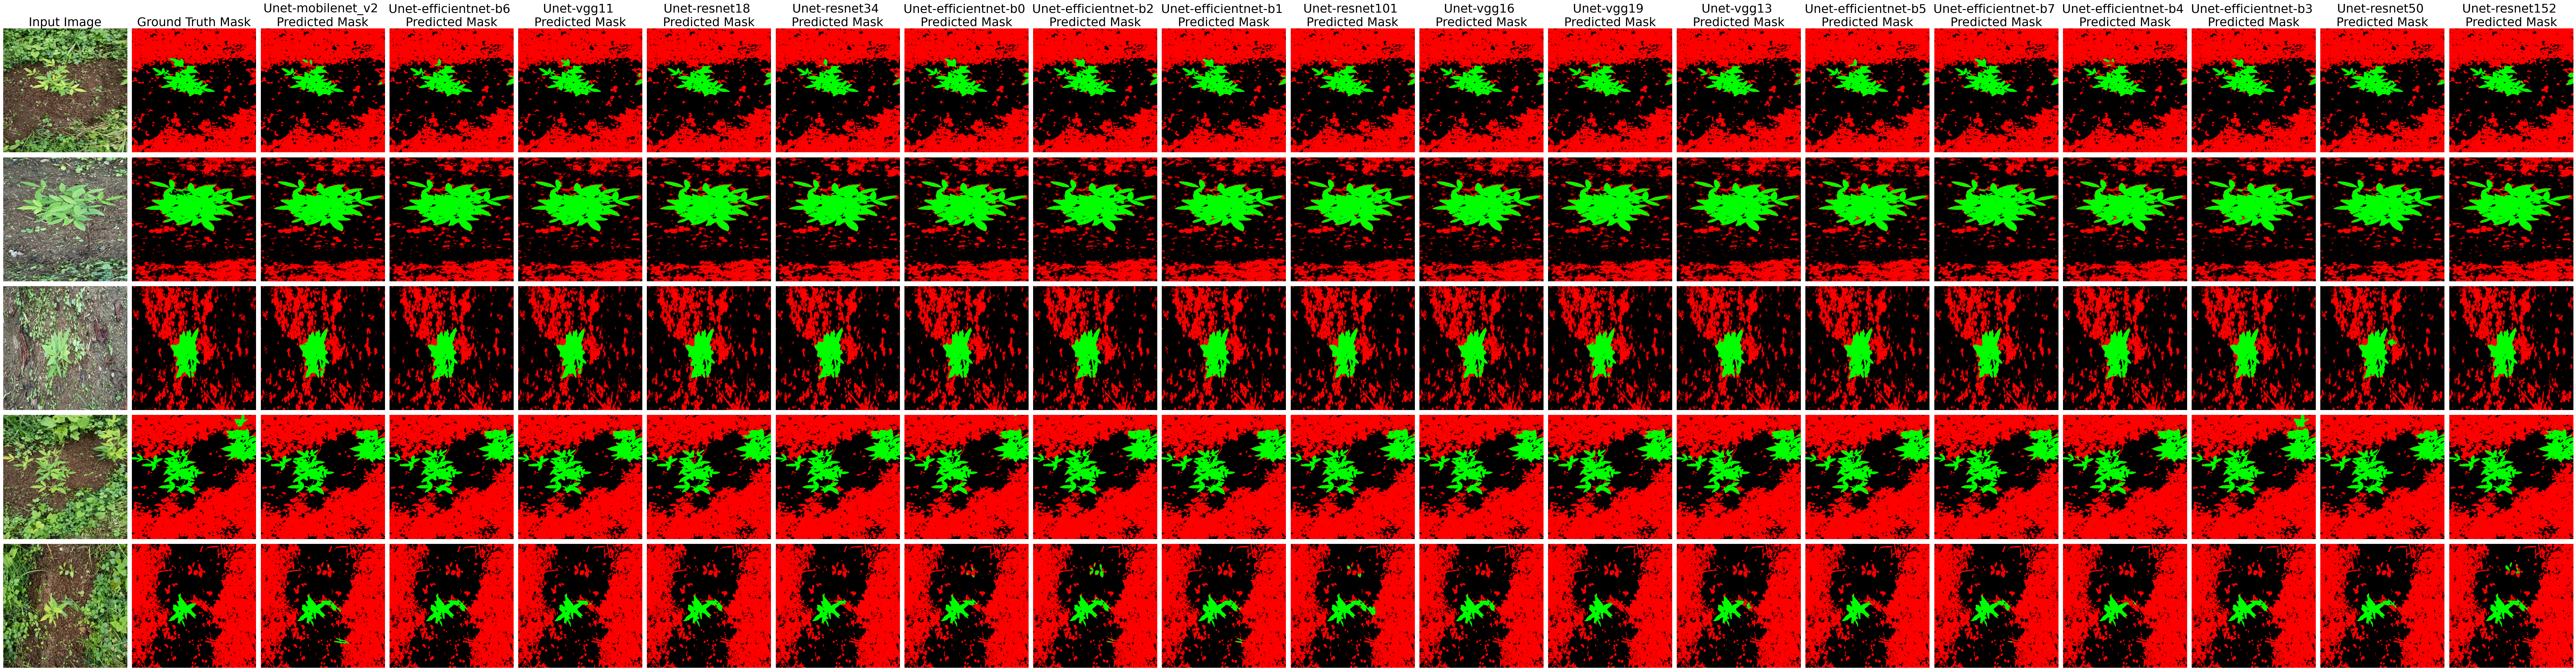

In [11]:
import os
import random
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1) Automatically gather all directories starting with "Unet-"
# ------------------------------------------------------------------------------
all_dirs = [d for d in os.listdir('.') if os.path.isdir(d)]
model_dirs = [d for d in all_dirs if d.startswith("Unet-")]
models_info = [(d, os.path.join(d, "unet_best_model.pth")) for d in model_dirs]

# ------------------------------------------------------------------------------
# 2) Define directories / file paths and hyperparameters
# ------------------------------------------------------------------------------
TEST_IMAGE_FOLDER        = 'CWD-3HSV/test/images/'
GROUND_TRUTH_MASK_FOLDER = 'CWD-3HSV/test/Morphed_Images/'
PREDICTION_SAVE_FOLDER   = 'Predictions'
os.makedirs(PREDICTION_SAVE_FOLDER, exist_ok=True)

IMG_HEIGHT  = 640
IMG_WIDTH   = 640
NUM_CLASSES = 3
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------------------------------------------------
# 3) Define transformation (as used during training)
# ------------------------------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])

# ------------------------------------------------------------------------------
# 4) Helper functions
# ------------------------------------------------------------------------------
def load_full_model(model_path):
    model = torch.load(model_path, map_location=DEVICE)
    model = model.to(DEVICE)
    model.eval()
    return model

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(DEVICE)
    return image

def load_ground_truth_mask(mask_path):
    mask = Image.open(mask_path).convert('L')
    mask = mask.resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST)
    return np.array(mask)

def generate_segmentation_mask(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)  # shape: (B, NUM_CLASSES, H, W)
        pred = torch.argmax(output, dim=1)
        return pred.squeeze().cpu().numpy()  # shape: (H, W)

def mask_to_rgb(mask_array):
    h, w = mask_array.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)
    # Define the mapping for 3 classes
    class_rgb_mapping = {
        0: (0, 0, 0),      # Black for background (or class 0)
        1: (0, 255, 0),    # Green for class 1
        2: (255, 0, 0)     # Red for class 2
    }
    for cls, color in class_rgb_mapping.items():
        rgb_image[mask_array == cls] = color
    return rgb_image

# ------------------------------------------------------------------------------
# 5) Main execution: load models, select images, and create merged figure
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    # Load all models
    loaded_models = []
    for model_name, model_path in models_info:
        if not os.path.isfile(model_path):
            continue
        model = load_full_model(model_path)
        loaded_models.append((model_name, model))
    if len(loaded_models) == 0:
        exit(0)
    
    # Gather test images
    test_image_files = [f for f in os.listdir(TEST_IMAGE_FOLDER) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    if len(test_image_files) == 0:
        exit(0)
    
    # Randomly select up to 5 images
    selected_images = random.sample(test_image_files, 5) if len(test_image_files) >= 5 else test_image_files

    # Set up figure:
    n_rows = len(selected_images)
    n_cols = 2 + len(loaded_models)  # 1: Input, 1: GT, rest: each model's prediction
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4.2 * n_rows))
    if n_rows == 1:
        axes = [axes]  # ensure axes is a list of rows

    # Process each image:
    for row_idx, image_file in enumerate(selected_images):
        input_image_path = os.path.join(TEST_IMAGE_FOLDER, image_file)
        gt_mask_name = os.path.splitext(image_file)[0] + '_morphed.png'
        gt_mask_path = os.path.join(GROUND_TRUTH_MASK_FOLDER, gt_mask_name)

        # Load and resize input image and ground truth mask for display
        original_image = Image.open(input_image_path).resize((IMG_WIDTH, IMG_HEIGHT))
        gt_mask_np = load_ground_truth_mask(gt_mask_path)
        gt_rgb = mask_to_rgb(gt_mask_np)

        # Preprocess image for model inference
        input_tensor = preprocess_image(input_image_path)

        # Column 0: Input image
        axes[row_idx][0].imshow(original_image)
        if row_idx == 0:
            axes[row_idx][0].set_title("Input Image", fontsize=27)
        axes[row_idx][0].axis('off')

        # Column 1: Ground truth mask
        axes[row_idx][1].imshow(gt_rgb)
        if row_idx == 0:
            axes[row_idx][1].set_title("Ground Truth Mask", fontsize=27)
        axes[row_idx][1].axis('off')

        # Next columns: Predictions from each model
        for model_i, (model_name, model_obj) in enumerate(loaded_models):
            pred_mask = generate_segmentation_mask(model_obj, input_tensor)
            pred_rgb = mask_to_rgb(pred_mask)
            col_idx = 2 + model_i
            axes[row_idx][col_idx].imshow(pred_rgb)
            if row_idx == 0:
                axes[row_idx][col_idx].set_title(f"{model_name} \nPredicted Mask", fontsize=27)
            axes[row_idx][col_idx].axis('off')

    plt.tight_layout()
    merged_filename = os.path.join(PREDICTION_SAVE_FOLDER, "All_Models_Predictions.png")
    plt.savefig(merged_filename, bbox_inches='tight',dpi=200)
    # Uncomment the next line if you wish to display the figure interactively
    plt.show()


# Saving Predictions of Each Model

In [3]:
import os
import random
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1) Automatically gather all directories starting with "Unet-"
# ------------------------------------------------------------------------------
model_dirs = [d for d in os.listdir('.') if os.path.isdir(d) and d.startswith("Unet-")]

# ------------------------------------------------------------------------------
# 2) Define directories and hyperparameters
# ------------------------------------------------------------------------------
TEST_IMAGE_FOLDER        = 'CWD-3HSV/test/images/'
GROUND_TRUTH_MASK_FOLDER = 'CWD-3HSV/test/Morphed_Images/'
# (The merged prediction figure for each model will be saved in a "Predictions" subfolder of that model directory.)
IMG_HEIGHT  = 640
IMG_WIDTH   = 640
NUM_CLASSES = 3
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------------------------------------------------
# 3) Define the transformation (as used during training)
# ------------------------------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])

# ------------------------------------------------------------------------------
# 4) Helper functions
# ------------------------------------------------------------------------------
def load_full_model(model_dir):
    """Load the full model from <model_dir>/unet_best_model.pth."""
    model_path = os.path.join(model_dir, "unet_best_model.pth")
    if not os.path.isfile(model_path):
        return None
    model = torch.load(model_path, map_location=DEVICE)
    model = model.to(DEVICE)
    model.eval()
    return model

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(DEVICE)
    return image

def load_ground_truth_mask(mask_path):
    mask = Image.open(mask_path).convert('L')
    mask = mask.resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST)
    return np.array(mask)

def generate_segmentation_mask(model, image_tensor):
    with torch.no_grad():
        # model outputs logits of shape (B, NUM_CLASSES, H, W)
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1)
        return pred.squeeze().cpu().numpy()  # shape: (H, W)

def mask_to_rgb(mask_array):
    h, w = mask_array.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)
    # Fixed mapping for 3 classes
    class_rgb_mapping = {
        0: (0, 0, 0),      # Black
        1: (0, 255, 0),    # Green
        2: (255, 0, 0)     # Red
    }
    for cls, color in class_rgb_mapping.items():
        rgb_image[mask_array == cls] = color
    return rgb_image

# ------------------------------------------------------------------------------
# 5) Main execution: Process each model directory
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    # Gather test images (all jpg/jpeg/png)
    test_image_files = [f for f in os.listdir(TEST_IMAGE_FOLDER) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    if len(test_image_files) == 0:
        exit(0)
    
    # Randomly select up to 5 images
    selected_images = random.sample(test_image_files, 5) if len(test_image_files) >= 5 else test_image_files

    # Process each model directory that starts with "Unet-"
    for model_dir in model_dirs:
        model = load_full_model(model_dir)
        if model is None:
            continue
        
        # Create a Predictions subfolder inside the model directory
        predictions_dir = os.path.join(model_dir, "Predictions")
        os.makedirs(predictions_dir, exist_ok=True)
        
        # Set up a figure with one row per image and 3 columns (Input, Ground Truth, Predicted)
        n_rows = len(selected_images)
        n_cols = 3
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4 * n_cols, 4.2 * n_rows))
        if n_rows == 1:
            axes = [axes]  # Ensure axes is a list of rows

        for row_idx, image_file in enumerate(selected_images):
            input_image_path = os.path.join(TEST_IMAGE_FOLDER, image_file)
            gt_mask_name = os.path.splitext(image_file)[0] + '_morphed.png'
            gt_mask_path = os.path.join(GROUND_TRUTH_MASK_FOLDER, gt_mask_name)
            
            # Load original image and ground truth for display
            original_image = Image.open(input_image_path).resize((IMG_WIDTH, IMG_HEIGHT))
            gt_mask_np = load_ground_truth_mask(gt_mask_path)
            gt_rgb = mask_to_rgb(gt_mask_np)
            
            # Preprocess image for inference
            input_tensor = preprocess_image(input_image_path)
            
            # Column 0: Input image
            axes[row_idx][0].imshow(original_image)
            if row_idx == 0:
                axes[row_idx][0].set_title("Input Image", fontsize=27)
            axes[row_idx][0].axis('off')
            
            # Column 1: Ground truth mask
            axes[row_idx][1].imshow(gt_rgb)
            if row_idx == 0:
                axes[row_idx][1].set_title("Ground Truth Mask", fontsize=27)
            axes[row_idx][1].axis('off')
            
            # Column 2: Predicted mask from this model
            pred_mask = generate_segmentation_mask(model, input_tensor)
            pred_rgb = mask_to_rgb(pred_mask)
            axes[row_idx][2].imshow(pred_rgb)
            if row_idx == 0:
                axes[row_idx][2].set_title(f"{model_dir} \nPredicted Mask", fontsize=27)
            axes[row_idx][2].axis('off')
        
        plt.tight_layout()
        merged_filename = os.path.join(predictions_dir, "All_Models_Predictions.png")
        # Save the figure at high resolution
        plt.savefig(merged_filename, bbox_inches='tight', dpi=300)
        plt.close(fig)


/tmp/ipykernel_7116/871552261.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=DEVICE)


# Saving Results of each model

In [4]:
import os
import pandas as pd

# ------------------------------------------------------------------------------
# 1) Automatically gather all directories starting with "Unet-"
# ------------------------------------------------------------------------------
model_directories = [d for d in os.listdir('.') if os.path.isdir(d) and d.startswith("Unet-")]

# Name of the Excel file in each model directory
excel_filename = "Performance_Evaluation_Metrics.xlsx"

# Loop over each found model directory
for model_dir in model_directories:
    # Construct the full path to the Excel file
    excel_path = os.path.join(model_dir, excel_filename)
    
    # Skip this directory if the file does not exist
    if not os.path.isfile(excel_path):
        continue
    
    # Read the Excel file into a DataFrame
    df = pd.read_excel(excel_path)
    if df.empty:
        continue

    # Get the last (bottom) row from the DataFrame
    last_row = df.iloc[-1]
    
    # ------------------ Overall Metrics ------------------
    overall_metrics = {
        "Metric": [
            "Accuracy",
            "Precision",
            "Recall",
            "F1 Score",
            "Mean IoU",
            "Frequency Weighted IoU",
            "Mean Dice",
            "Mean Jaccard"
        ],
        "Value": [
            last_row["Accuracy"],
            last_row["Precision"],
            last_row["Recall"],
            last_row["F1 Score"],
            last_row["Mean IoU"],
            last_row["Frequency Weighted IoU"],
            last_row["Mean Dice"],
            last_row["Mean Jaccard"]
        ]
    }
    overall_df = pd.DataFrame(overall_metrics)
    
    # ------------------ Per-Class Metrics ------------------
    per_class_data = {
        "Class": ["Class 0", "Class 1", "Class 2"],
        "Accuracy": [
            last_row["Accuracy Class 0"],
            last_row["Accuracy Class 1"],
            last_row["Accuracy Class 2"]
        ],
        "Precision": [
            last_row["Precision Class 0"],
            last_row["Precision Class 1"],
            last_row["Precision Class 2"]
        ],
        "Recall": [
            last_row["Recall Class 0"],
            last_row["Recall Class 1"],
            last_row["Recall Class 2"]
        ],
        "F1 Score": [
            last_row["F1 Score Class 0"],
            last_row["F1 Score Class 1"],
            last_row["F1 Score Class 2"]
        ],
        "IoU": [
            last_row["IoU Class 0"],
            last_row["IoU Class 1"],
            last_row["IoU Class 2"]
        ],
        "Dice": [
            last_row["Dice Coefficient Class 0"],
            last_row["Dice Coefficient Class 1"],
            last_row["Dice Coefficient Class 2"]
        ],
        "Jaccard": [
            last_row["Jaccard Index Class 0"],
            last_row["Jaccard Index Class 1"],
            last_row["Jaccard Index Class 2"]
        ]
    }
    per_class_df = pd.DataFrame(per_class_data)
    
    # ------------------------------------------------------------------------------
    # 3) Save the new Excel files in a Results subfolder of the model directory
    # ------------------------------------------------------------------------------
    results_dir = os.path.join(model_dir, "Results")
    os.makedirs(results_dir, exist_ok=True)
    
    overall_excel_path = os.path.join(results_dir, "Overall_Metrics.xlsx")
    per_class_excel_path = os.path.join(results_dir, "Per_Class_Metrics.xlsx")
    
    overall_df.to_excel(overall_excel_path, index=False)
    per_class_df.to_excel(per_class_excel_path, index=False)


# Seperating All Models Perdormance Evaluation Sheet

In [5]:
import os
import pandas as pd

# ------------------------------------------------------------------------------
# 1) Path to the merged Excel file
# ------------------------------------------------------------------------------
merged_excel_path = os.path.join("Results", "All_Models_Performance_Evaluation_Metrics.xlsx")

# ------------------------------------------------------------------------------
# 2) Read the Excel file into a DataFrame
# ------------------------------------------------------------------------------
df = pd.read_excel(merged_excel_path)

# ------------------------------------------------------------------------------
# 3) Mapping to change model names
# ------------------------------------------------------------------------------
name_mapping = {
    "unet_best_model.pth": "Unet",
    "unetplusplus_best_model.pth": "Unet++",
    "manet_best_model.pth": "MAnet",
    "linknet_best_model.pth": "Linknet",
    "fpn_best_model.pth": "FPN",
    "pspnet_best_model.pth": "PSPNet",
    "pan_best_model.pth": "PAN",
    "deeplabv3_best_model.pth": "DeepLabV3",
    "deeplabv3plus_best_model.pth": "DeepLabV3+",
    "upernet_best_model.pth": "UPerNet",
    "segformer_best_model.pth": "Segformer"
}

# Update the "Model Name" column based on the mapping.
# If a model name is not found in the mapping, leave it unchanged.
df["Model Name"] = df["Model Name"].apply(lambda x: name_mapping.get(x, x))

# ------------------------------------------------------------------------------
# 4) Create Overall Metrics DataFrame
# ------------------------------------------------------------------------------
overall_columns = [
    "Model Name",
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Mean IoU",
    "Weighted IoU",
    "Frequency Weighted IoU",
    "Mean Dice",
    "Mean Jaccard"
]
overall_df = df[overall_columns].copy()

# ------------------------------------------------------------------------------
# 5) Create Per-Class Metrics DataFrame
# ------------------------------------------------------------------------------
per_class_columns = [
    "Model Name",
    "Accuracy Class 0", "Accuracy Class 1", "Accuracy Class 2",
    "Precision Class 0", "Precision Class 1", "Precision Class 2",
    "Recall Class 0", "Recall Class 1", "Recall Class 2",
    "F1 Score Class 0", "F1 Score Class 1", "F1 Score Class 2",
    "IoU Class 0", "IoU Class 1", "IoU Class 2",
    "Dice Coefficient Class 0", "Dice Coefficient Class 1", "Dice Coefficient Class 2",
    "Jaccard Index Class 0", "Jaccard Index Class 1", "Jaccard Index Class 2"
]
per_class_df = df[per_class_columns].copy()

# ------------------------------------------------------------------------------
# 6) Save the two DataFrames to Excel (overwrite if re-executed)
# ------------------------------------------------------------------------------
overall_excel_path = os.path.join("Results", "Overall_Metrics.xlsx")
per_class_excel_path = os.path.join("Results", "Per_Class_Metrics.xlsx")

overall_df.to_excel(overall_excel_path, index=False)
per_class_df.to_excel(per_class_excel_path, index=False)

print(f"Saved overall metrics to: {overall_excel_path}")
print(f"Saved per-class metrics to: {per_class_excel_path}")


Saved overall metrics to: Results/Overall_Metrics.xlsx
Saved per-class metrics to: Results/Per_Class_Metrics.xlsx
